In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, plot_style, util

In [2]:
data_dir = 'data'
amp_mesh = np.load(data_dir + '/amp_mesh.npy')
dur_mesh = np.load(data_dir + '/dur_mesh.npy')
longest_paths = np.load(data_dir + '/longest_paths.npy')

In [3]:
amp_mesh.shape, dur_mesh.shape, longest_paths.shape

((30, 30), (30, 30), (900,))

In [4]:
amp_dur_pairs = np.array(list(zip(amp_mesh.ravel(), dur_mesh.ravel())))
longest_idxs = np.argsort(longest_paths)[::-1]
amp_dur_pairs[longest_idxs]

array([[1.98508591e+01, 1.72413793e-03],
       [4.87418394e+01, 3.27586207e-02],
       [5.33229508e+01, 1.72413793e-02],
       ...,
       [9.67567385e+00, 0.00000000e+00],
       [8.84441189e+00, 0.00000000e+00],
       [7.39000000e+00, 0.00000000e+00]])

In [5]:
# find all states
Wji, pset, _, _, _, _ = util.load_fiducial_network(True)
rE_target = 5
rI_target = 10
max_duration = 6
dt =1e-5

print("Finding states...")
numPairs = Wji.shape[1]
states = network_model.get_all_states(Wji, pset, numPairs, rE_target, rI_target, duration = max_duration, dt=dt)
_, unique_idxs = np.unique(np.round(states, 0), axis=0, return_index=True)  # remove duplicates
states = [np.array(state) for state in states[unique_idxs]]  # convert to list
print("Found states")

Finding states...
Found states


In [6]:
# make the sample network
amp, dur = 19.85085909119401, 0.001724137931034483
G, _ = network_model.get_state_transition_graph(Wji, pset, amp, dur, Eactive=rE_target, Iactive=rI_target, max_duration=max_duration, dt=dt, states=states)

In [9]:
import networkx as nx

10


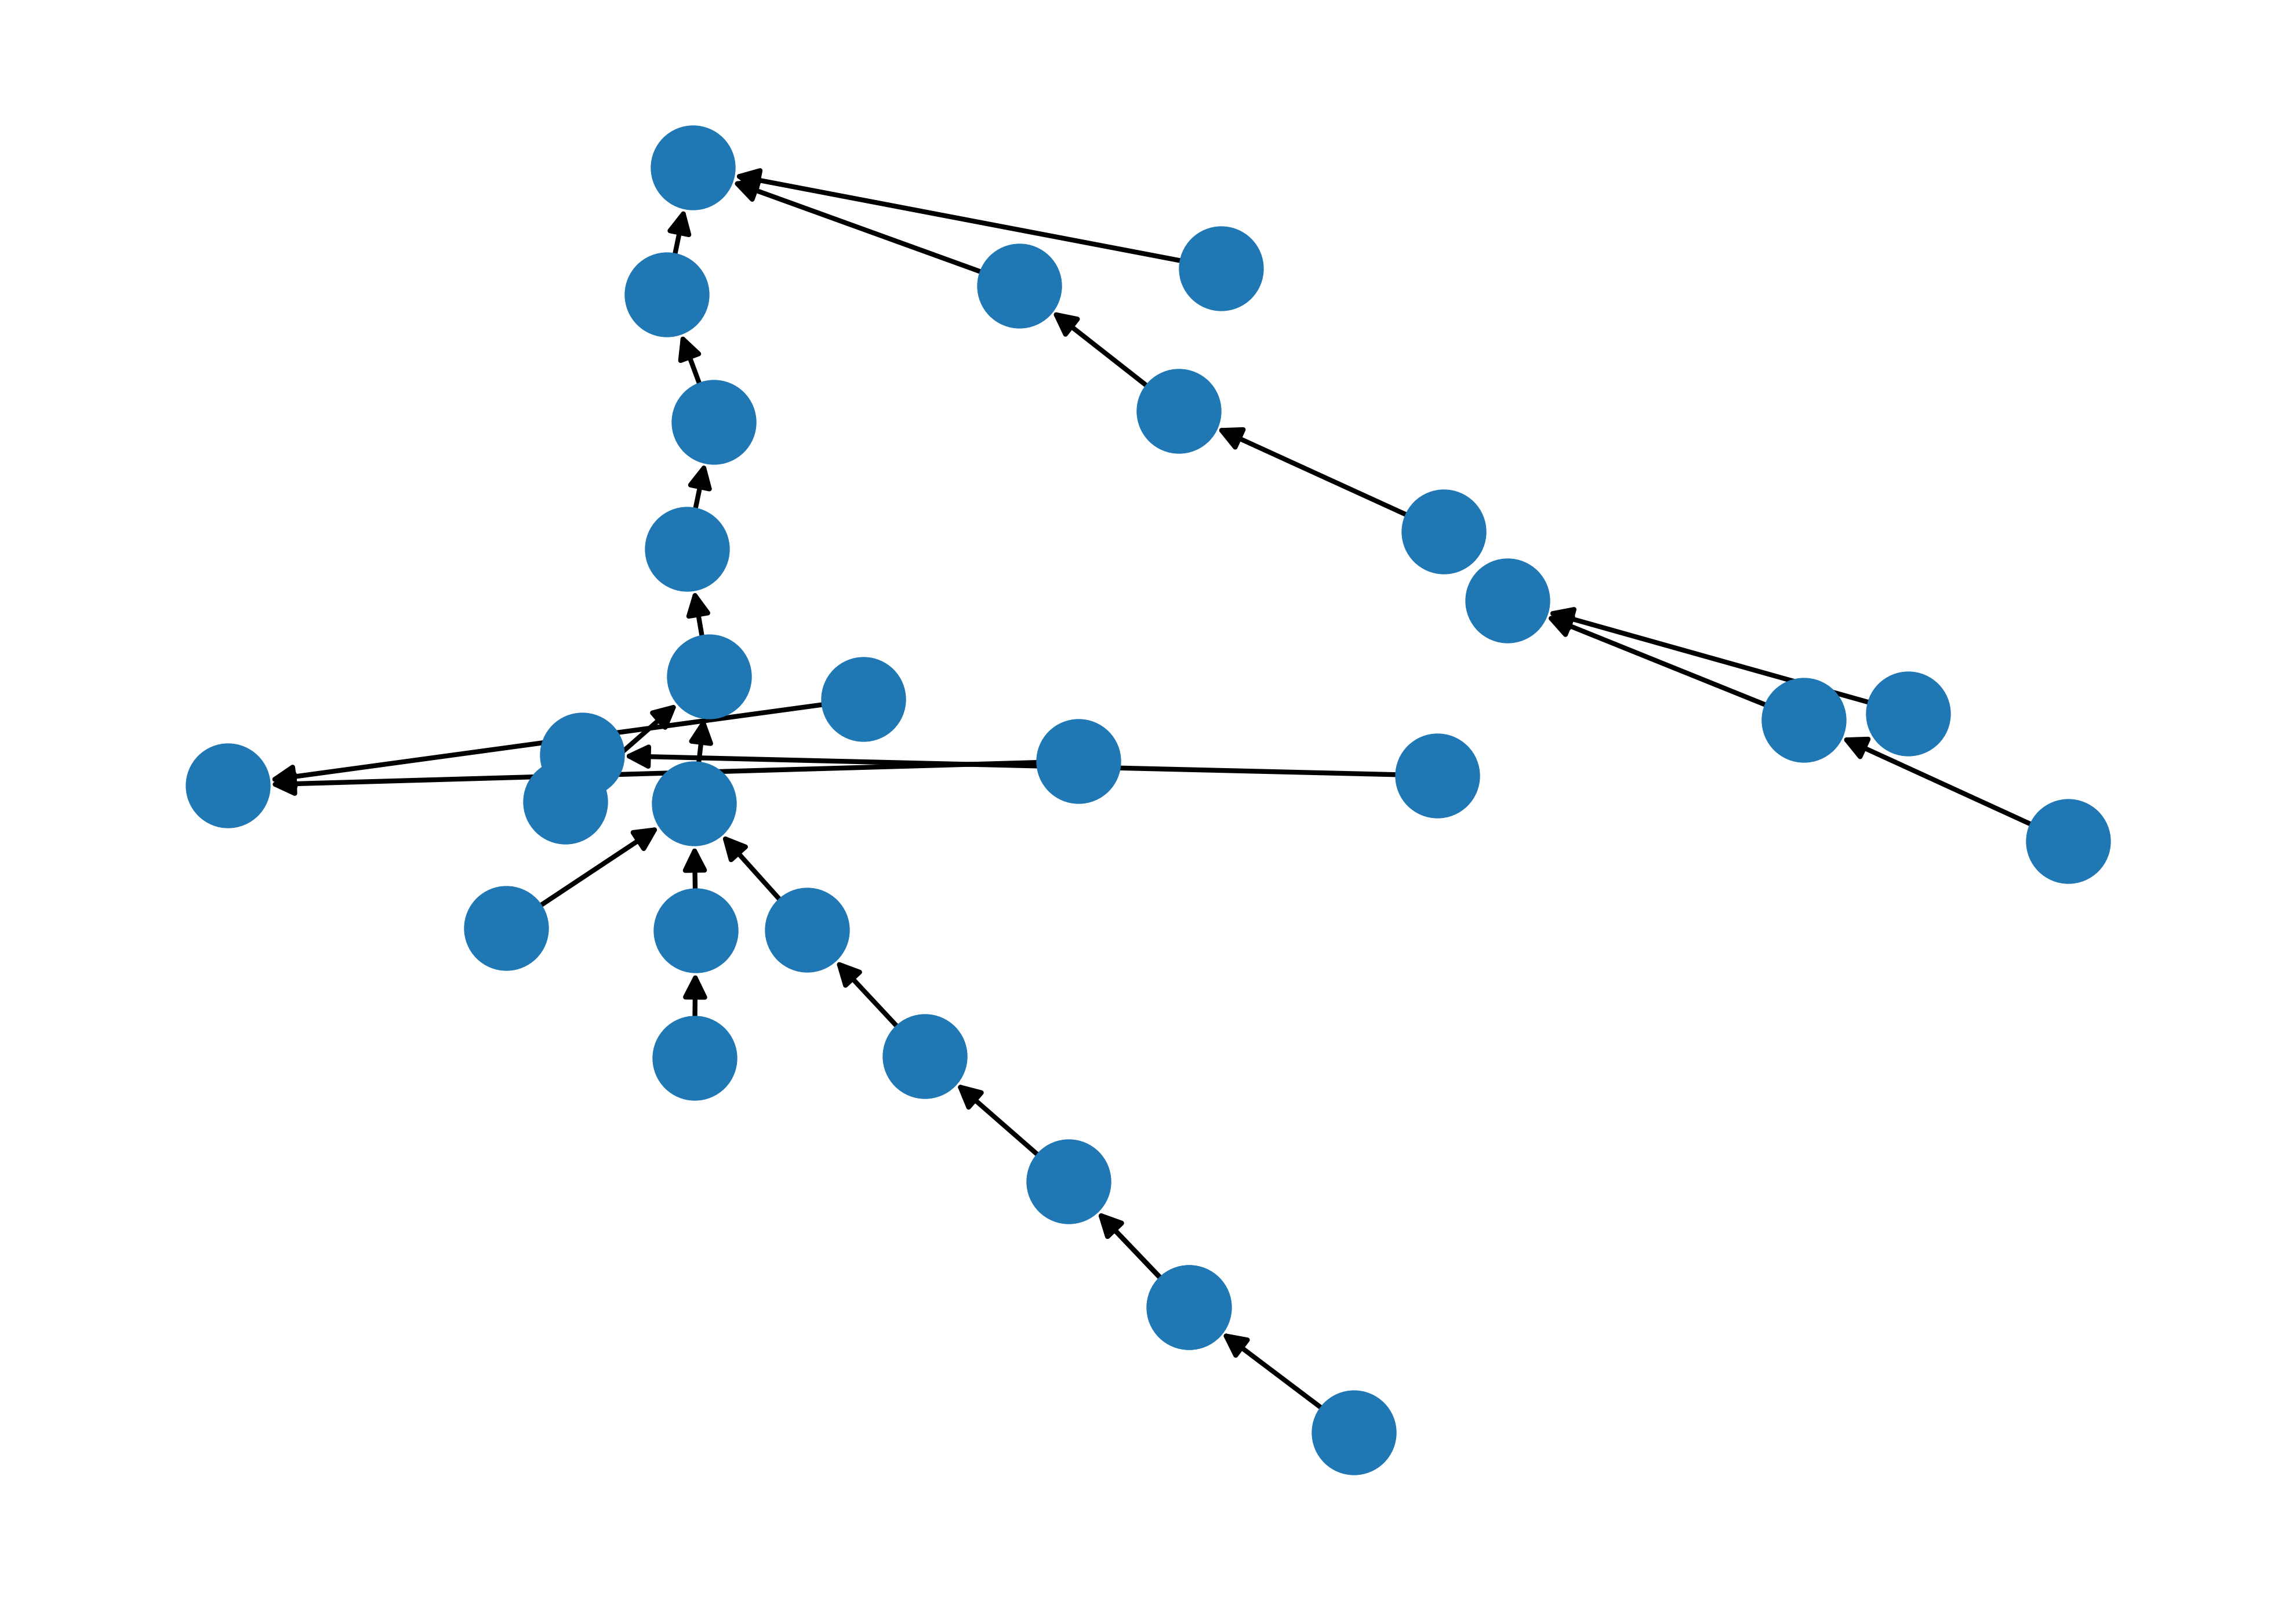

In [10]:
best_pairs = []
best_G = []
for amp, dur in amp_dur_pairs[longest_idxs]:
    # make G
    G, _ = network_model.get_state_transition_graph(Wji, pset, amp, dur, Eactive=rE_target, Iactive=rI_target, max_duration=max_duration, dt=dt, states=states)
    length = network_model.longest_path(G)
    print(length)
    # plot it
    nx.draw_kamada_kawai(G)
    plt.show()
    # save
    save = input("Save it? (y/n)").lower() == 'y'
    if save:
        best_pairs.append((amp, dur))
        best_G.append(G)
    # continue?
    cont = input("Continue? (y/n)").lower() == 'y'
    if not cont:
        break

In [11]:
weak_components = list(nx.weakly_connected_components(G))
colors = [i for i in range(len(weak_components))]
node_colors_dict = {node: colors[i] for i, comp in enumerate(weak_components) for node in comp}
node_colors = [node_colors_dict[node] for node in list(G)]

In [12]:
edge_colors = [node_colors_dict[edge[0]] for edge in G.edges()]

In [13]:
longest_path = network_model.get_longest_path(G)
edge_widths = [2 if edge[0] in longest_path and edge[1] in longest_path else 1 for edge in G.edges()]

In [14]:
longest_edges = [(u, v) for u, v in G.edges() if u in longest_path and v in longest_path]

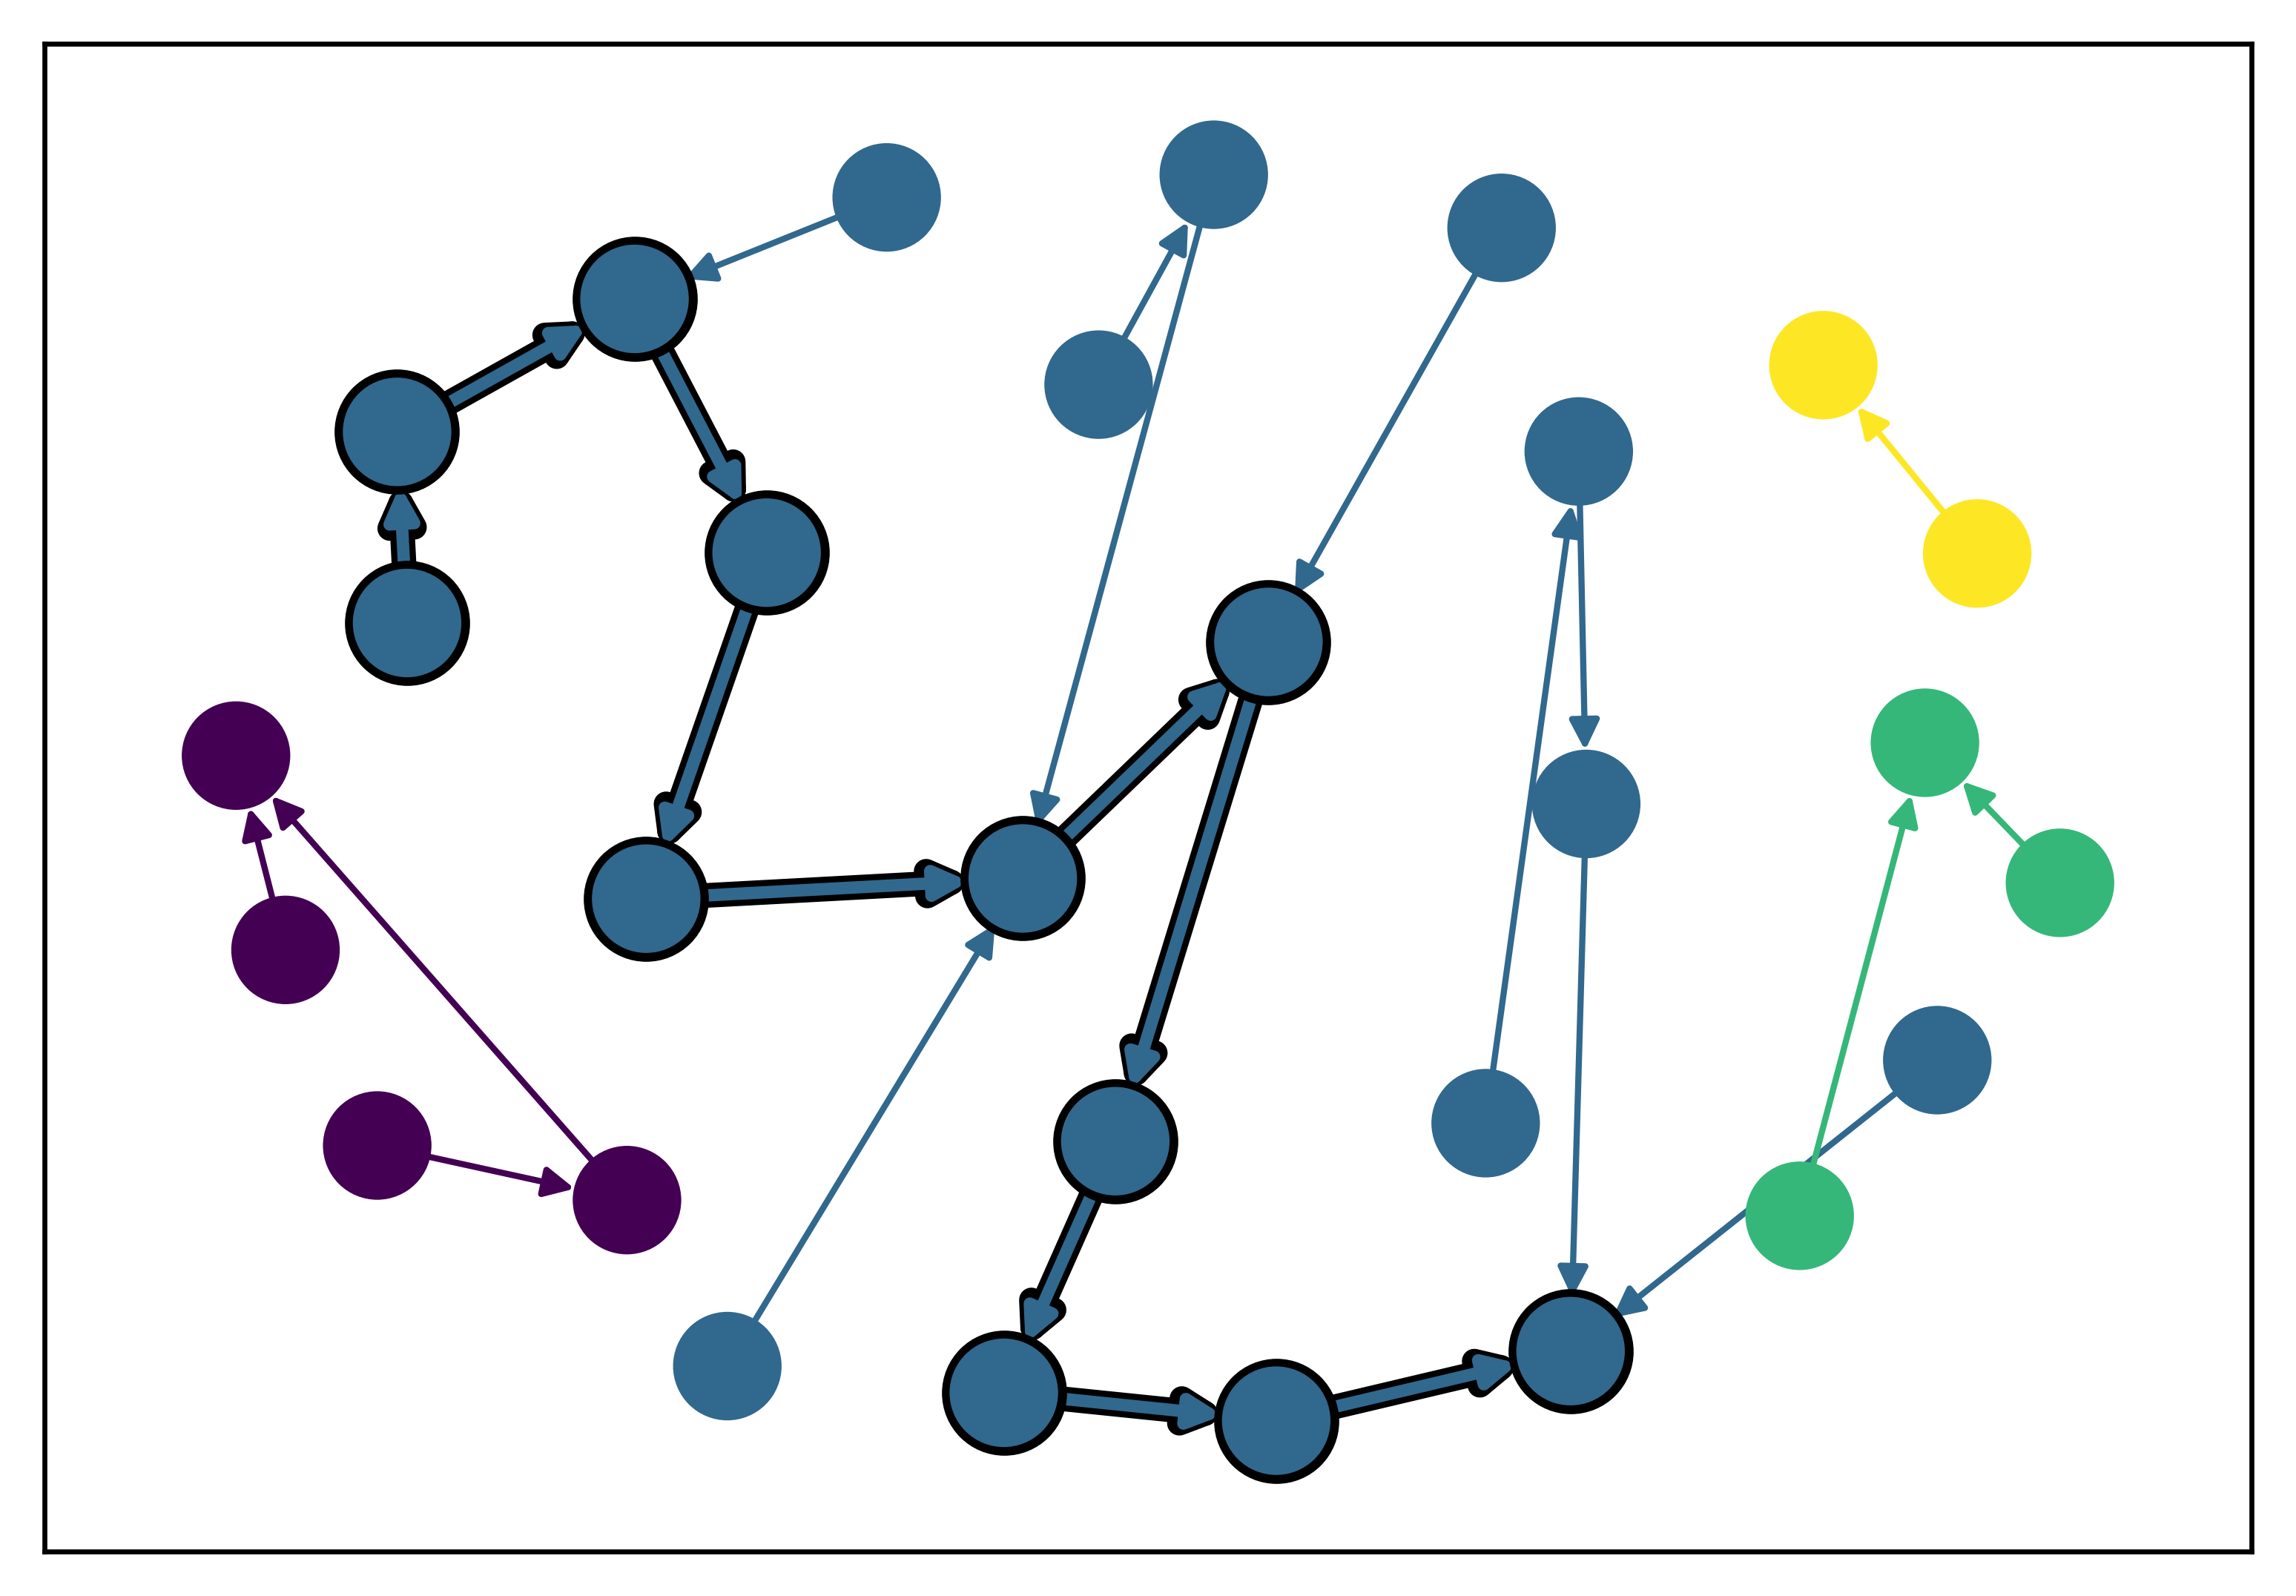

In [15]:
nx.draw_networkx_nodes(G, nodelist=longest_path, pos = nx.arf_layout(G, pos=nx.planar_layout(G)), node_color='k',
                      node_size=400)
nx.draw_networkx_edges(G, edgelist=longest_edges, pos = nx.arf_layout(G, pos=nx.planar_layout(G)), arrows=True,
                        edge_color='k', width=4, node_size=200)
nx.draw_networkx_nodes(G, pos = nx.arf_layout(G, pos=nx.planar_layout(G)), node_color = node_colors)
nx.draw_networkx_edges(G, pos = nx.arf_layout(G, pos=nx.planar_layout(G)), arrows=True, 
                       edge_color=edge_colors, width=edge_widths)
plt.show()

In [16]:
equil_duration = 2
total_duration = 11*equil_duration + 10*dur
equil_tsteps = int(total_duration/dt)
IappE = np.zeros((numPairs, equil_tsteps))
for i in range(10):
    IappE[:, int((equil_duration * (i+1) + dur*i)/dt):int((equil_duration * (i+1) + dur*(i+1))/dt)] = amp
IappI = np.copy(IappE)

r0 = states[24]
rates = network_model.simulateISN(Wji, numPairs, r0, pset, IappE, IappI, dt, total_duration)

In [17]:
raw_time_len = min(rates.shape[-1], IappE.shape[-1])
rates, IappE = rates[:,:,:raw_time_len], IappE[:, :raw_time_len]

In [18]:
def plot_trace(rates, IappE, ax1, ax2):
    raw_time_len = rates.shape[-1]
    # new_rates should contain the rates of both units in each pair, in order
    new_rates = np.zeros((2*numPairs, raw_time_len))
    for i in range(numPairs):
        new_rates[2*i] = rates[i, 0]
        new_rates[2*i + 1] = rates[i, 1]
    # plot firing rates
    vals = ax1.imshow(new_rates[:, :], cmap = 'afmhot', interpolation='nearest', aspect='auto', vmin=0, vmax= int(np.max(new_rates))+1)
    ax1.set_ylabel("Unit ID")
    ax1.set_yticks(np.arange(0.5, 2*numPairs, 2), labels=np.arange(numPairs), minor=False)
    ax1.grid(which='minor', color='k', linestyle='-', linewidth=2)
    ax1.set_xticks(np.arange(0, raw_time_len, int(4/dt)), labels=[])
    ax1.tick_params(which='minor', length=0)

    # plot Iapp
    x2ticks = np.arange(0, raw_time_len, int(4/dt))
    ax2.set_xticks(x2ticks, labels = np.round(np.linspace(0, raw_time_len*dt, len(x2ticks)), 0))
    ax2.plot(IappE[0])
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("$I_{app}$")
    
    return vals

State 0


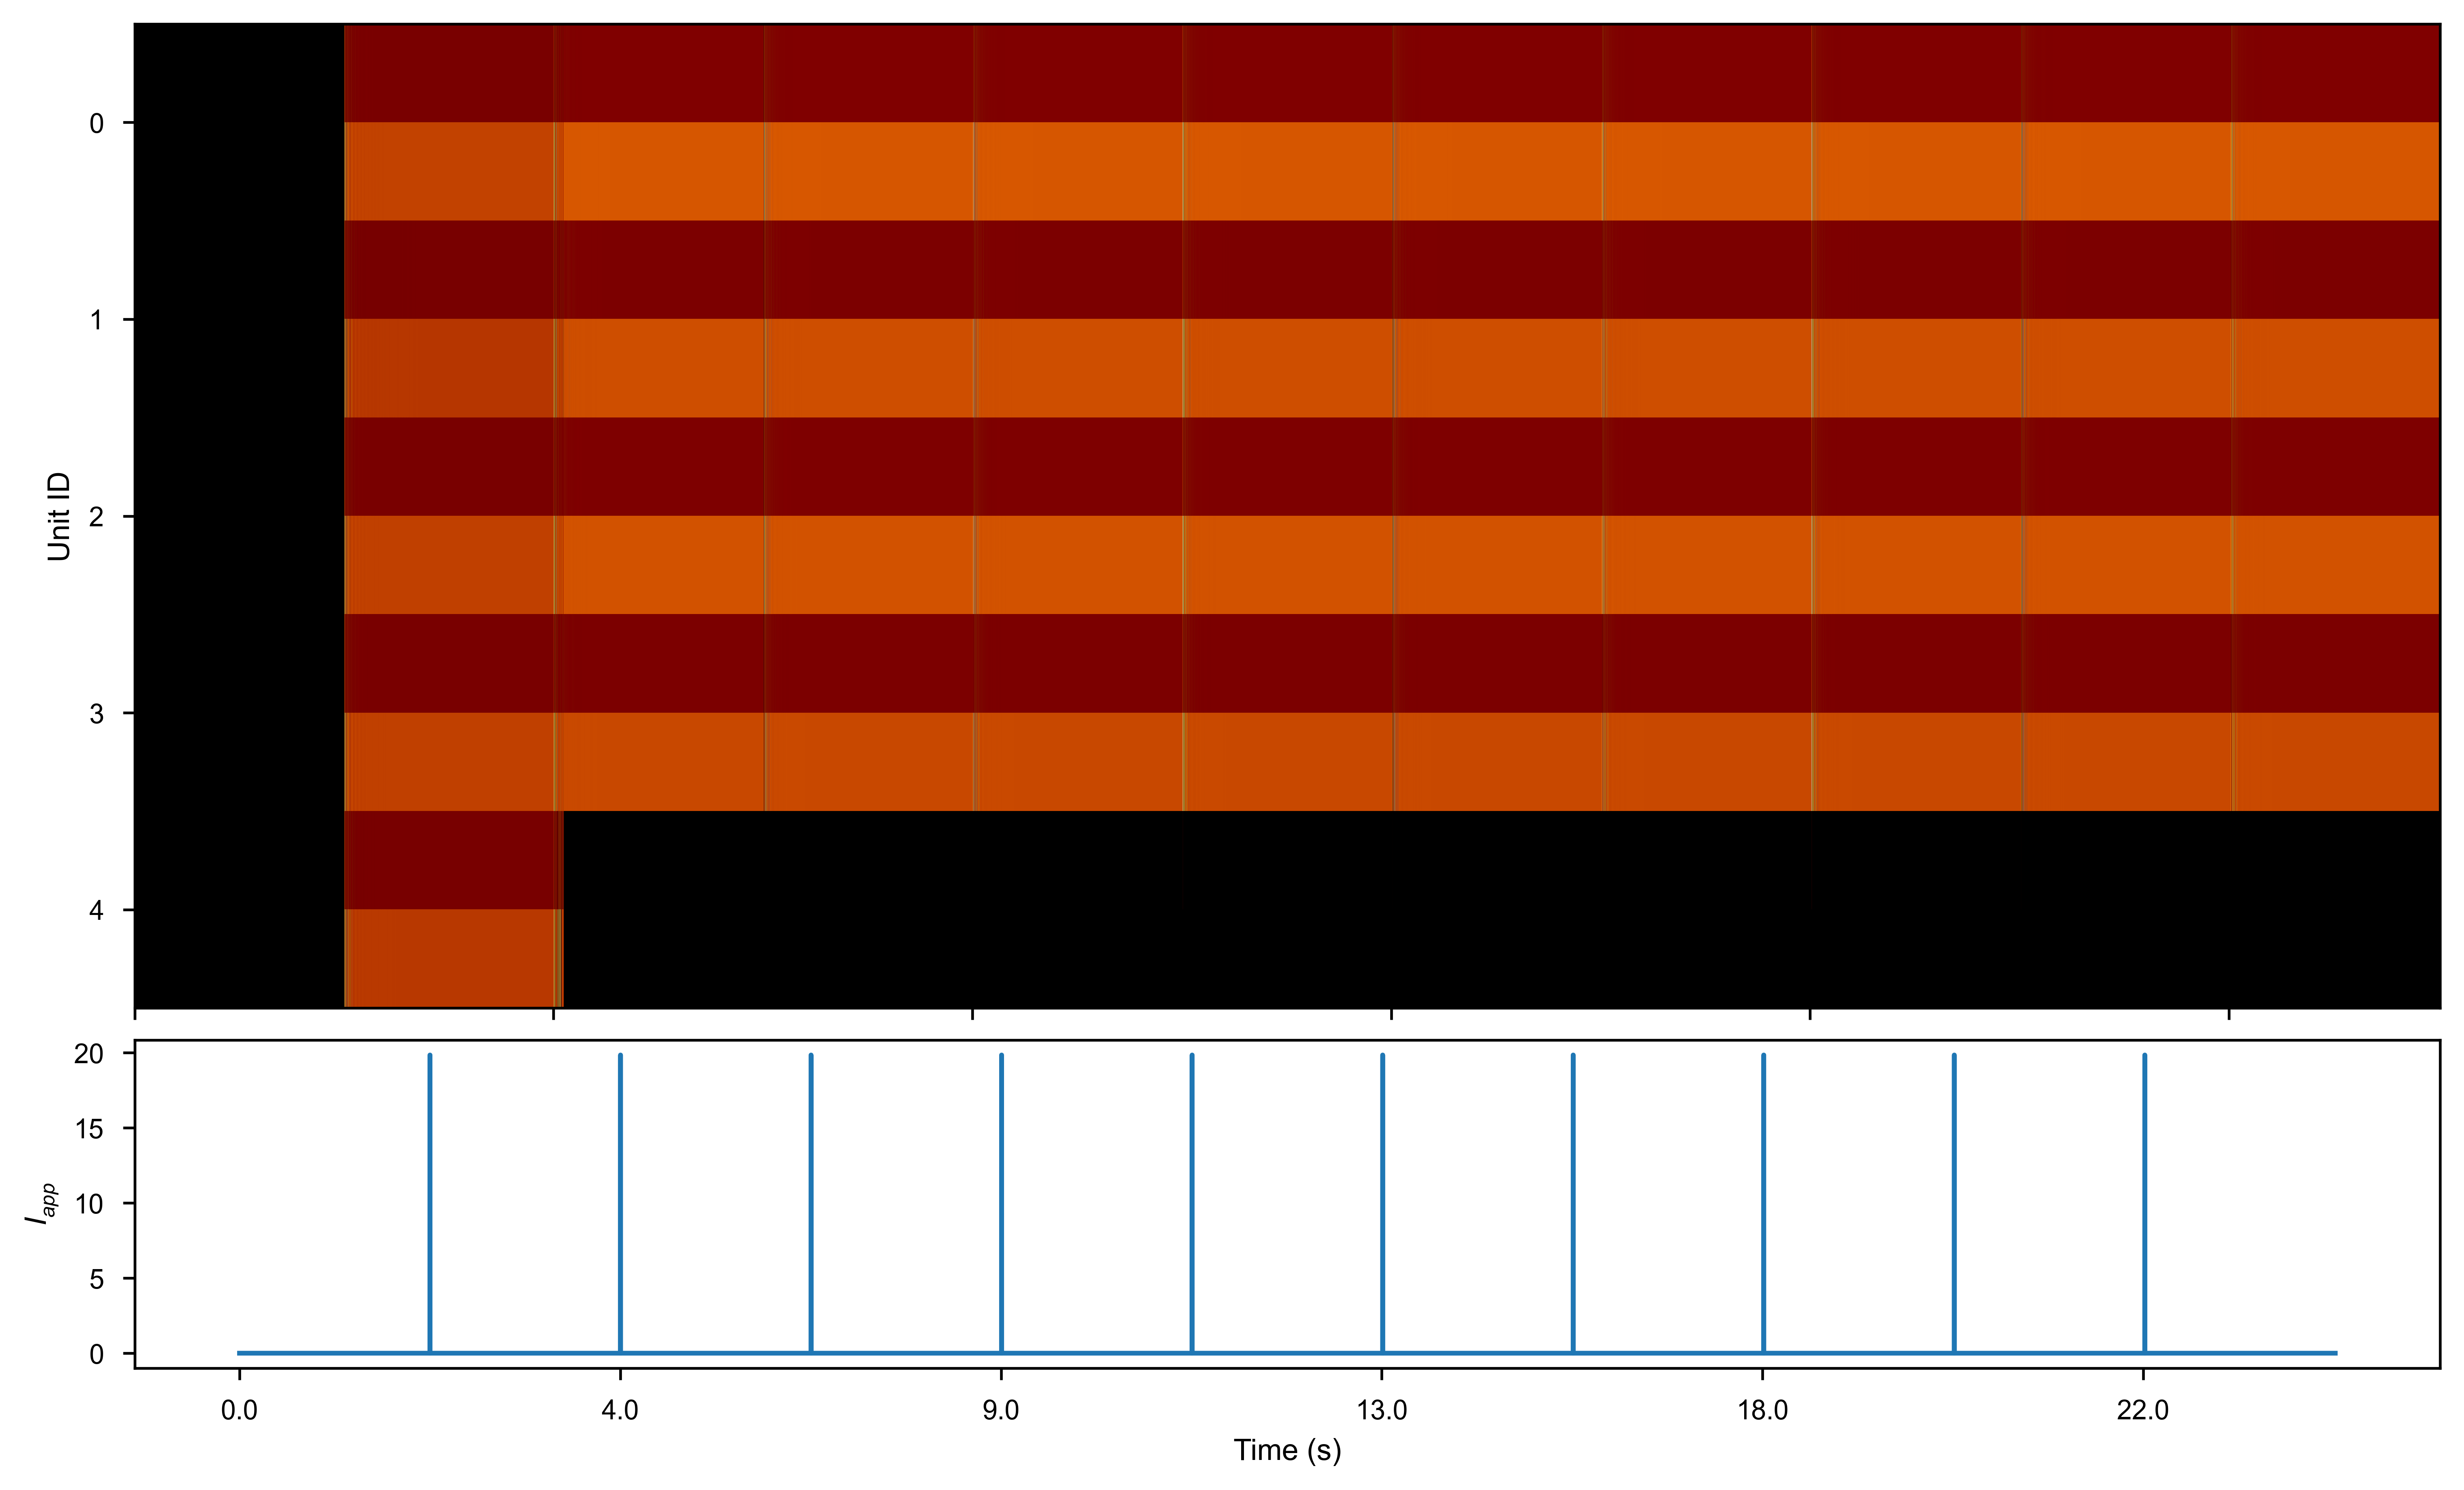

State 1


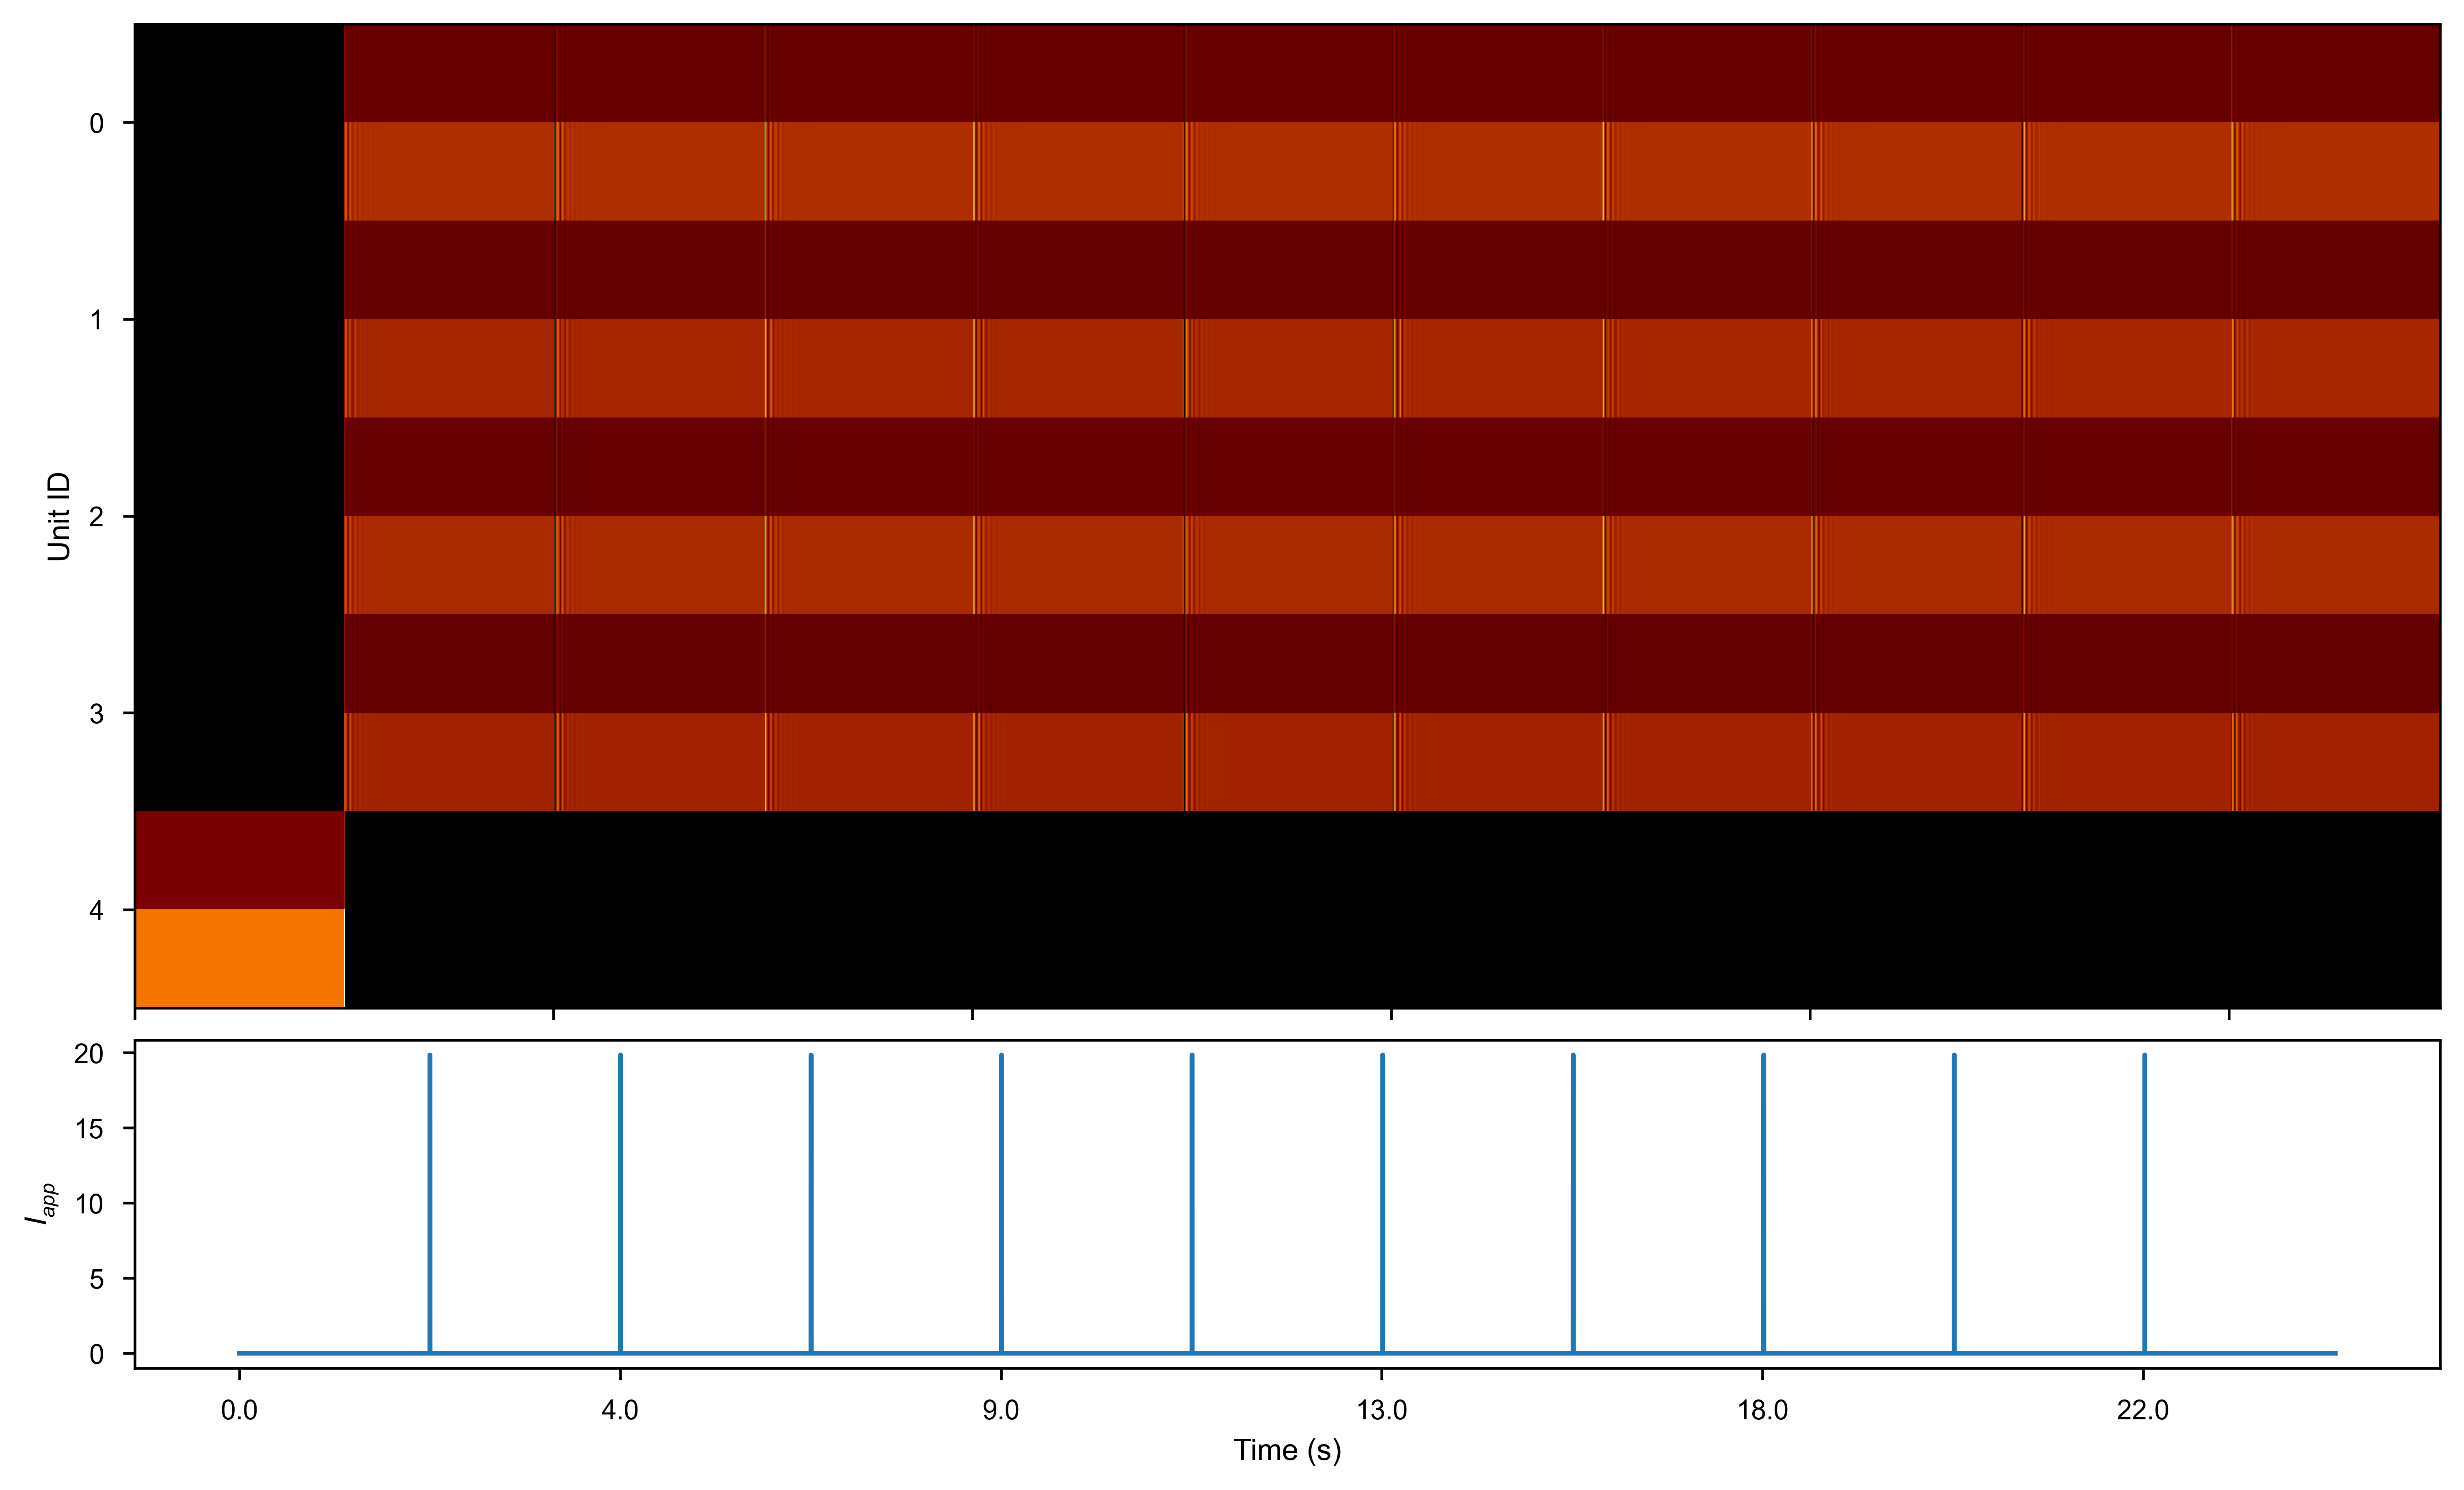

State 2


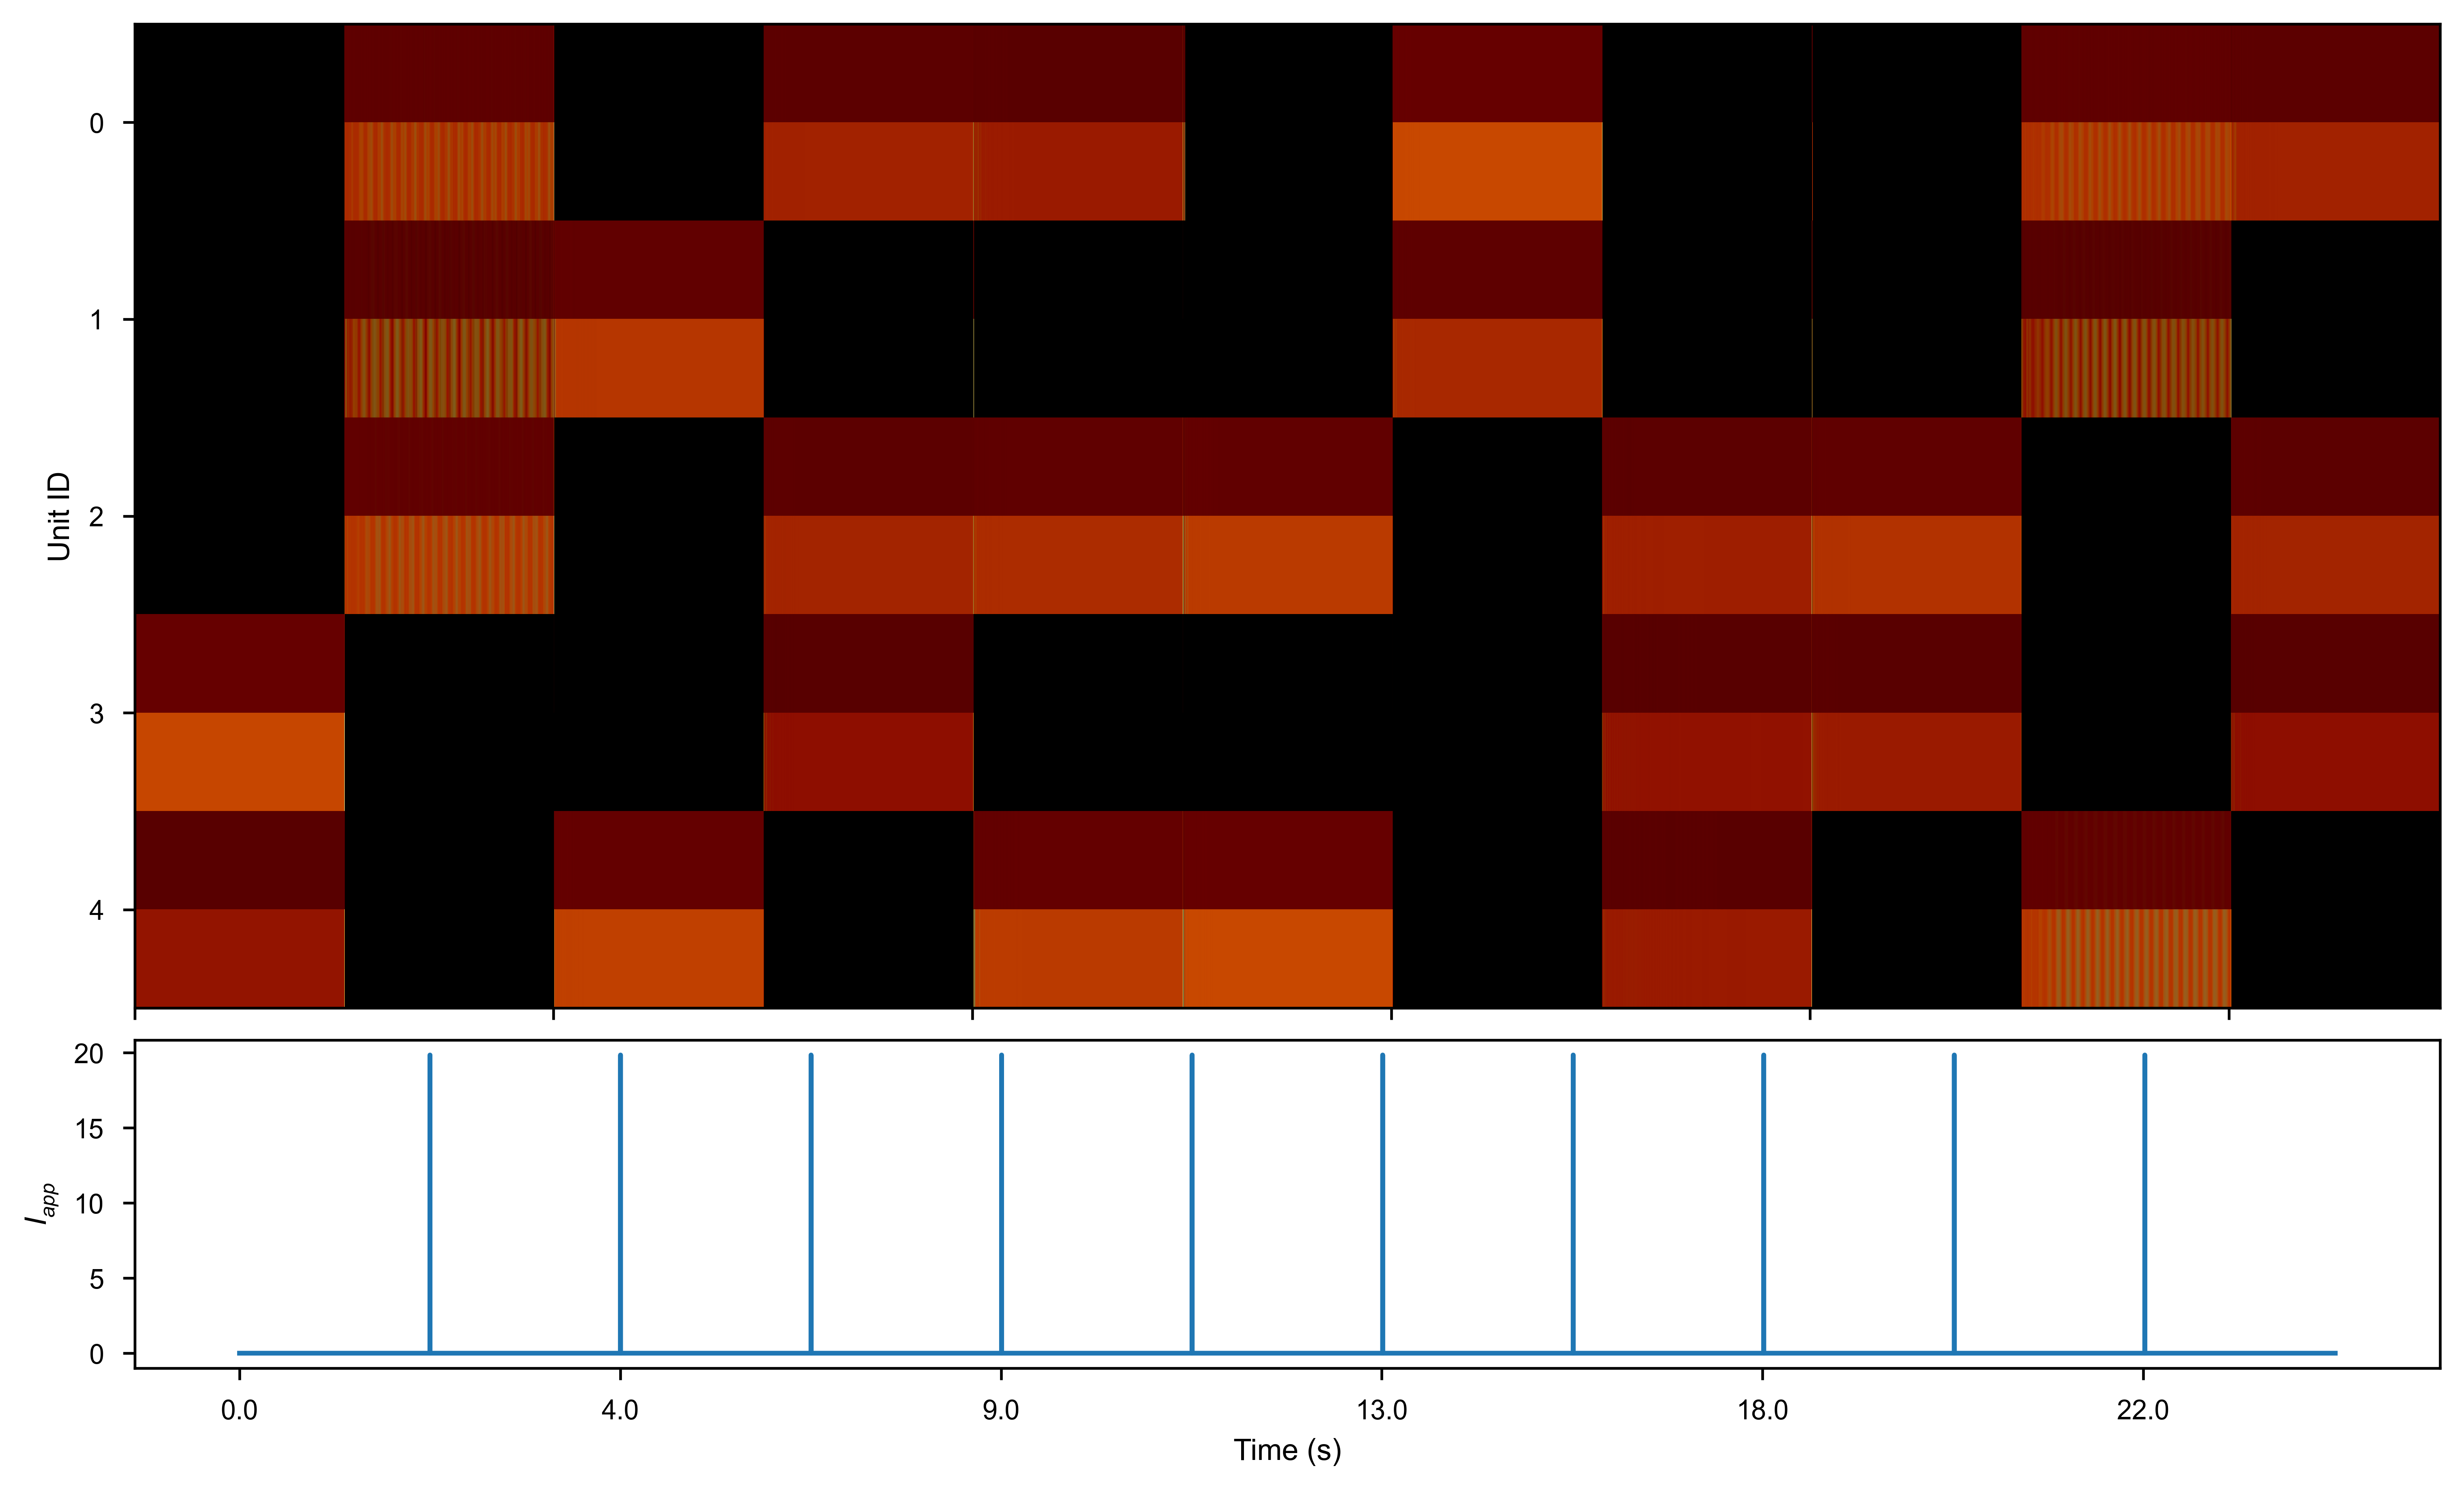

State 3


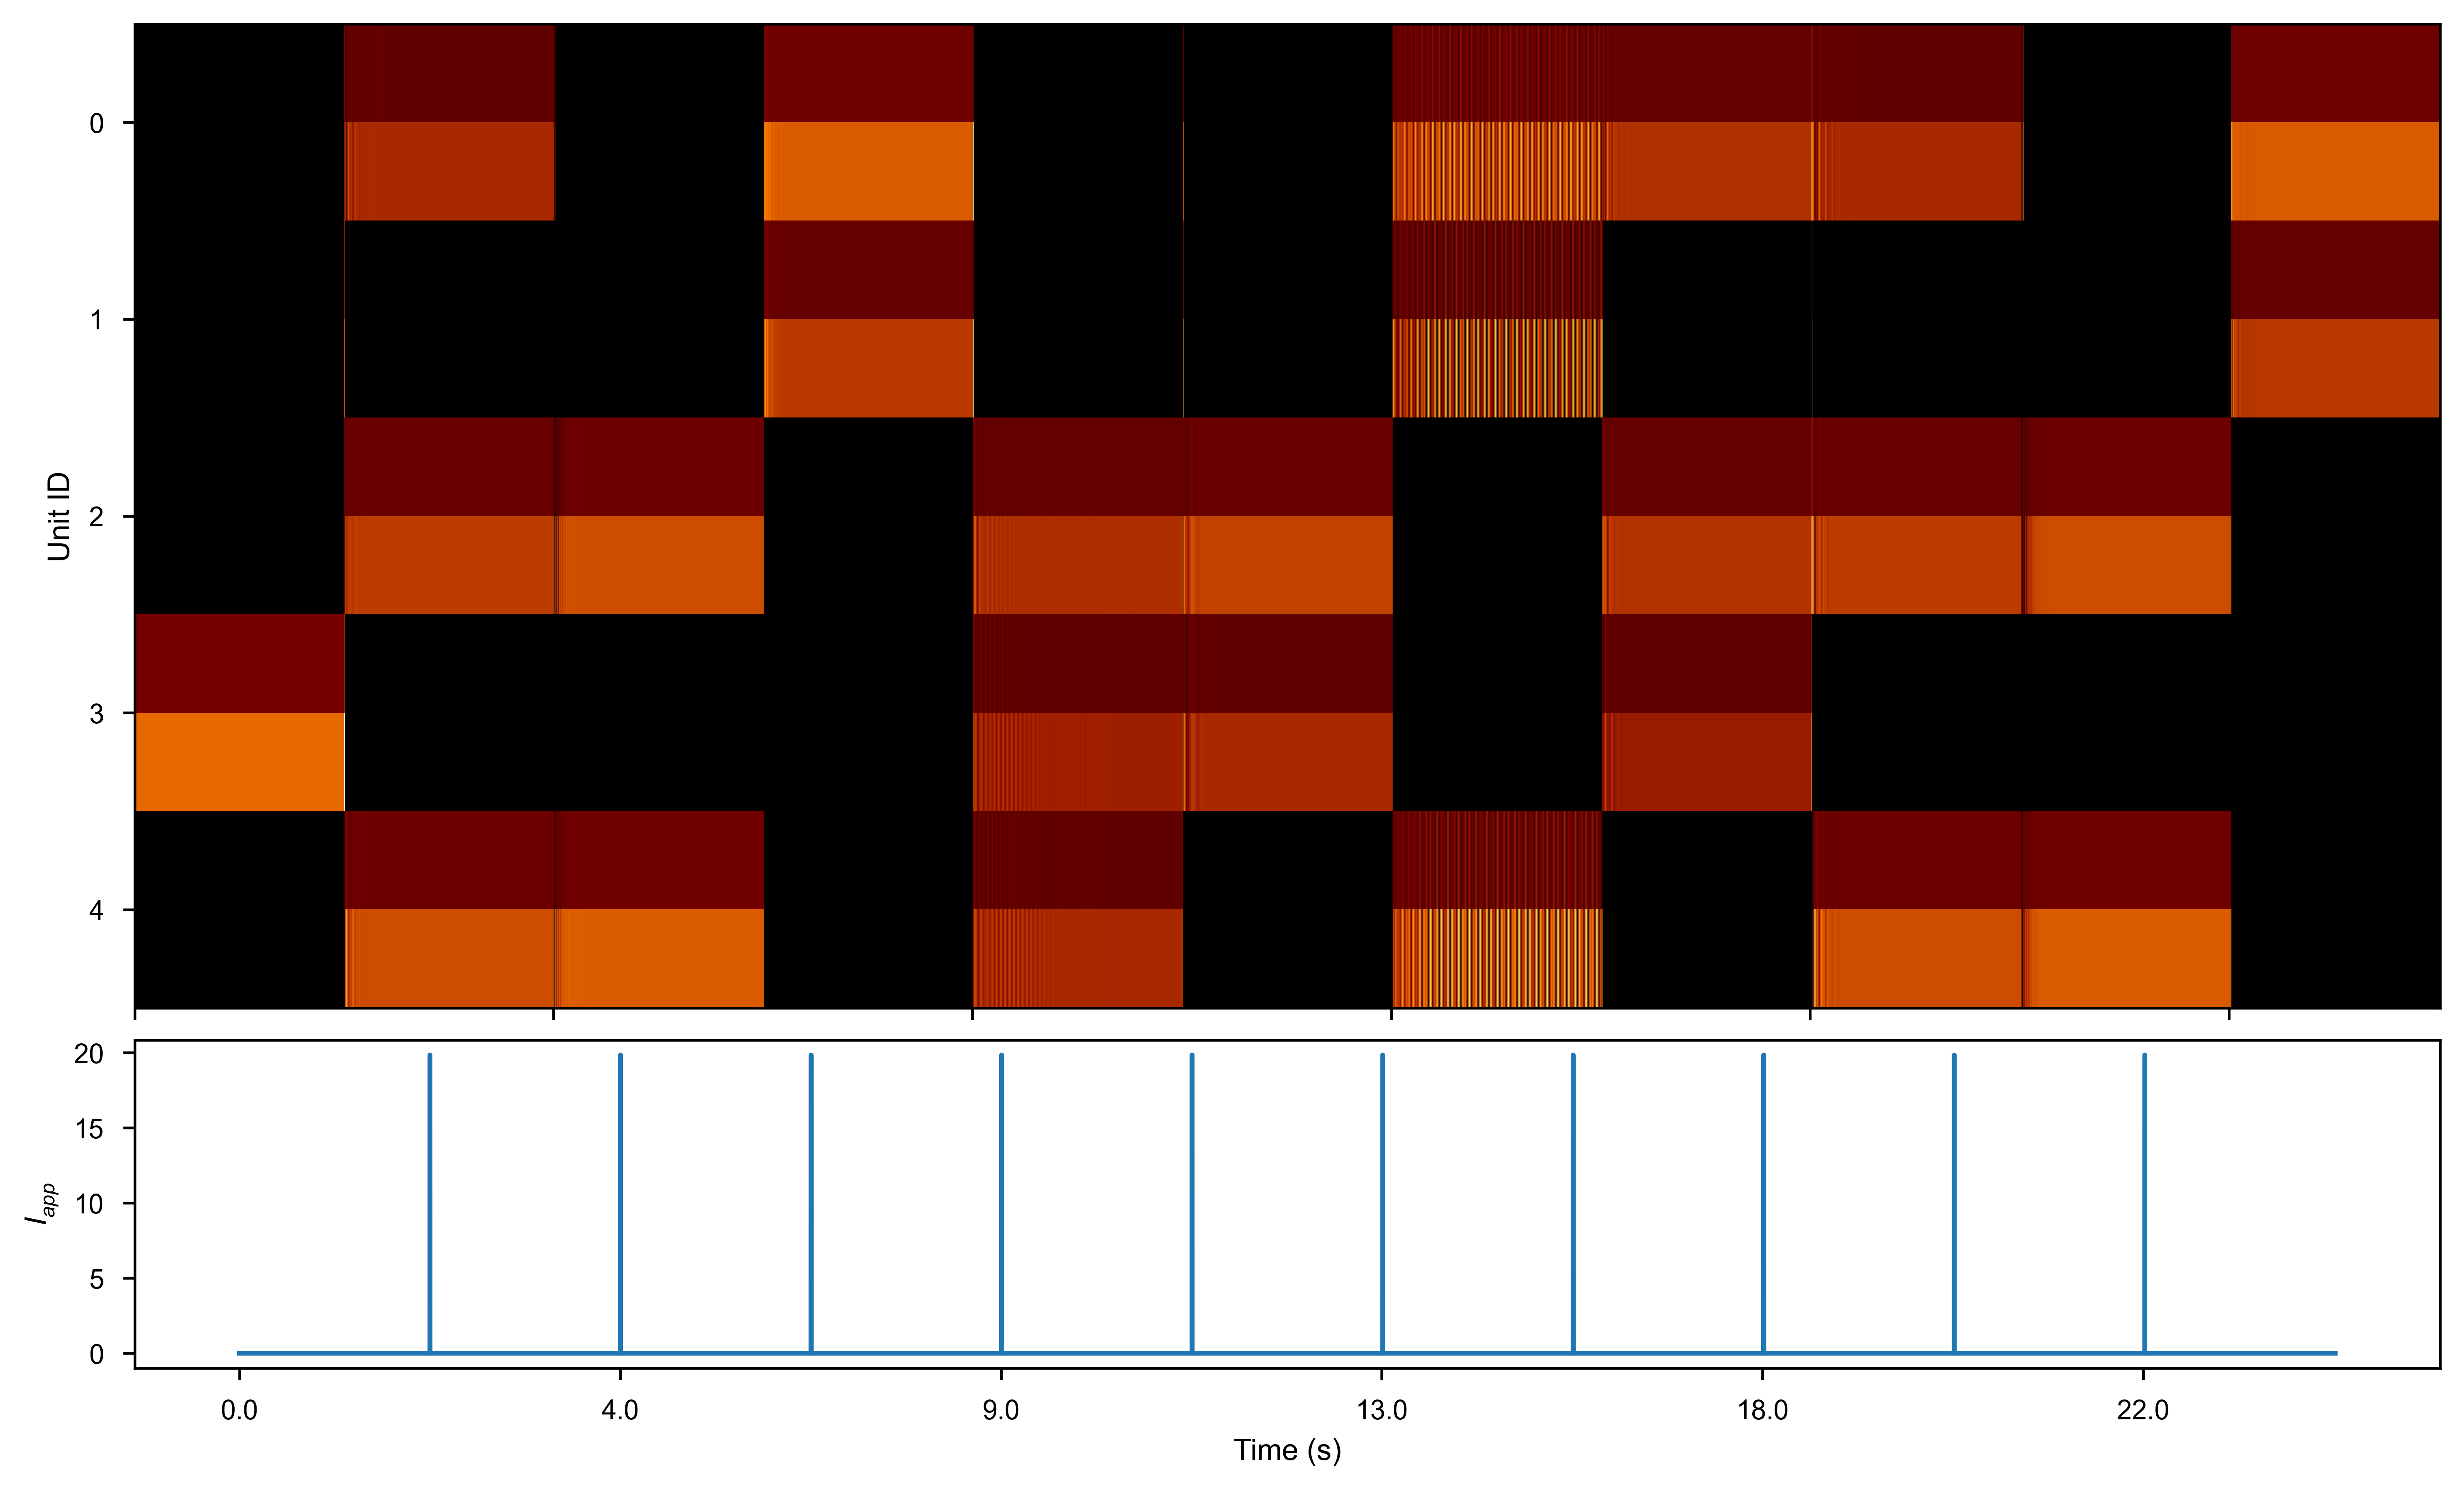

State 4


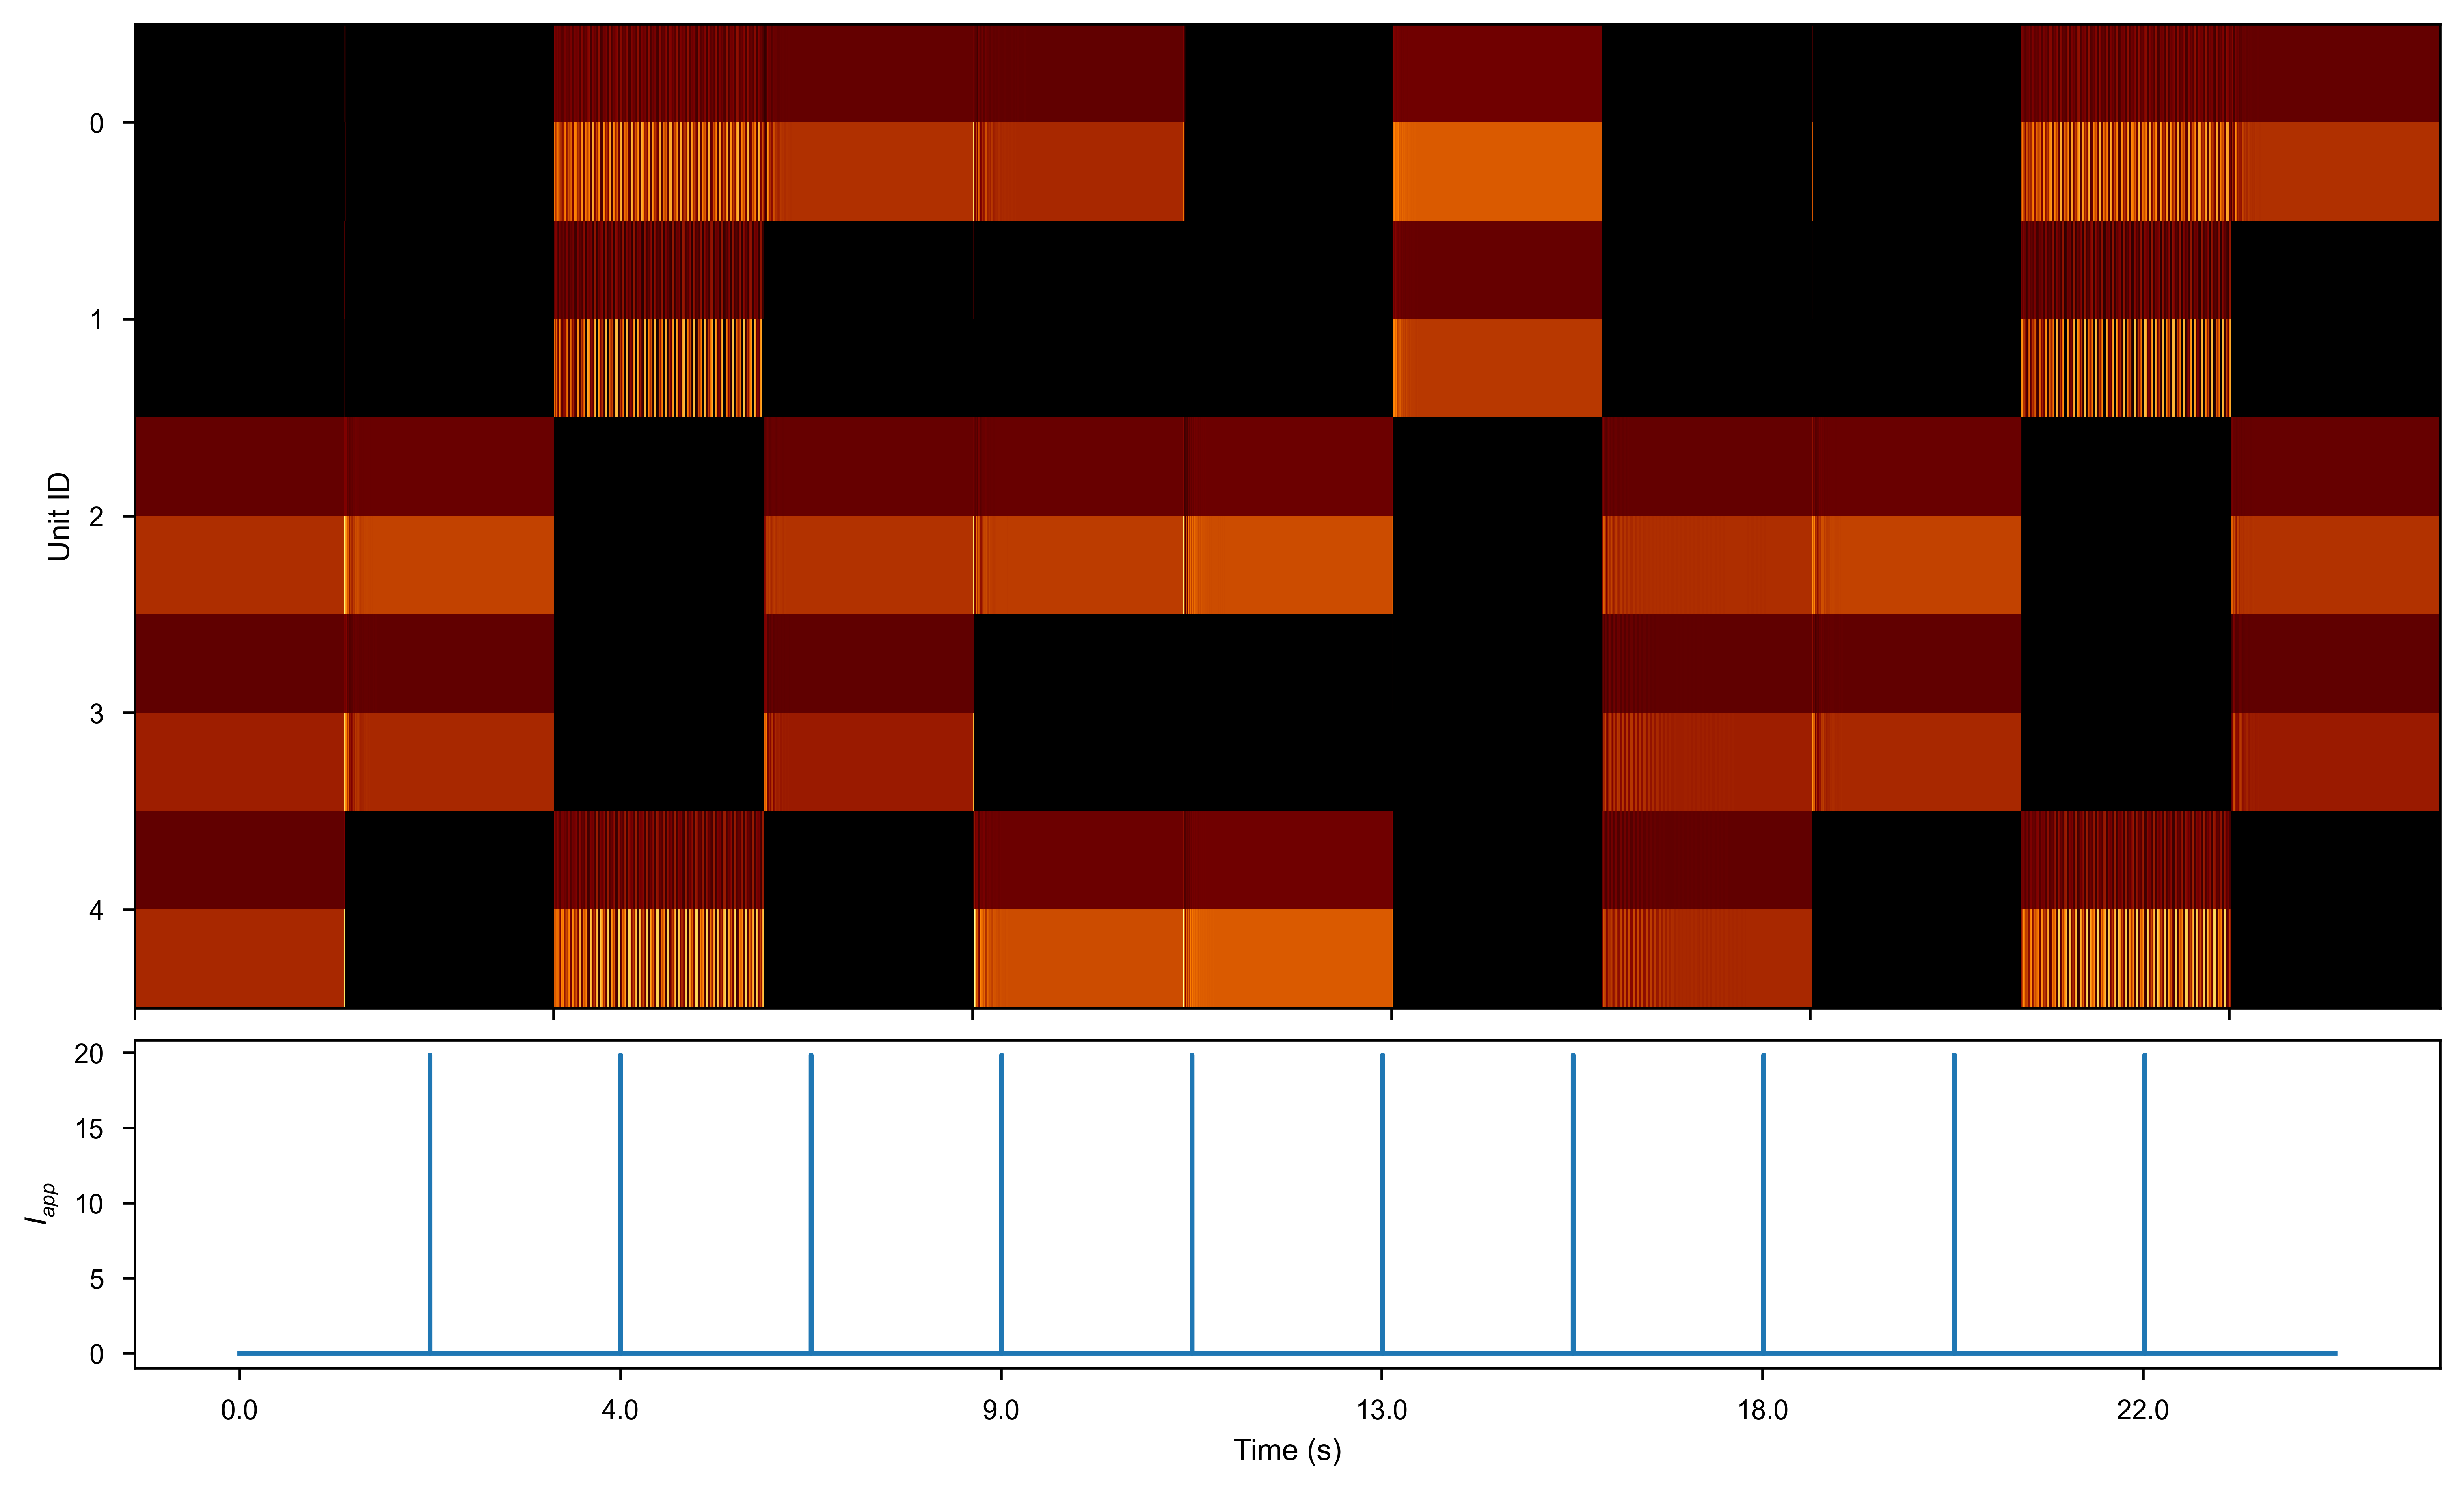

State 5


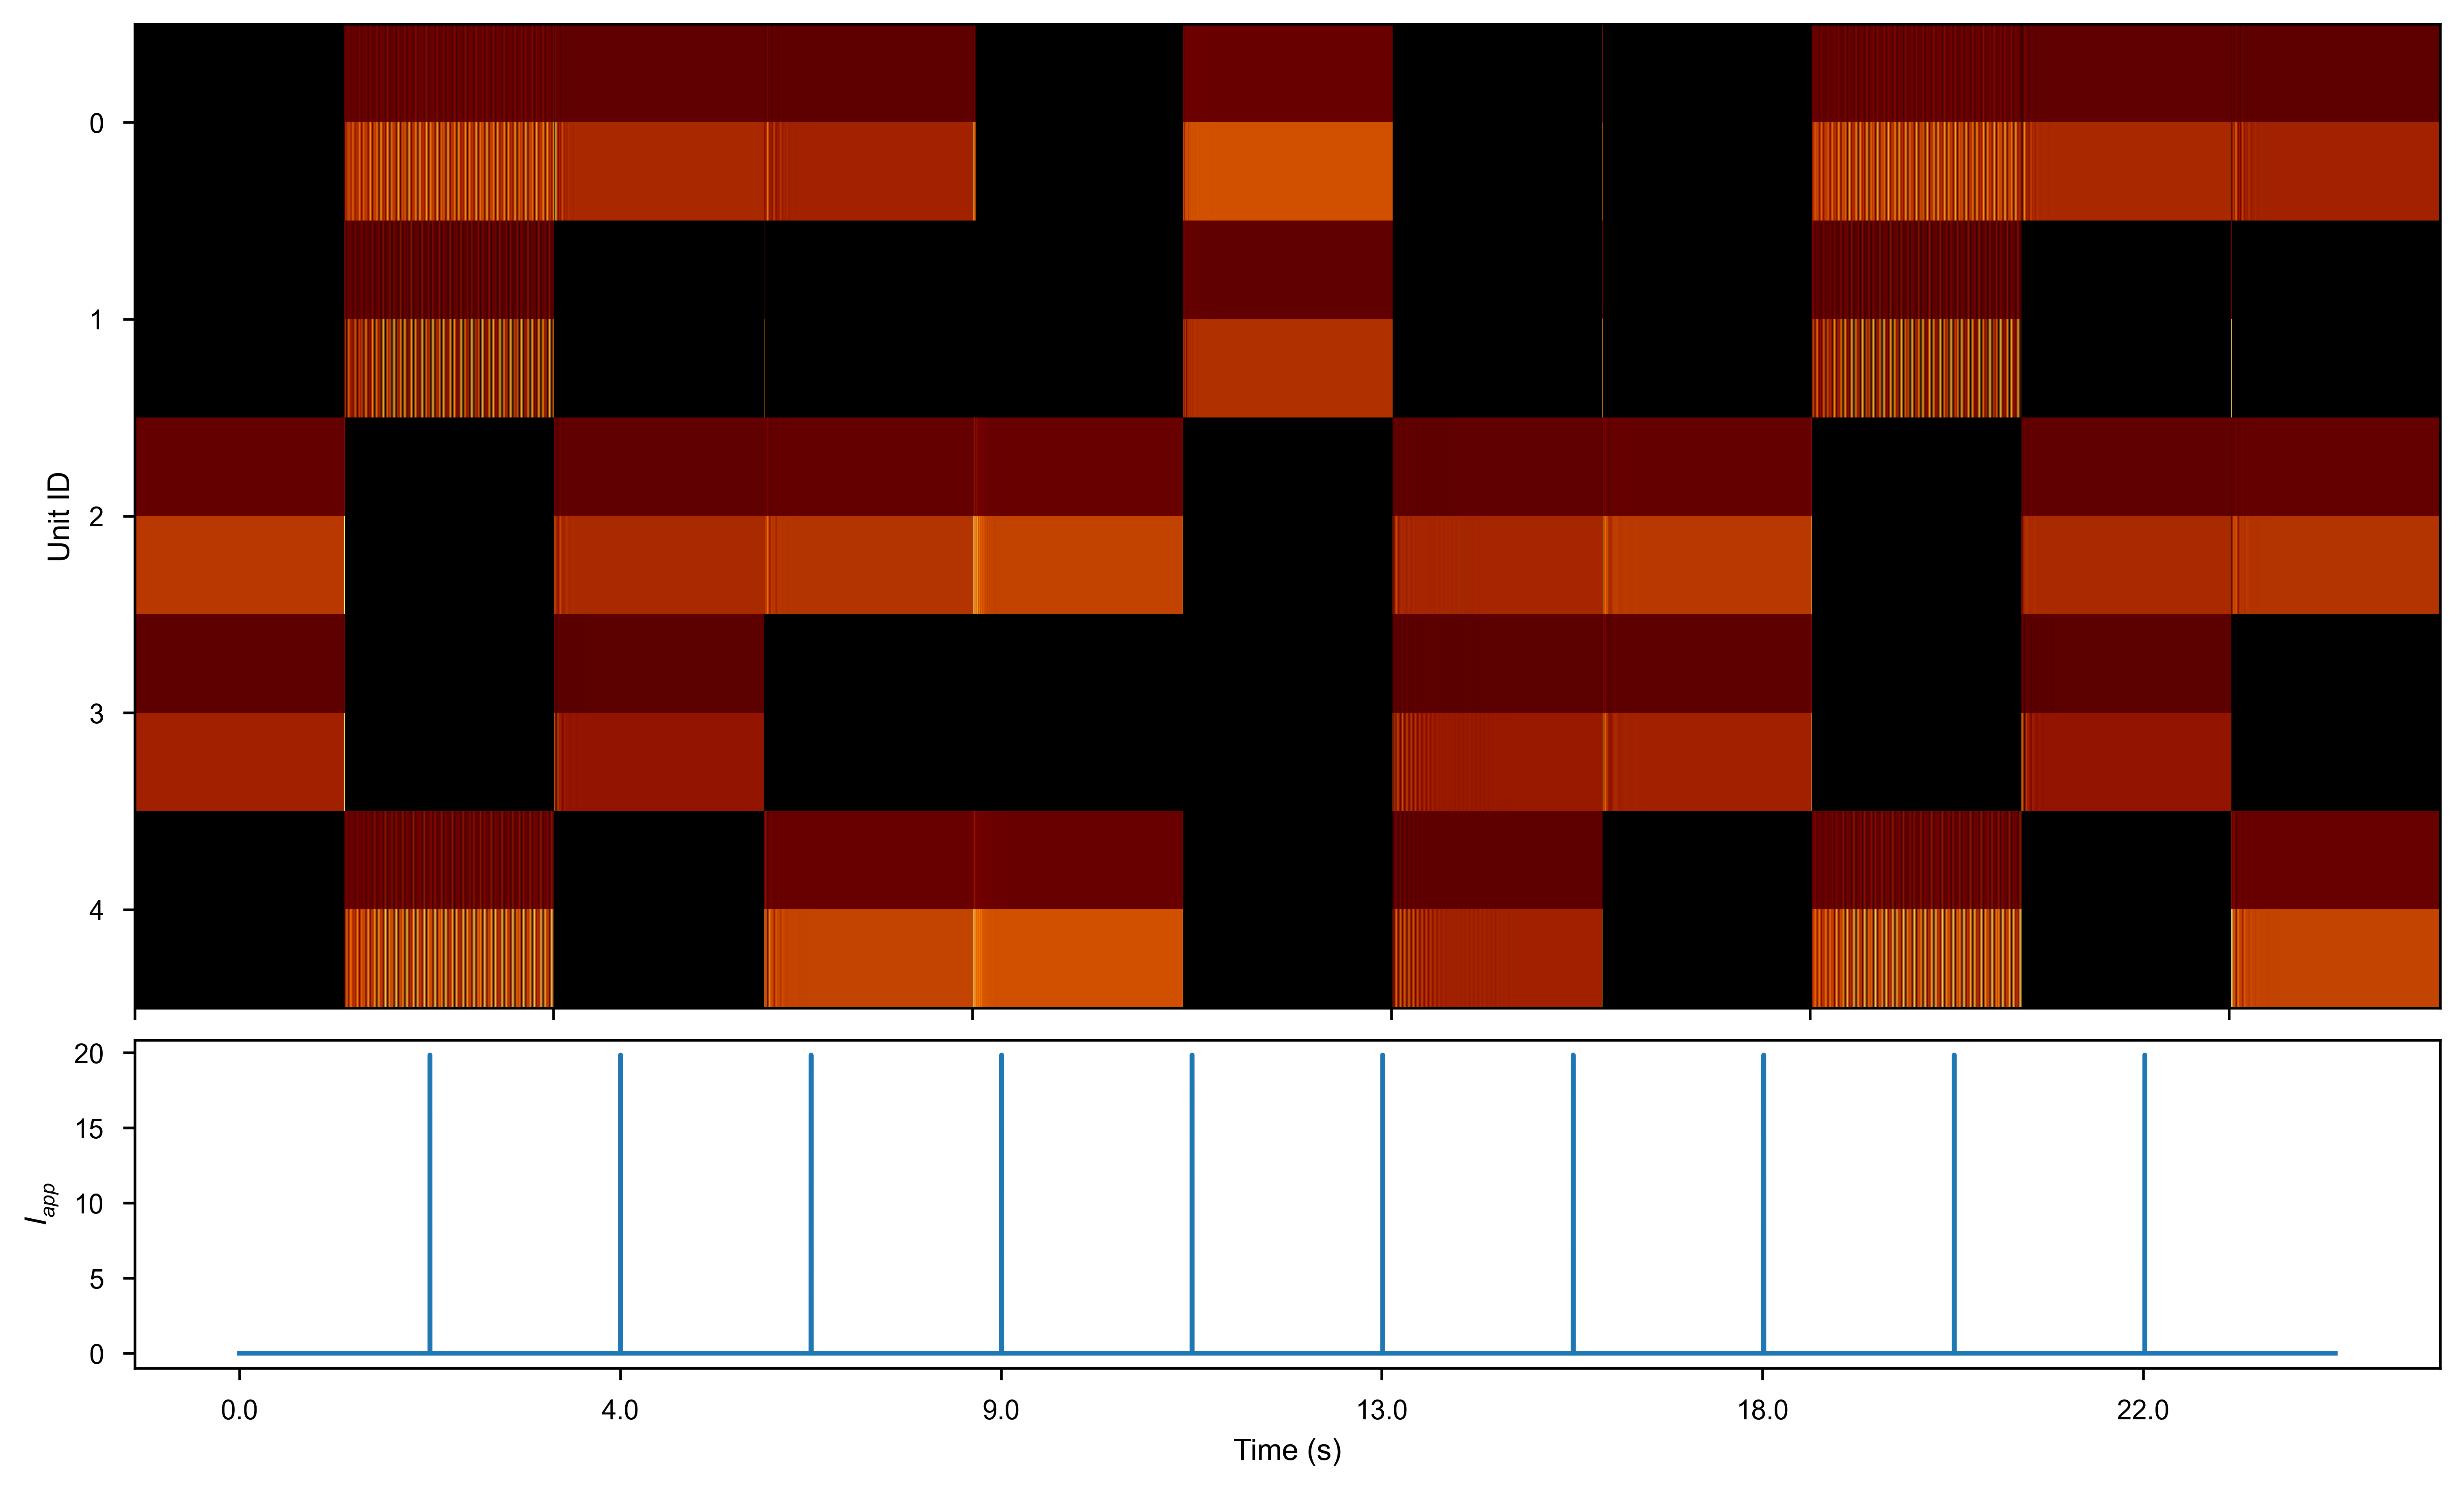

State 6


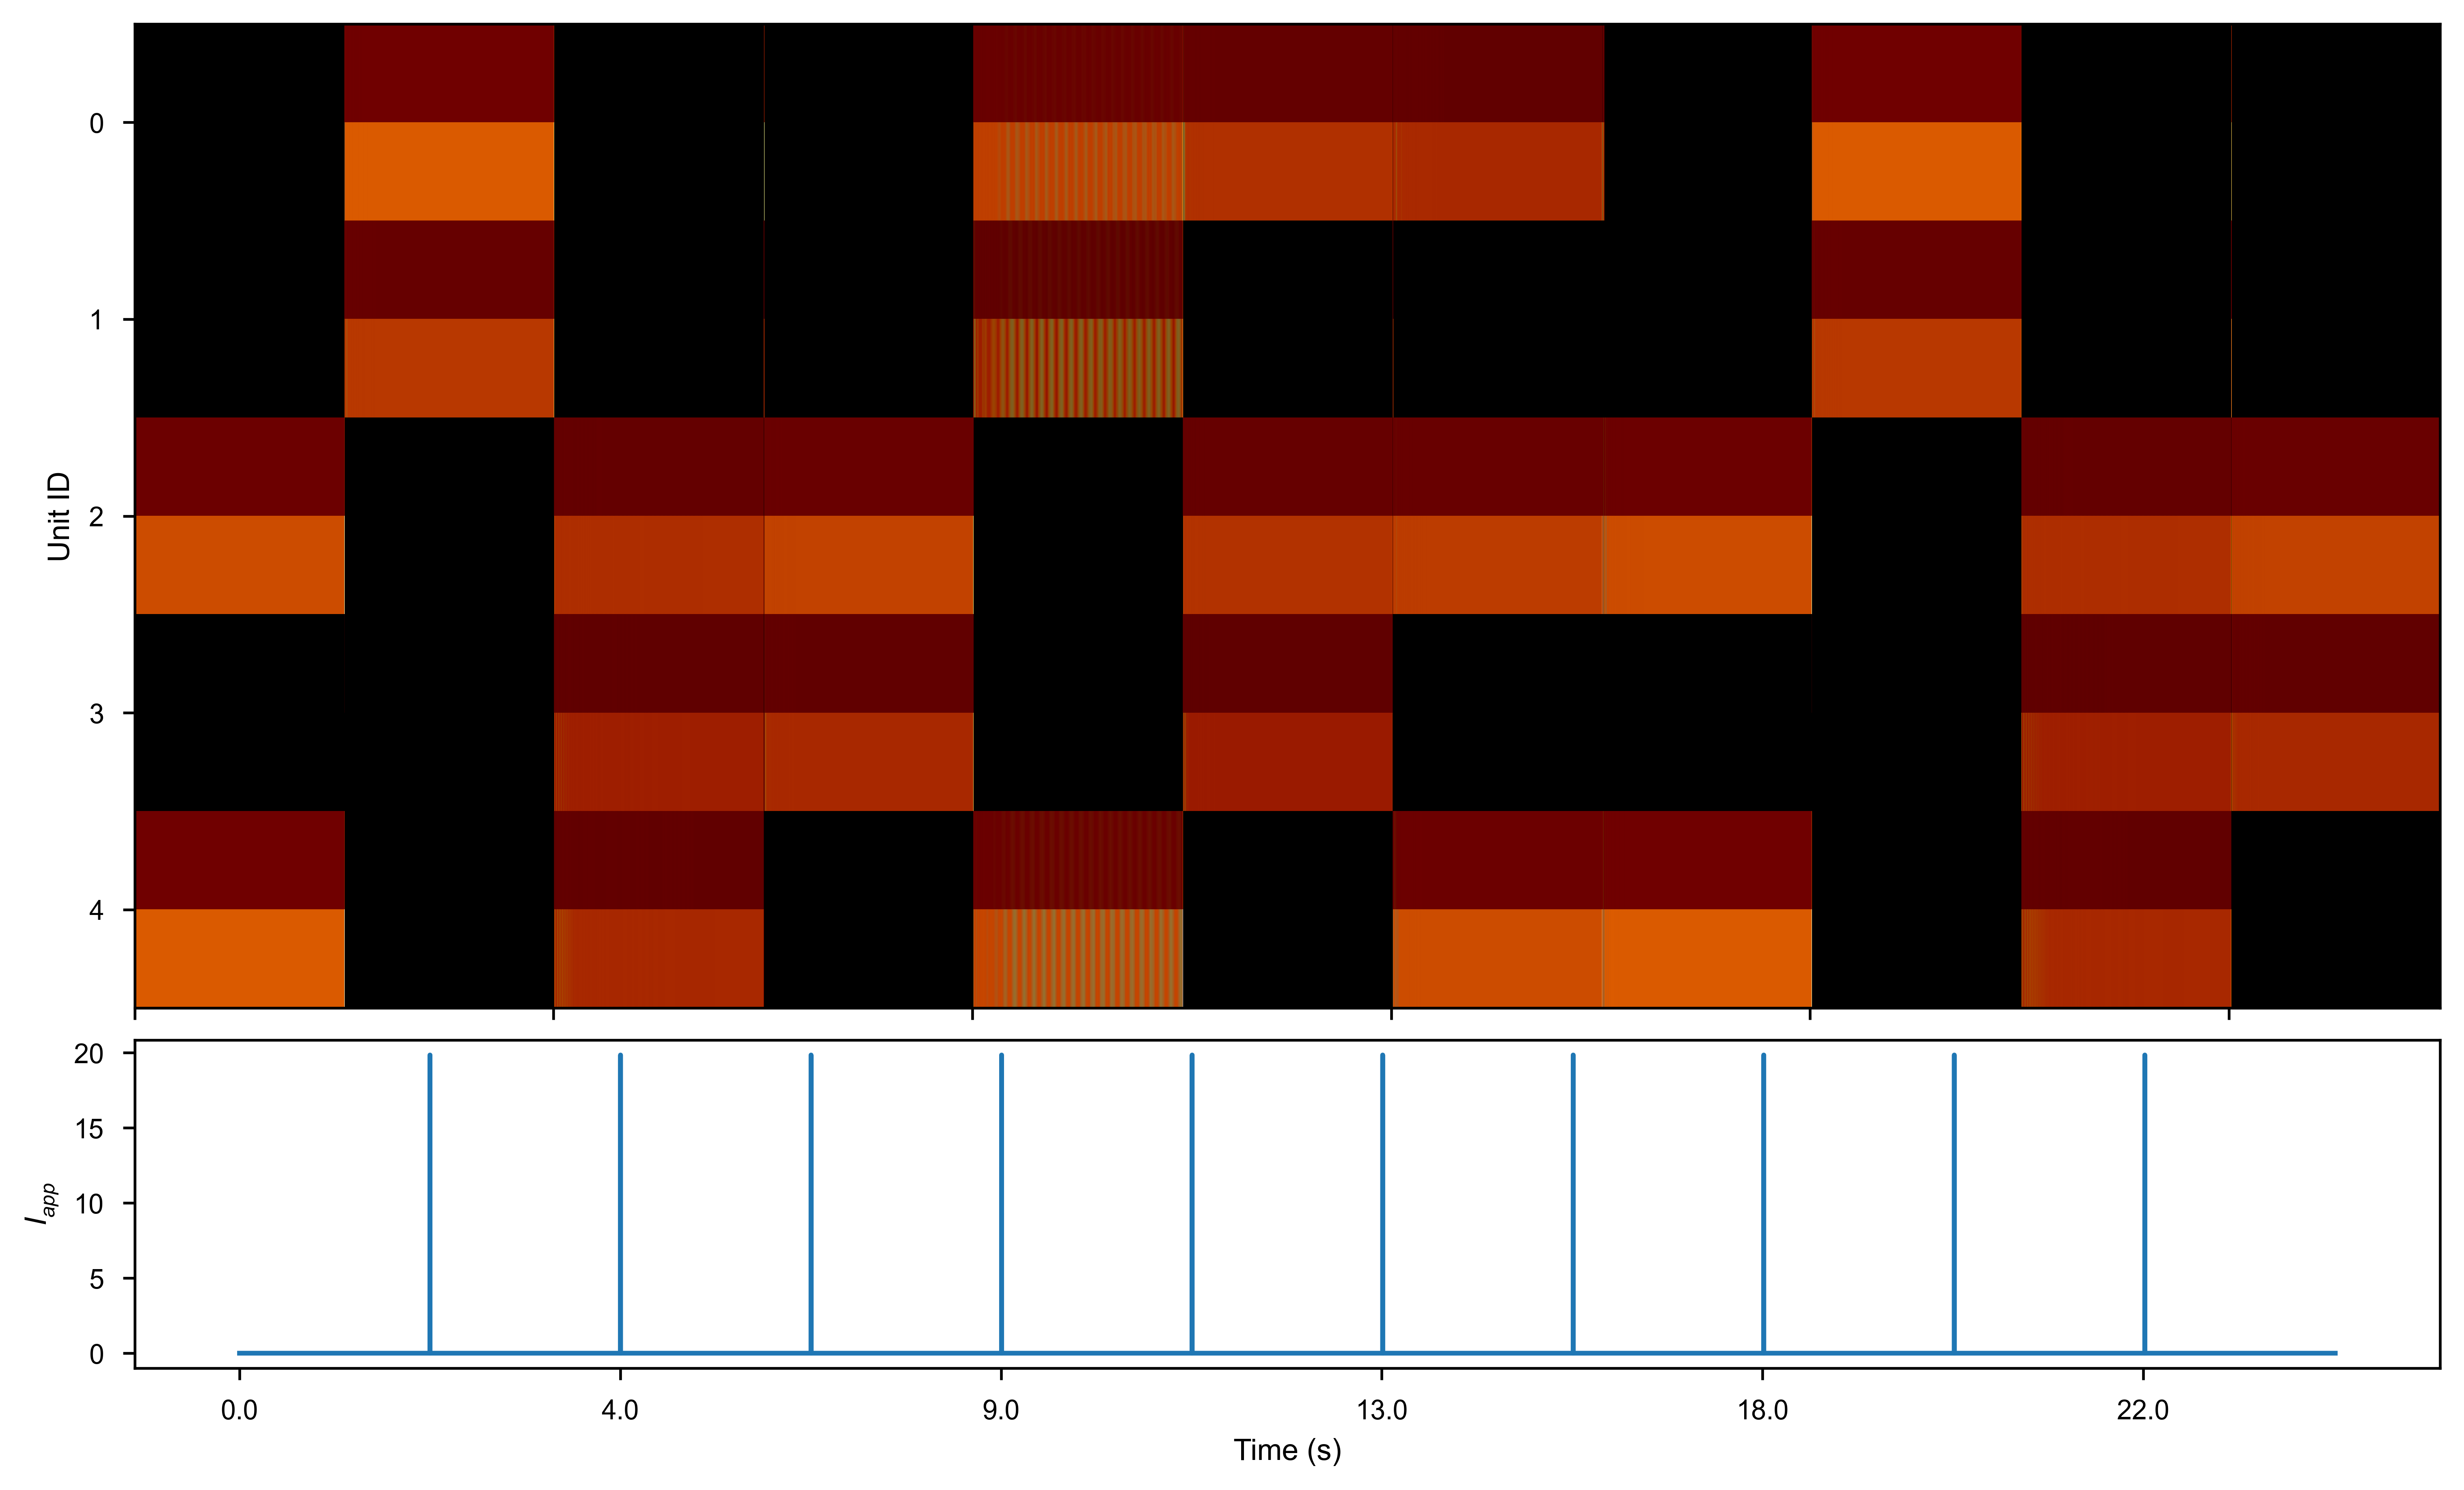

State 7


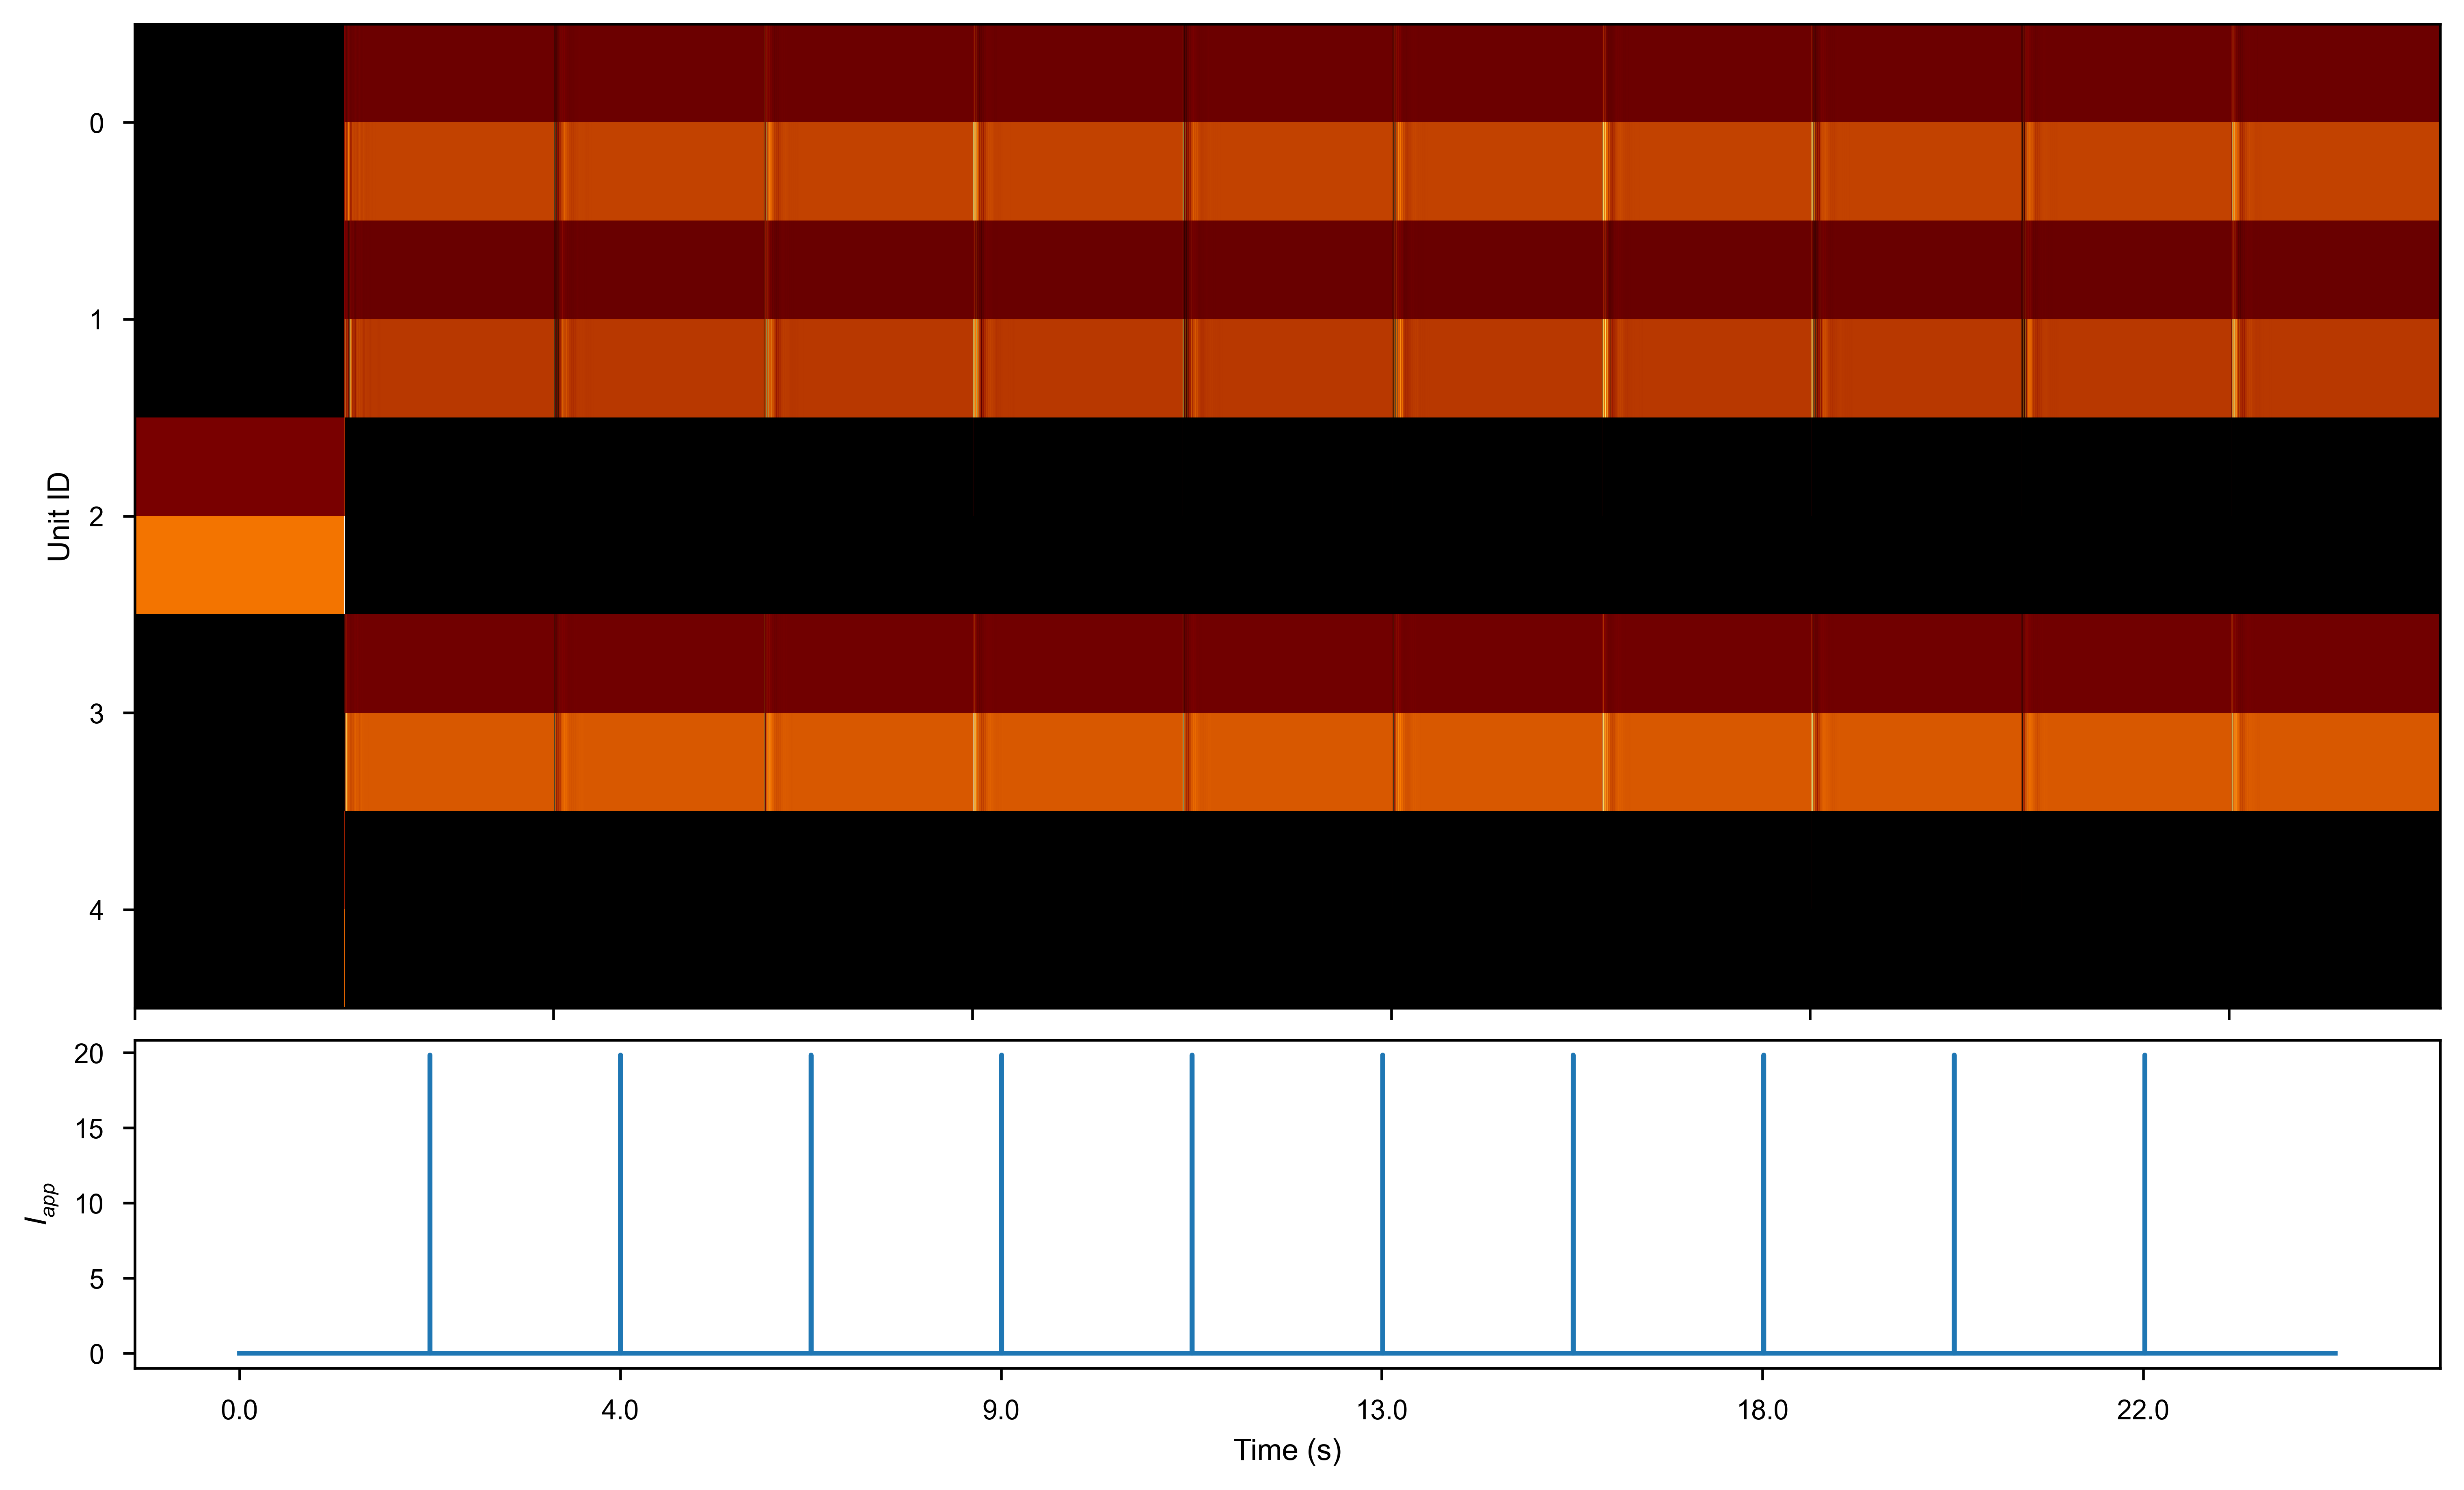

State 8


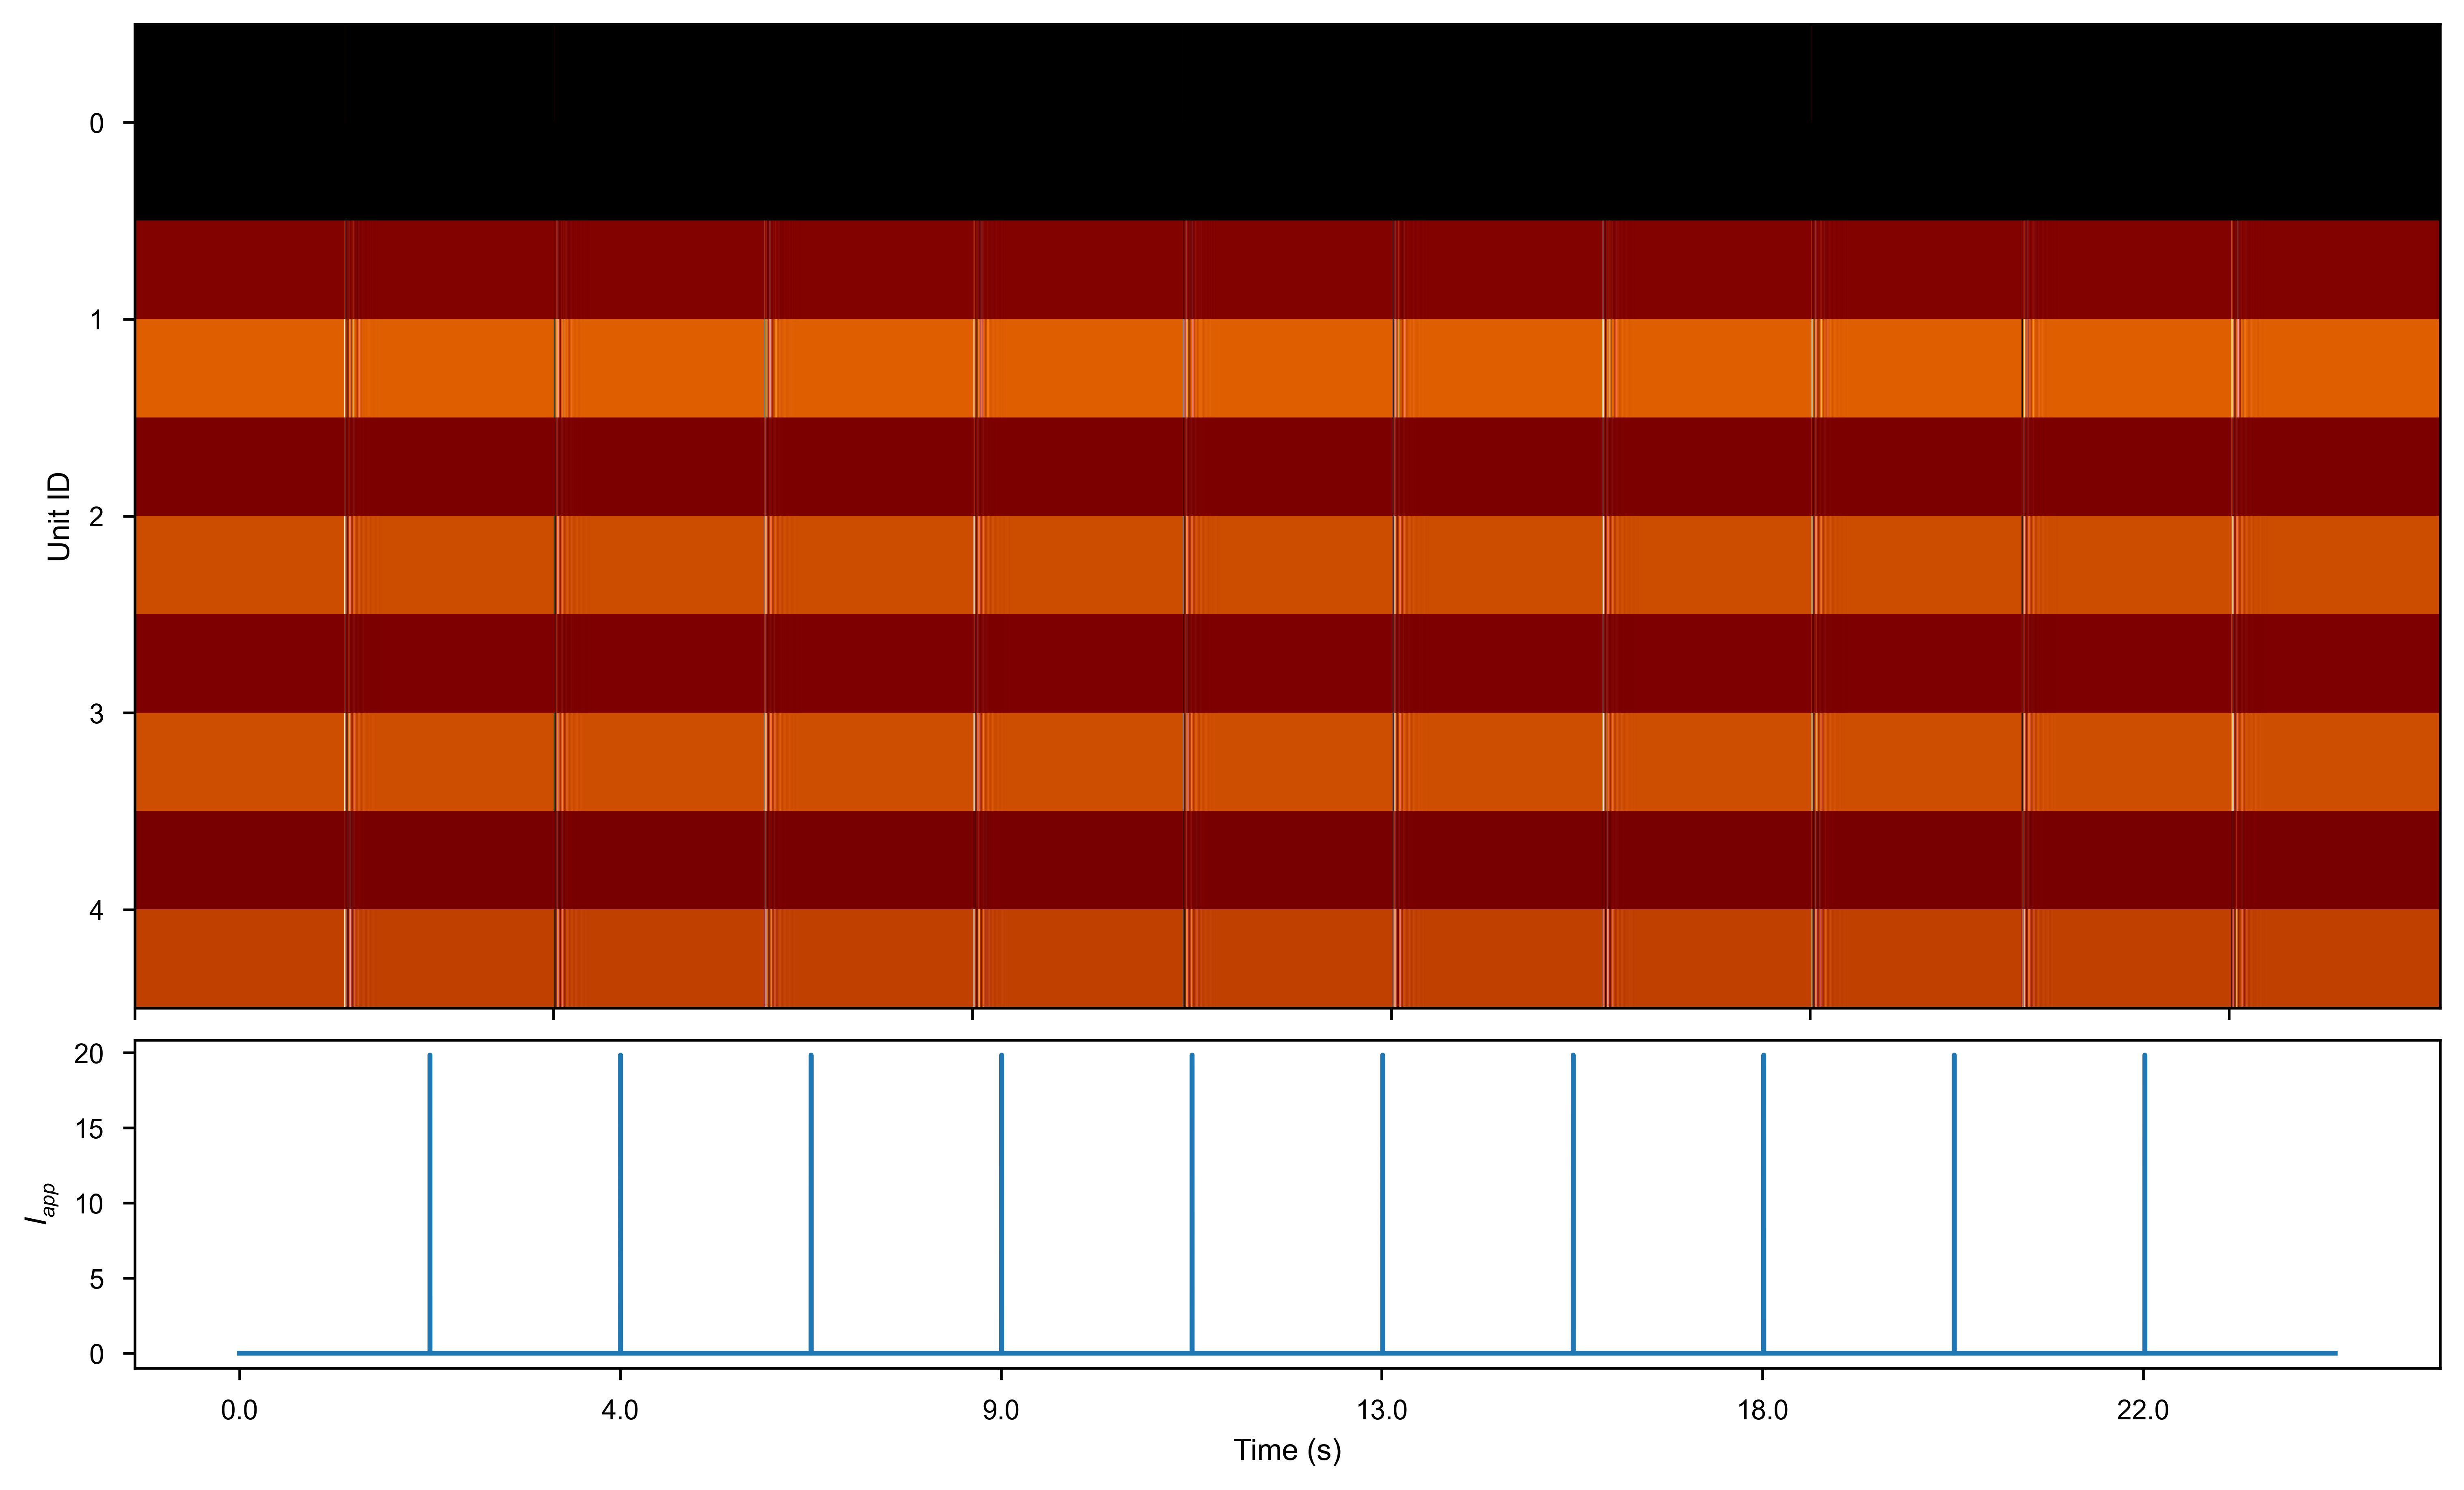

State 9


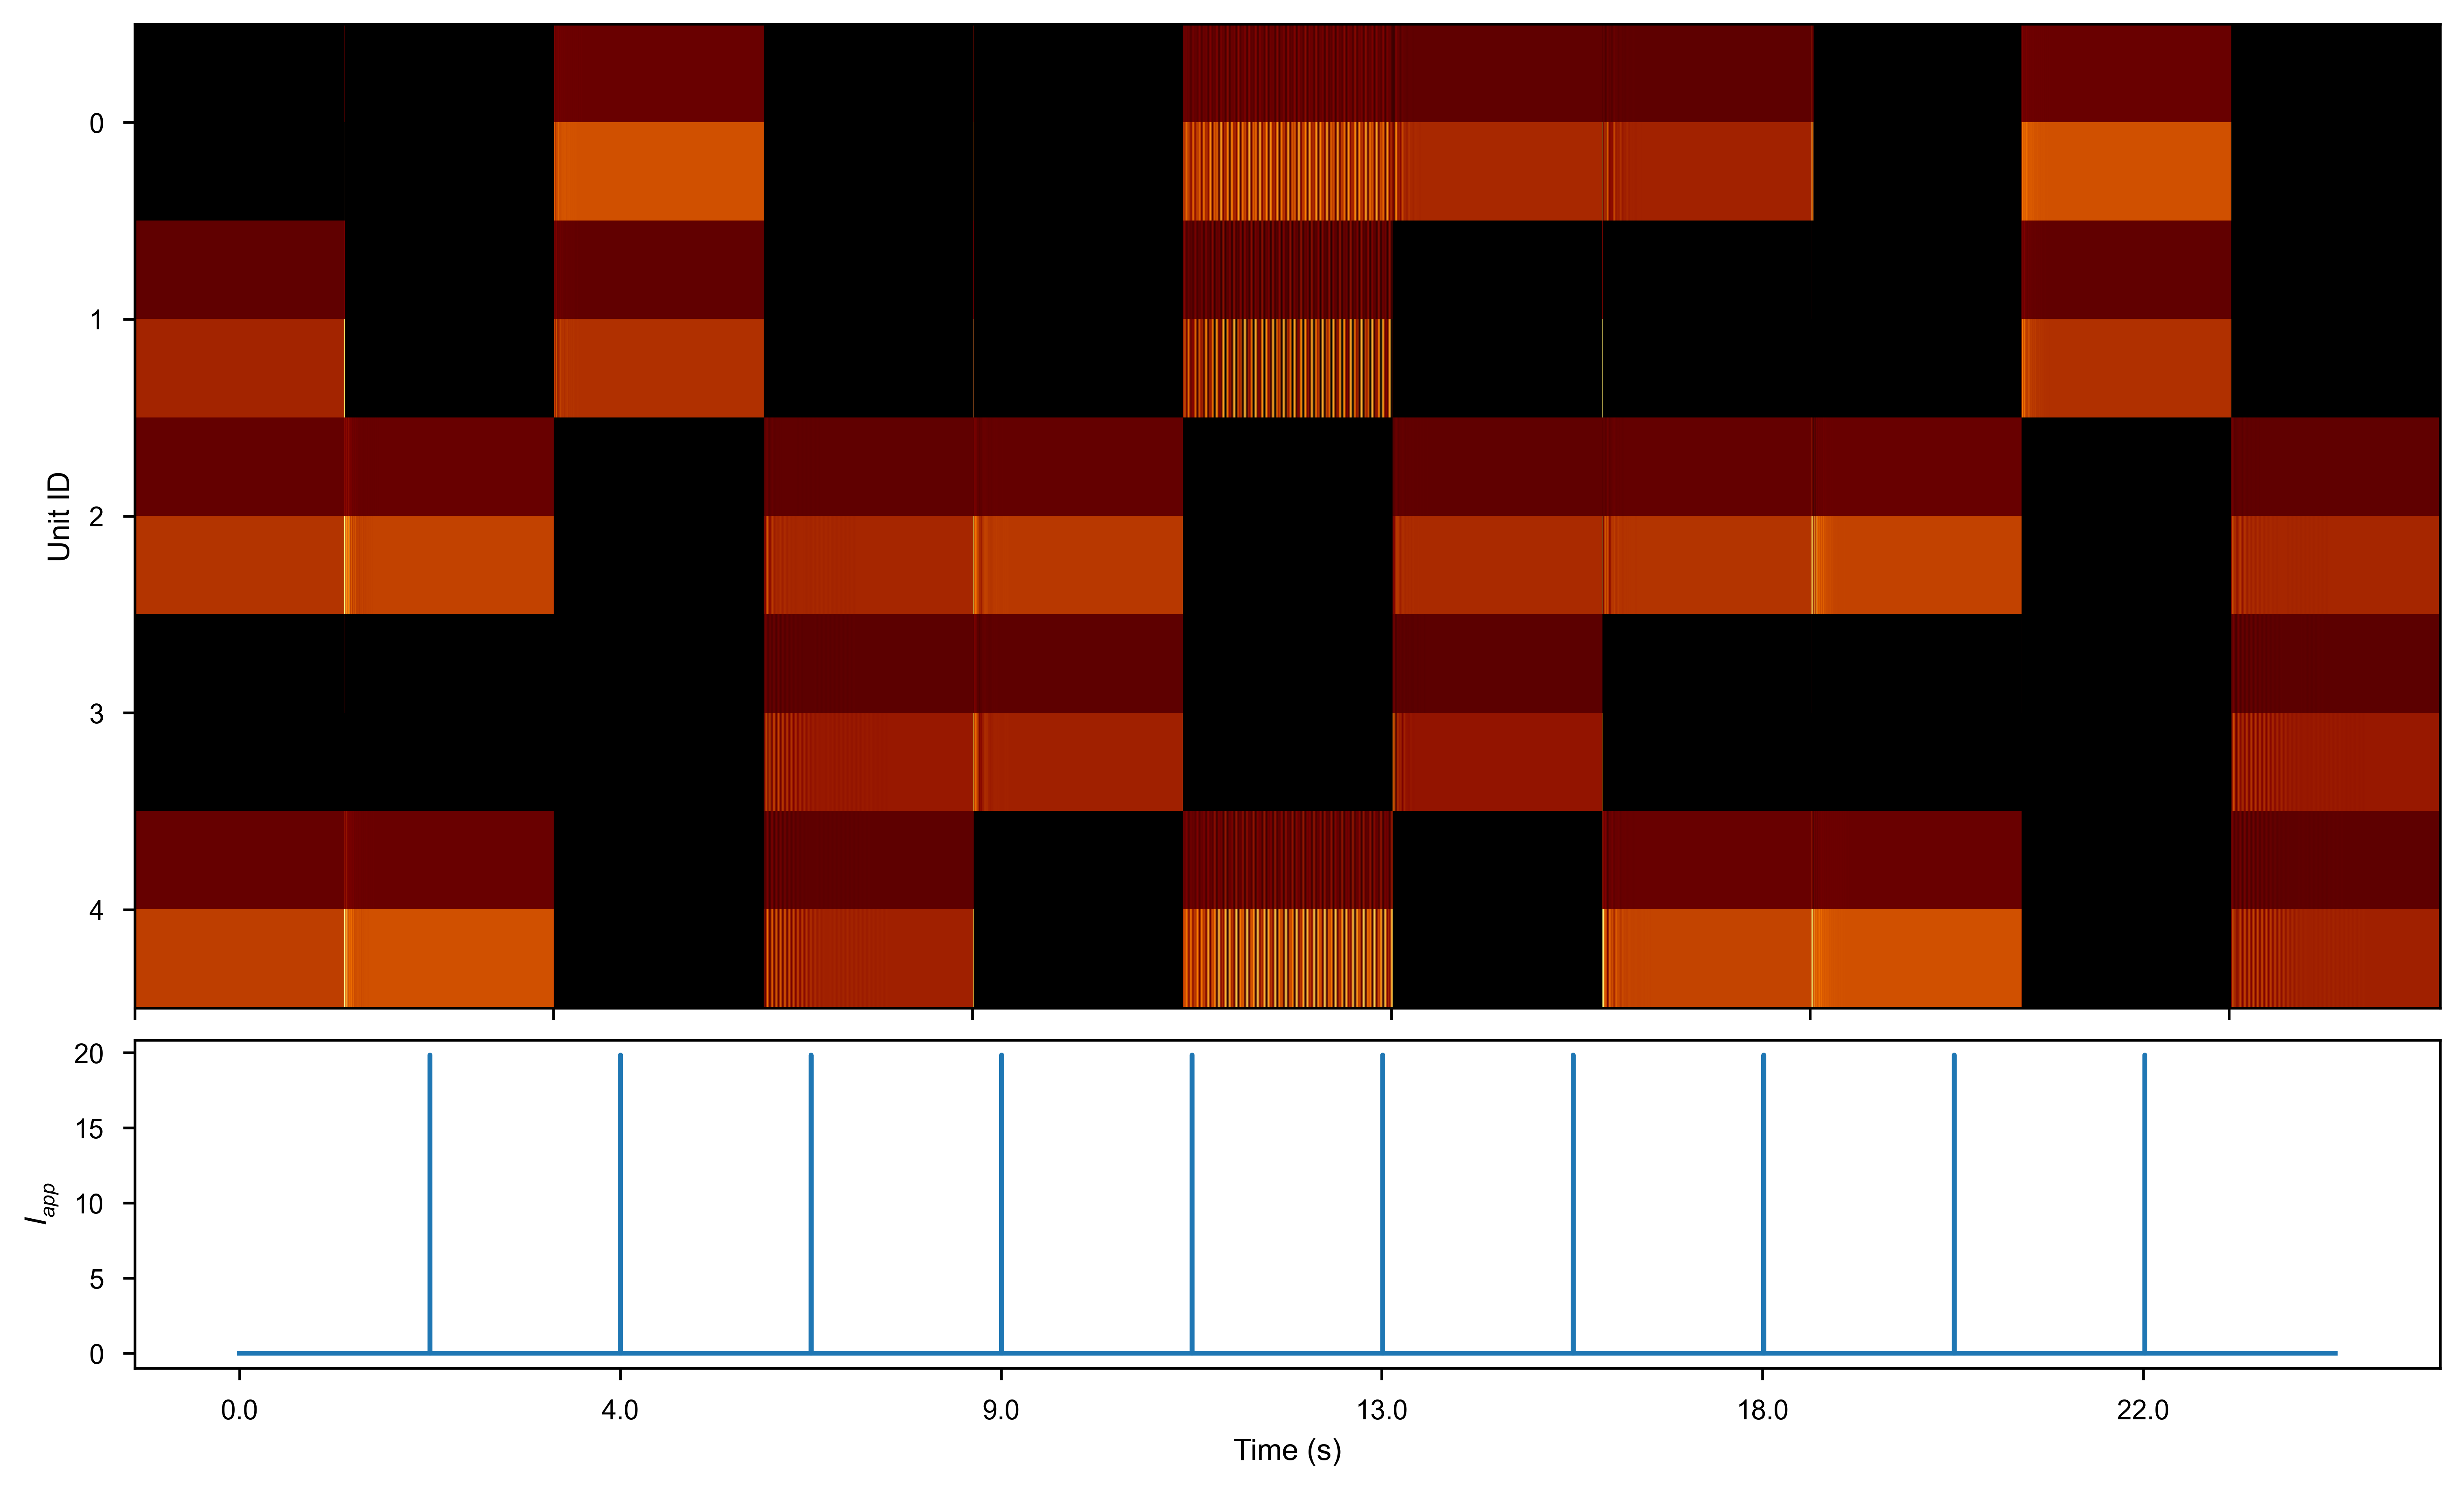

State 10


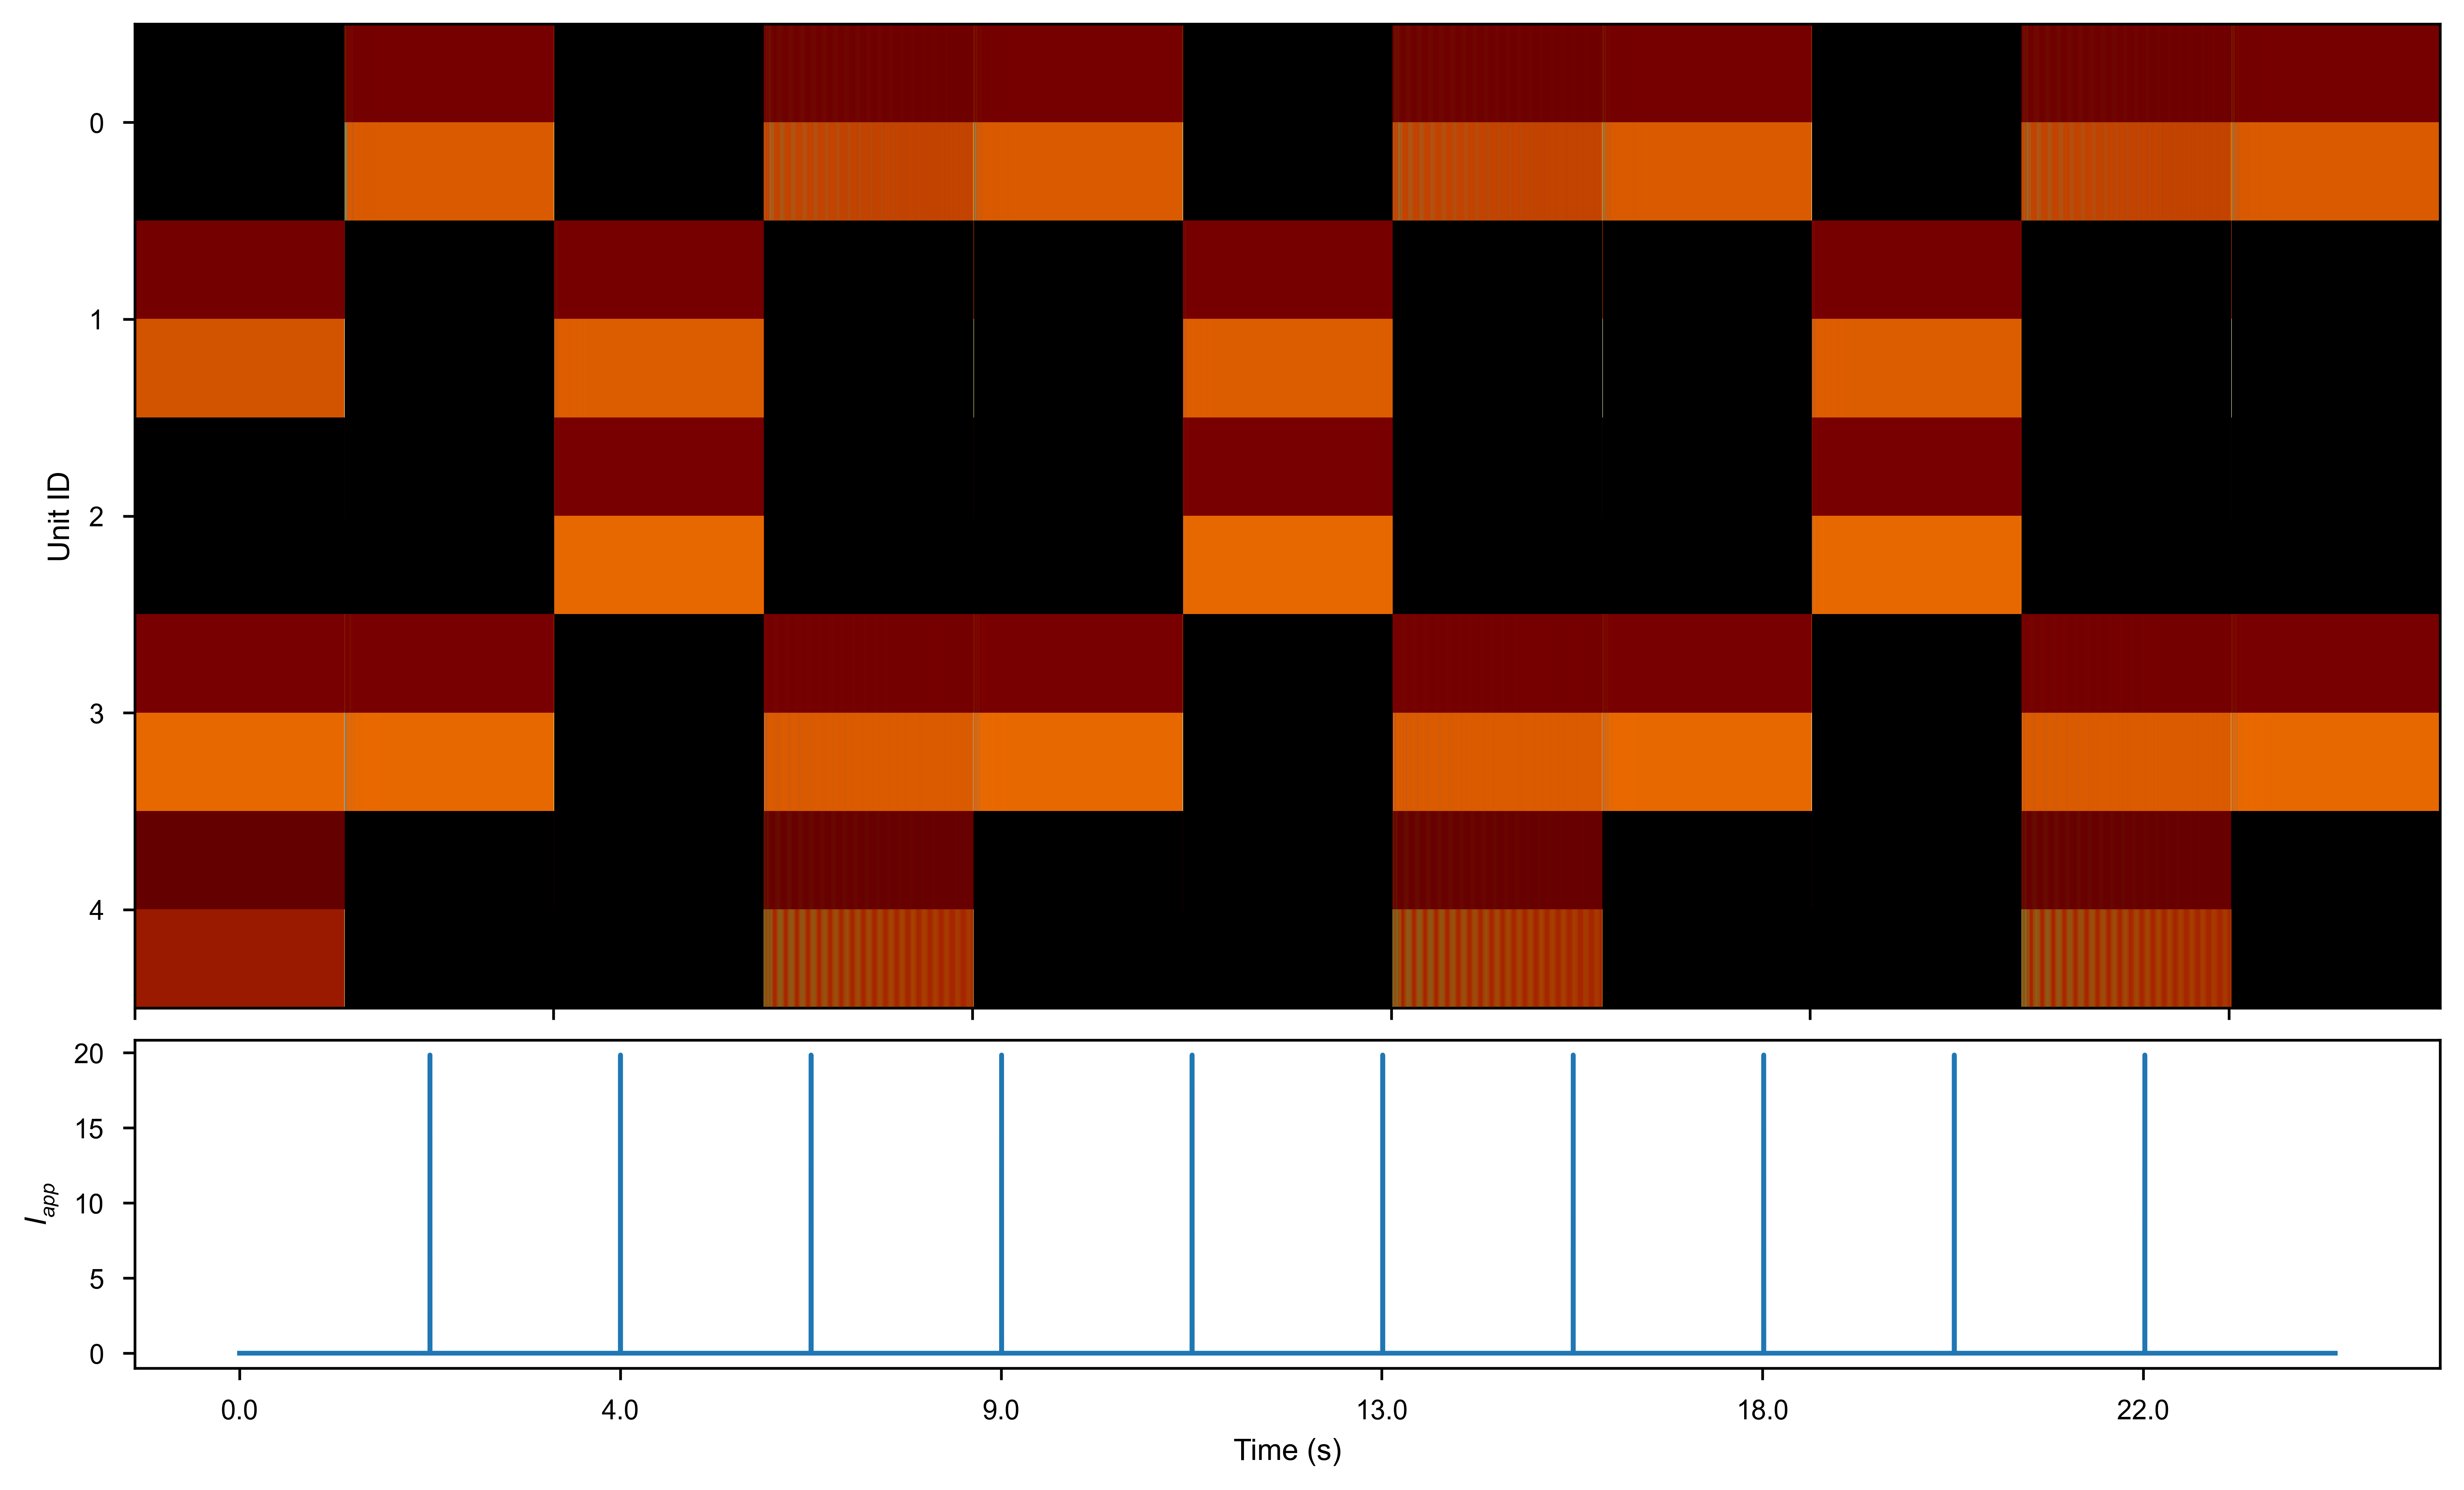

State 11


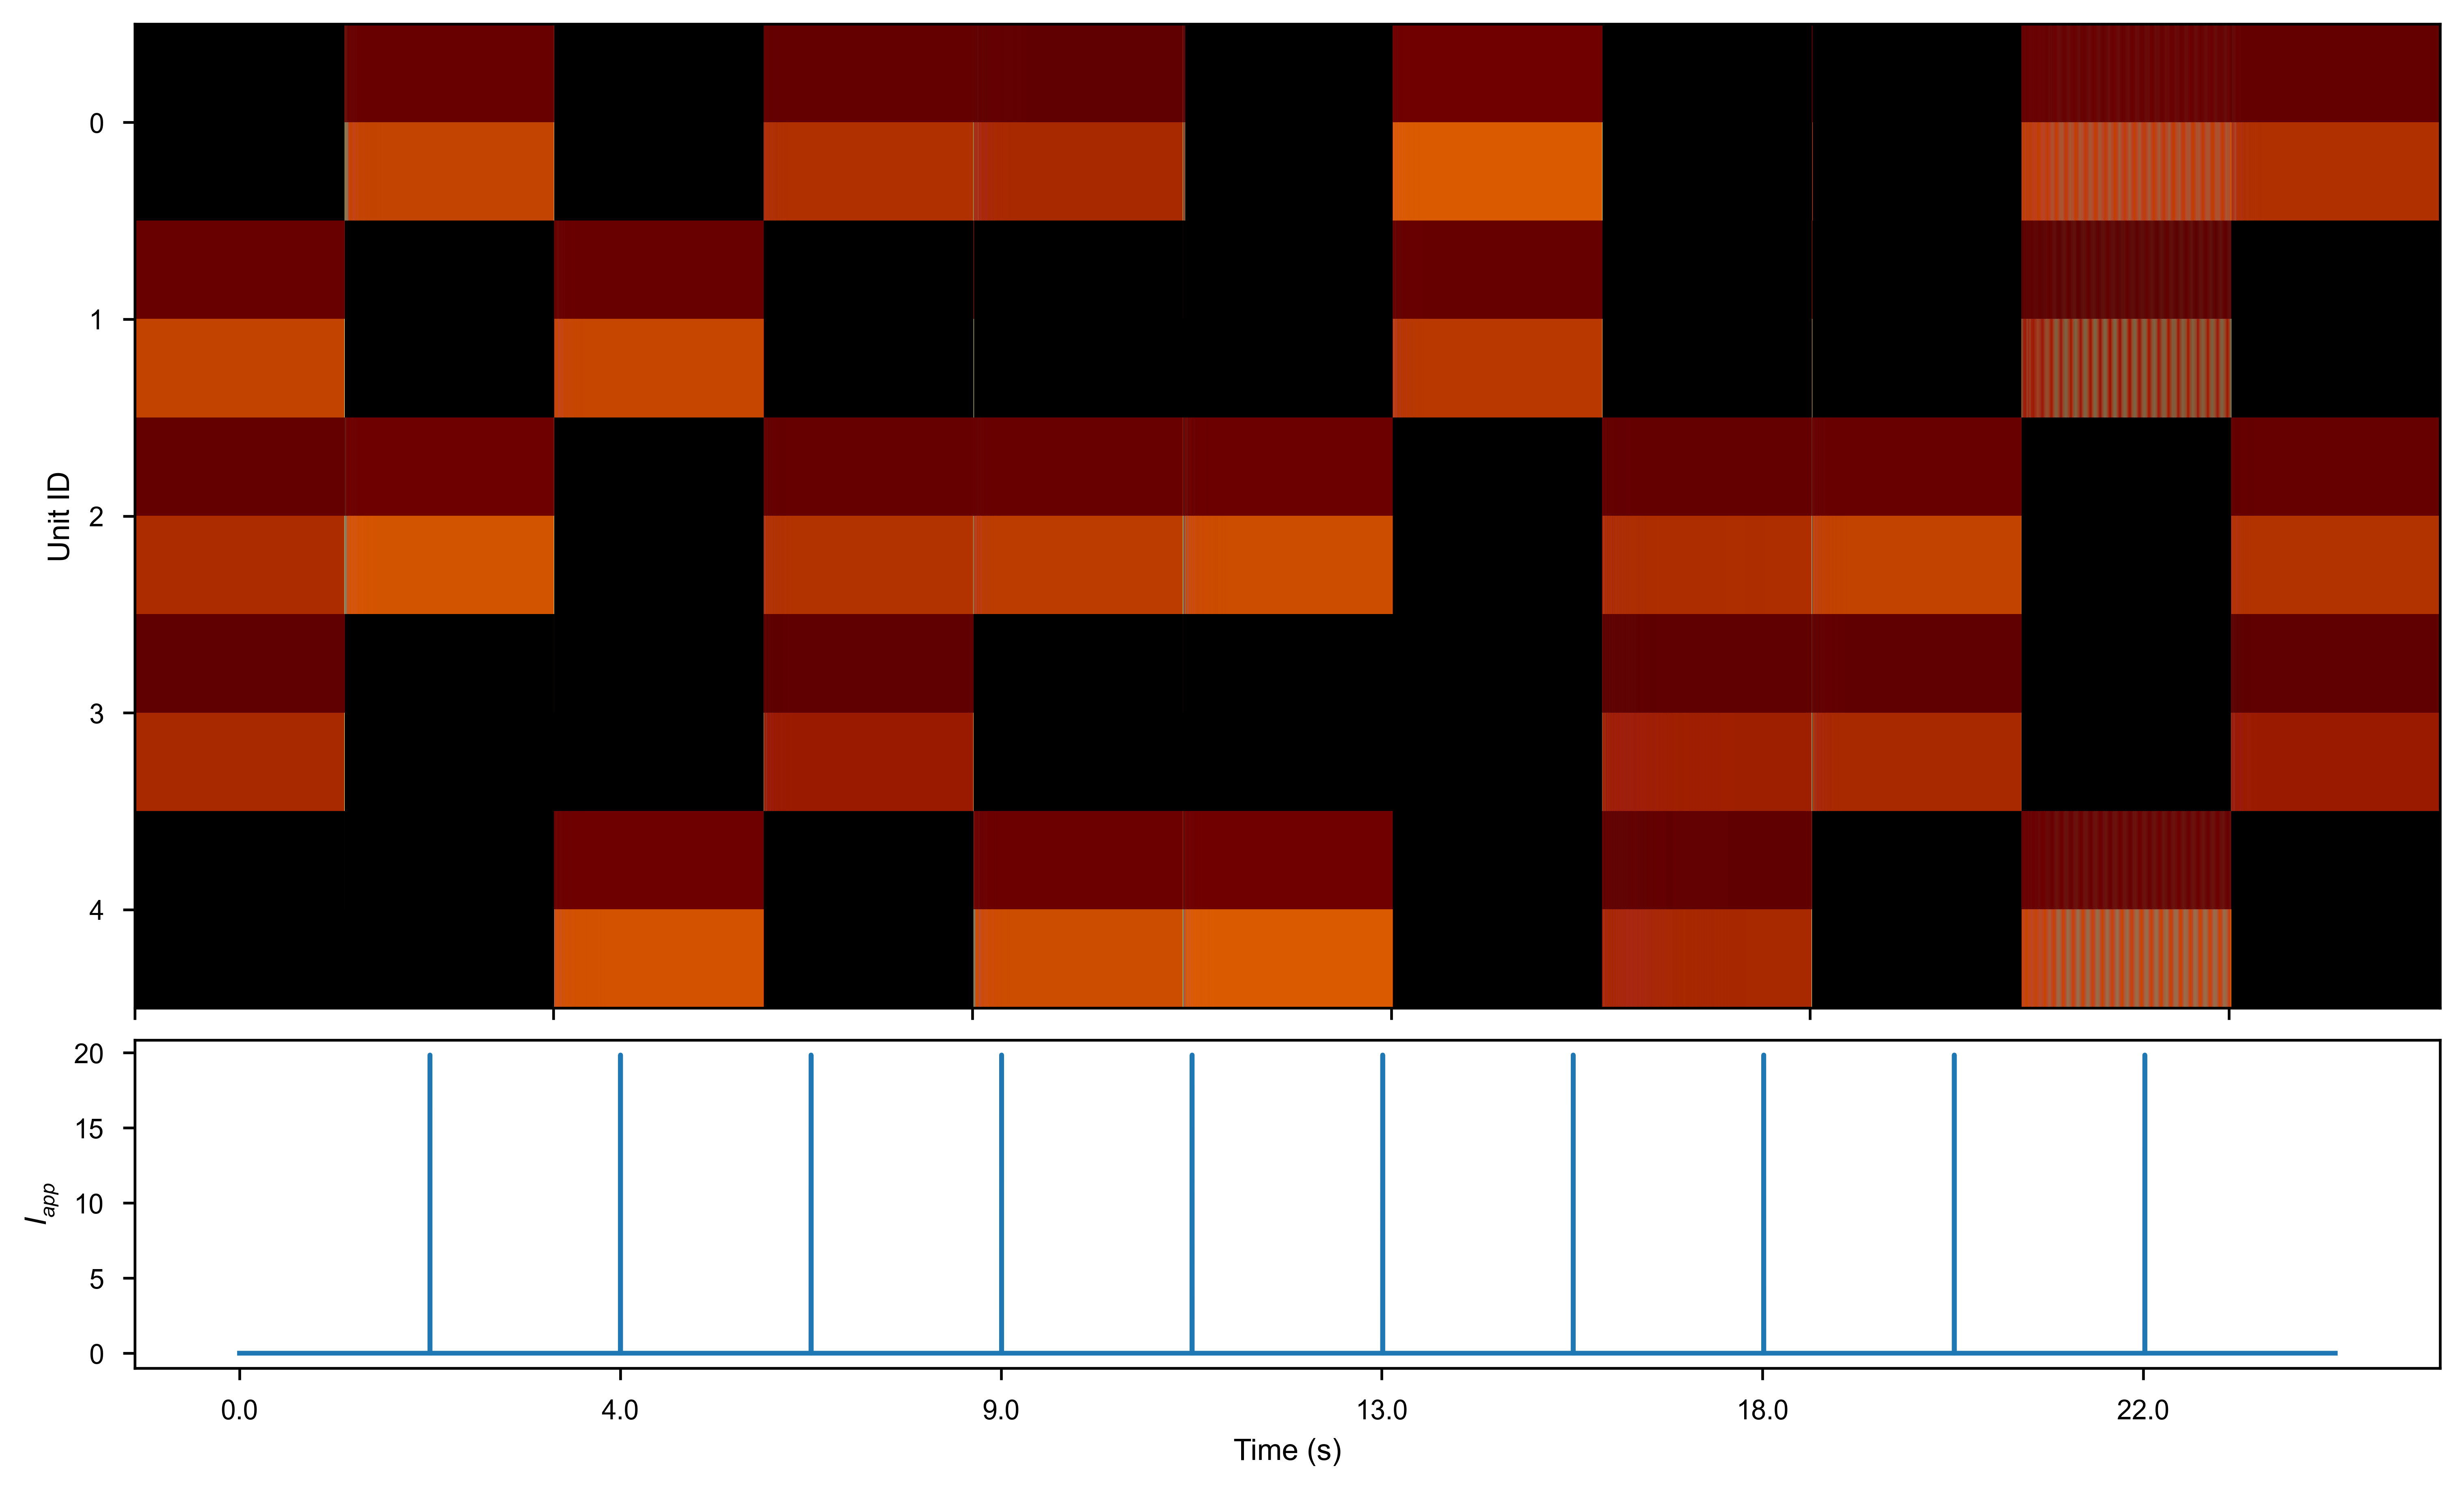

State 12


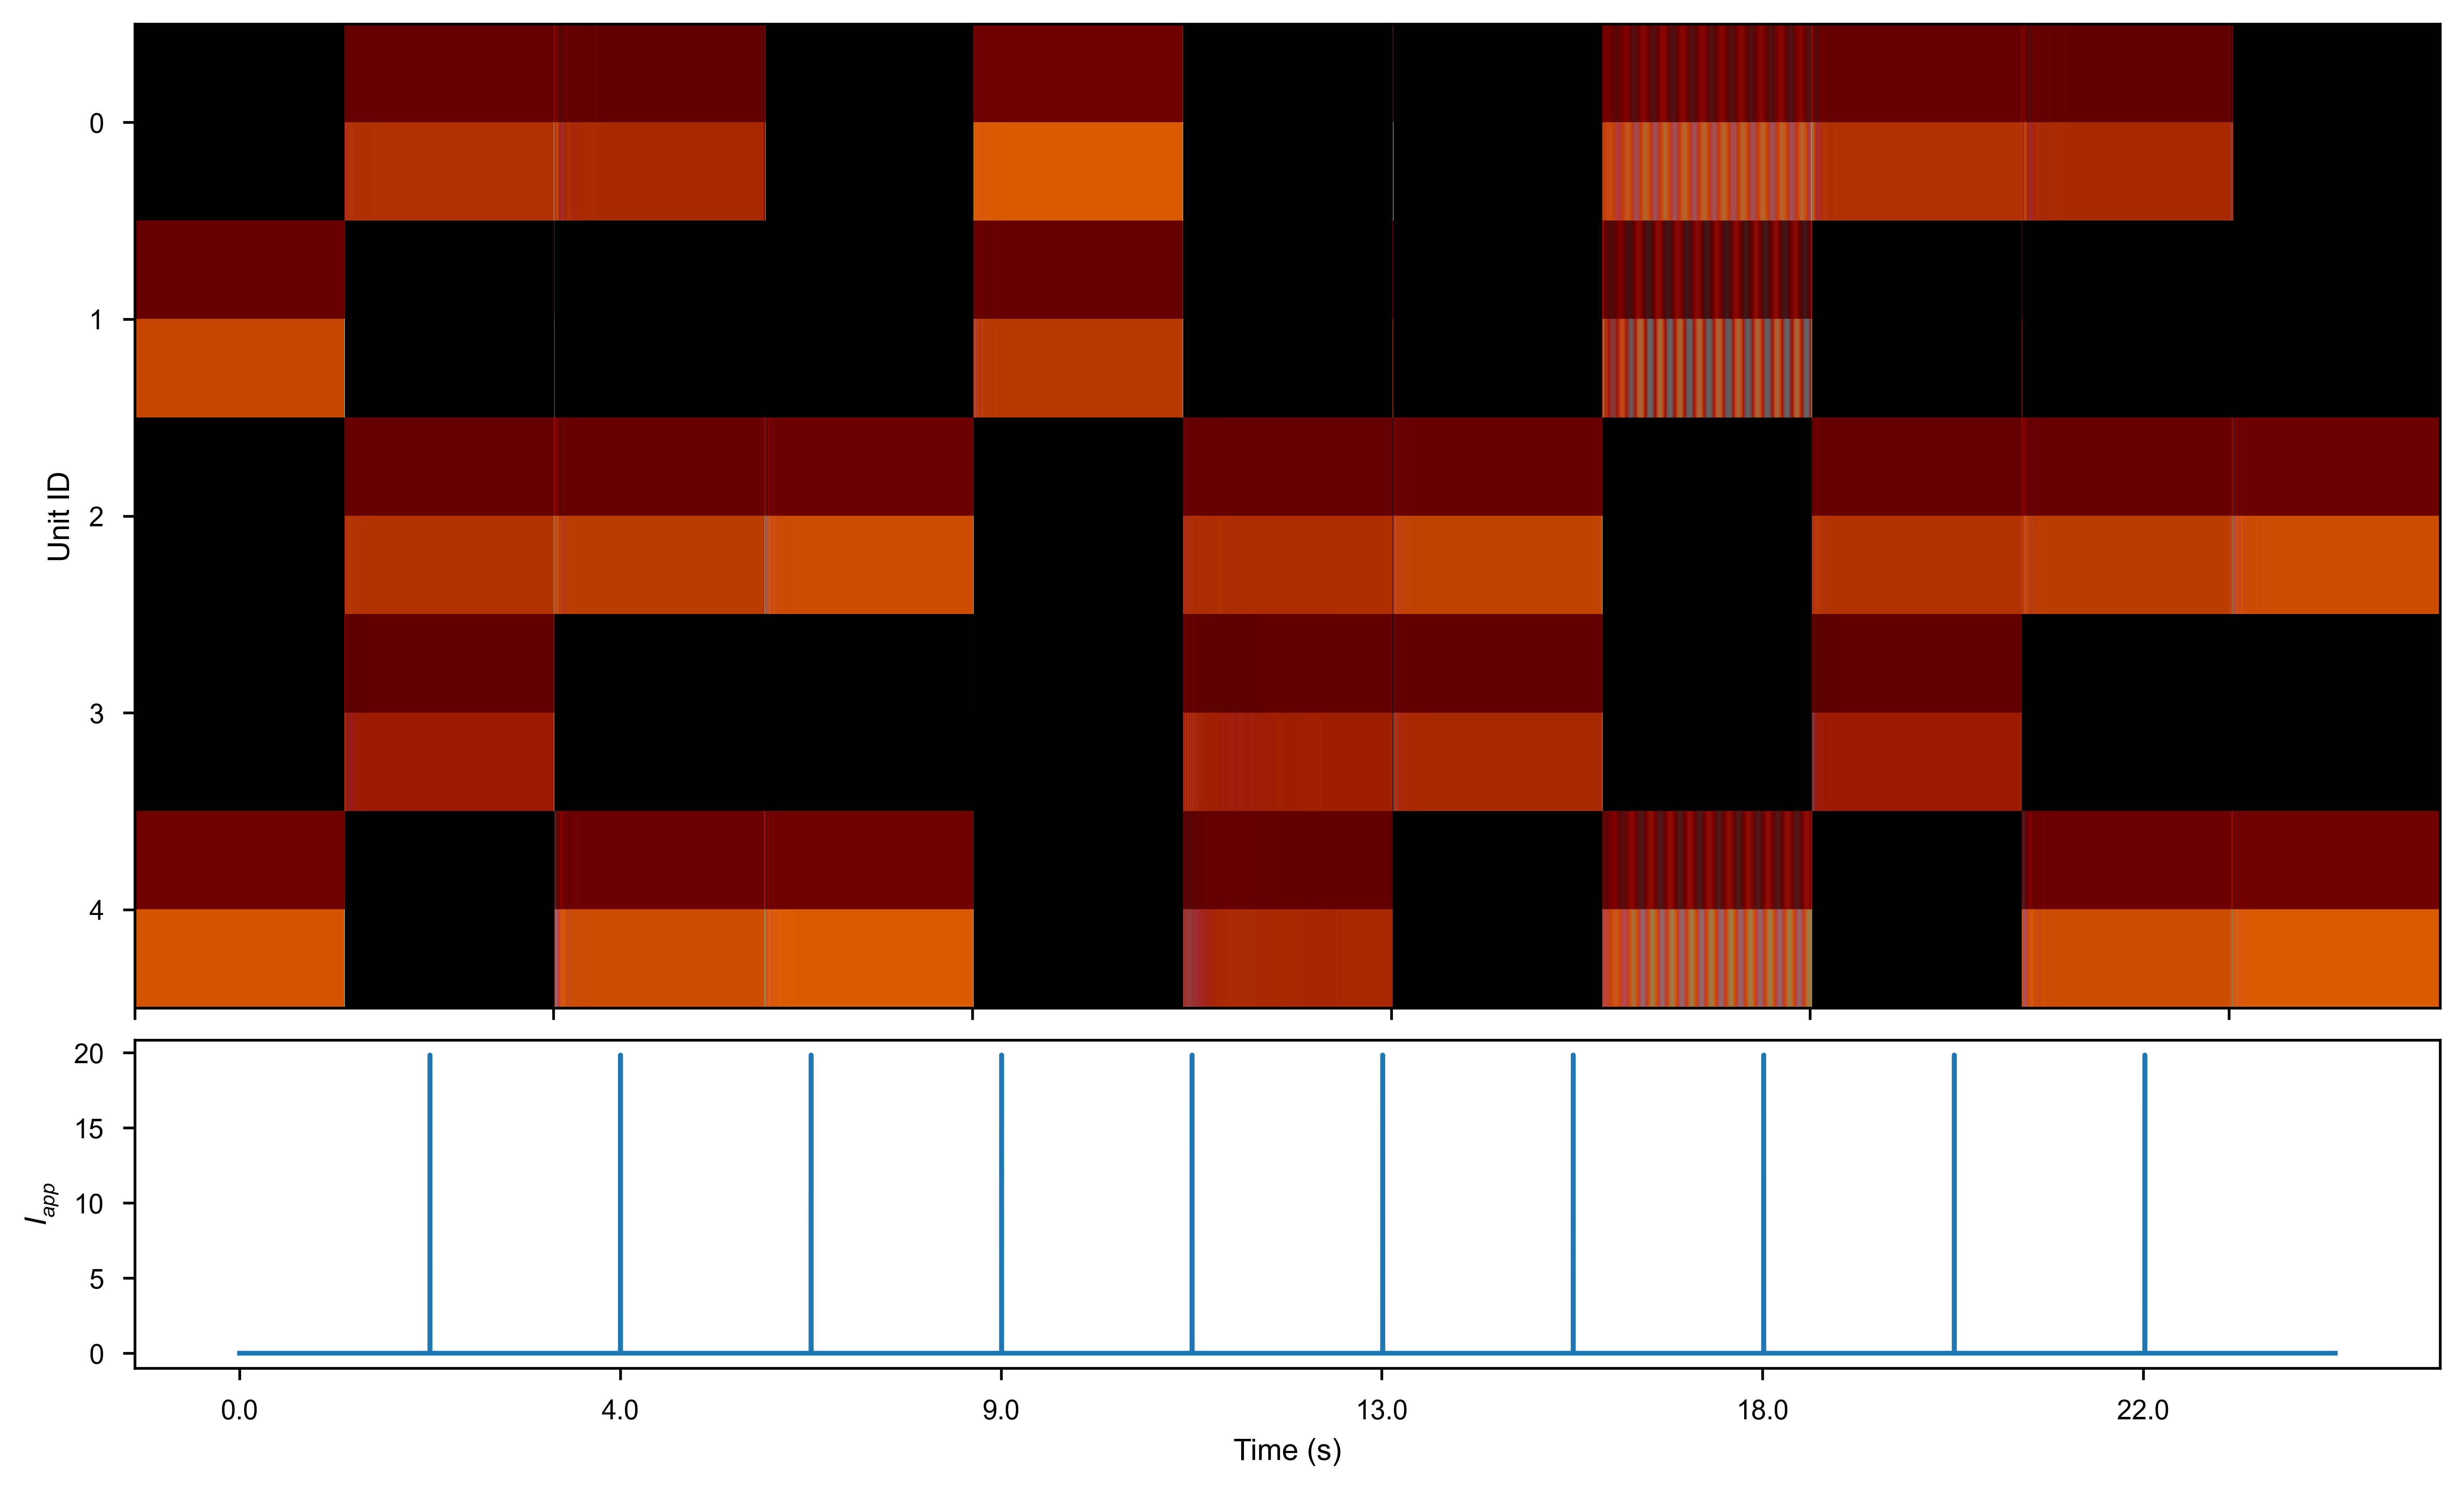

State 13


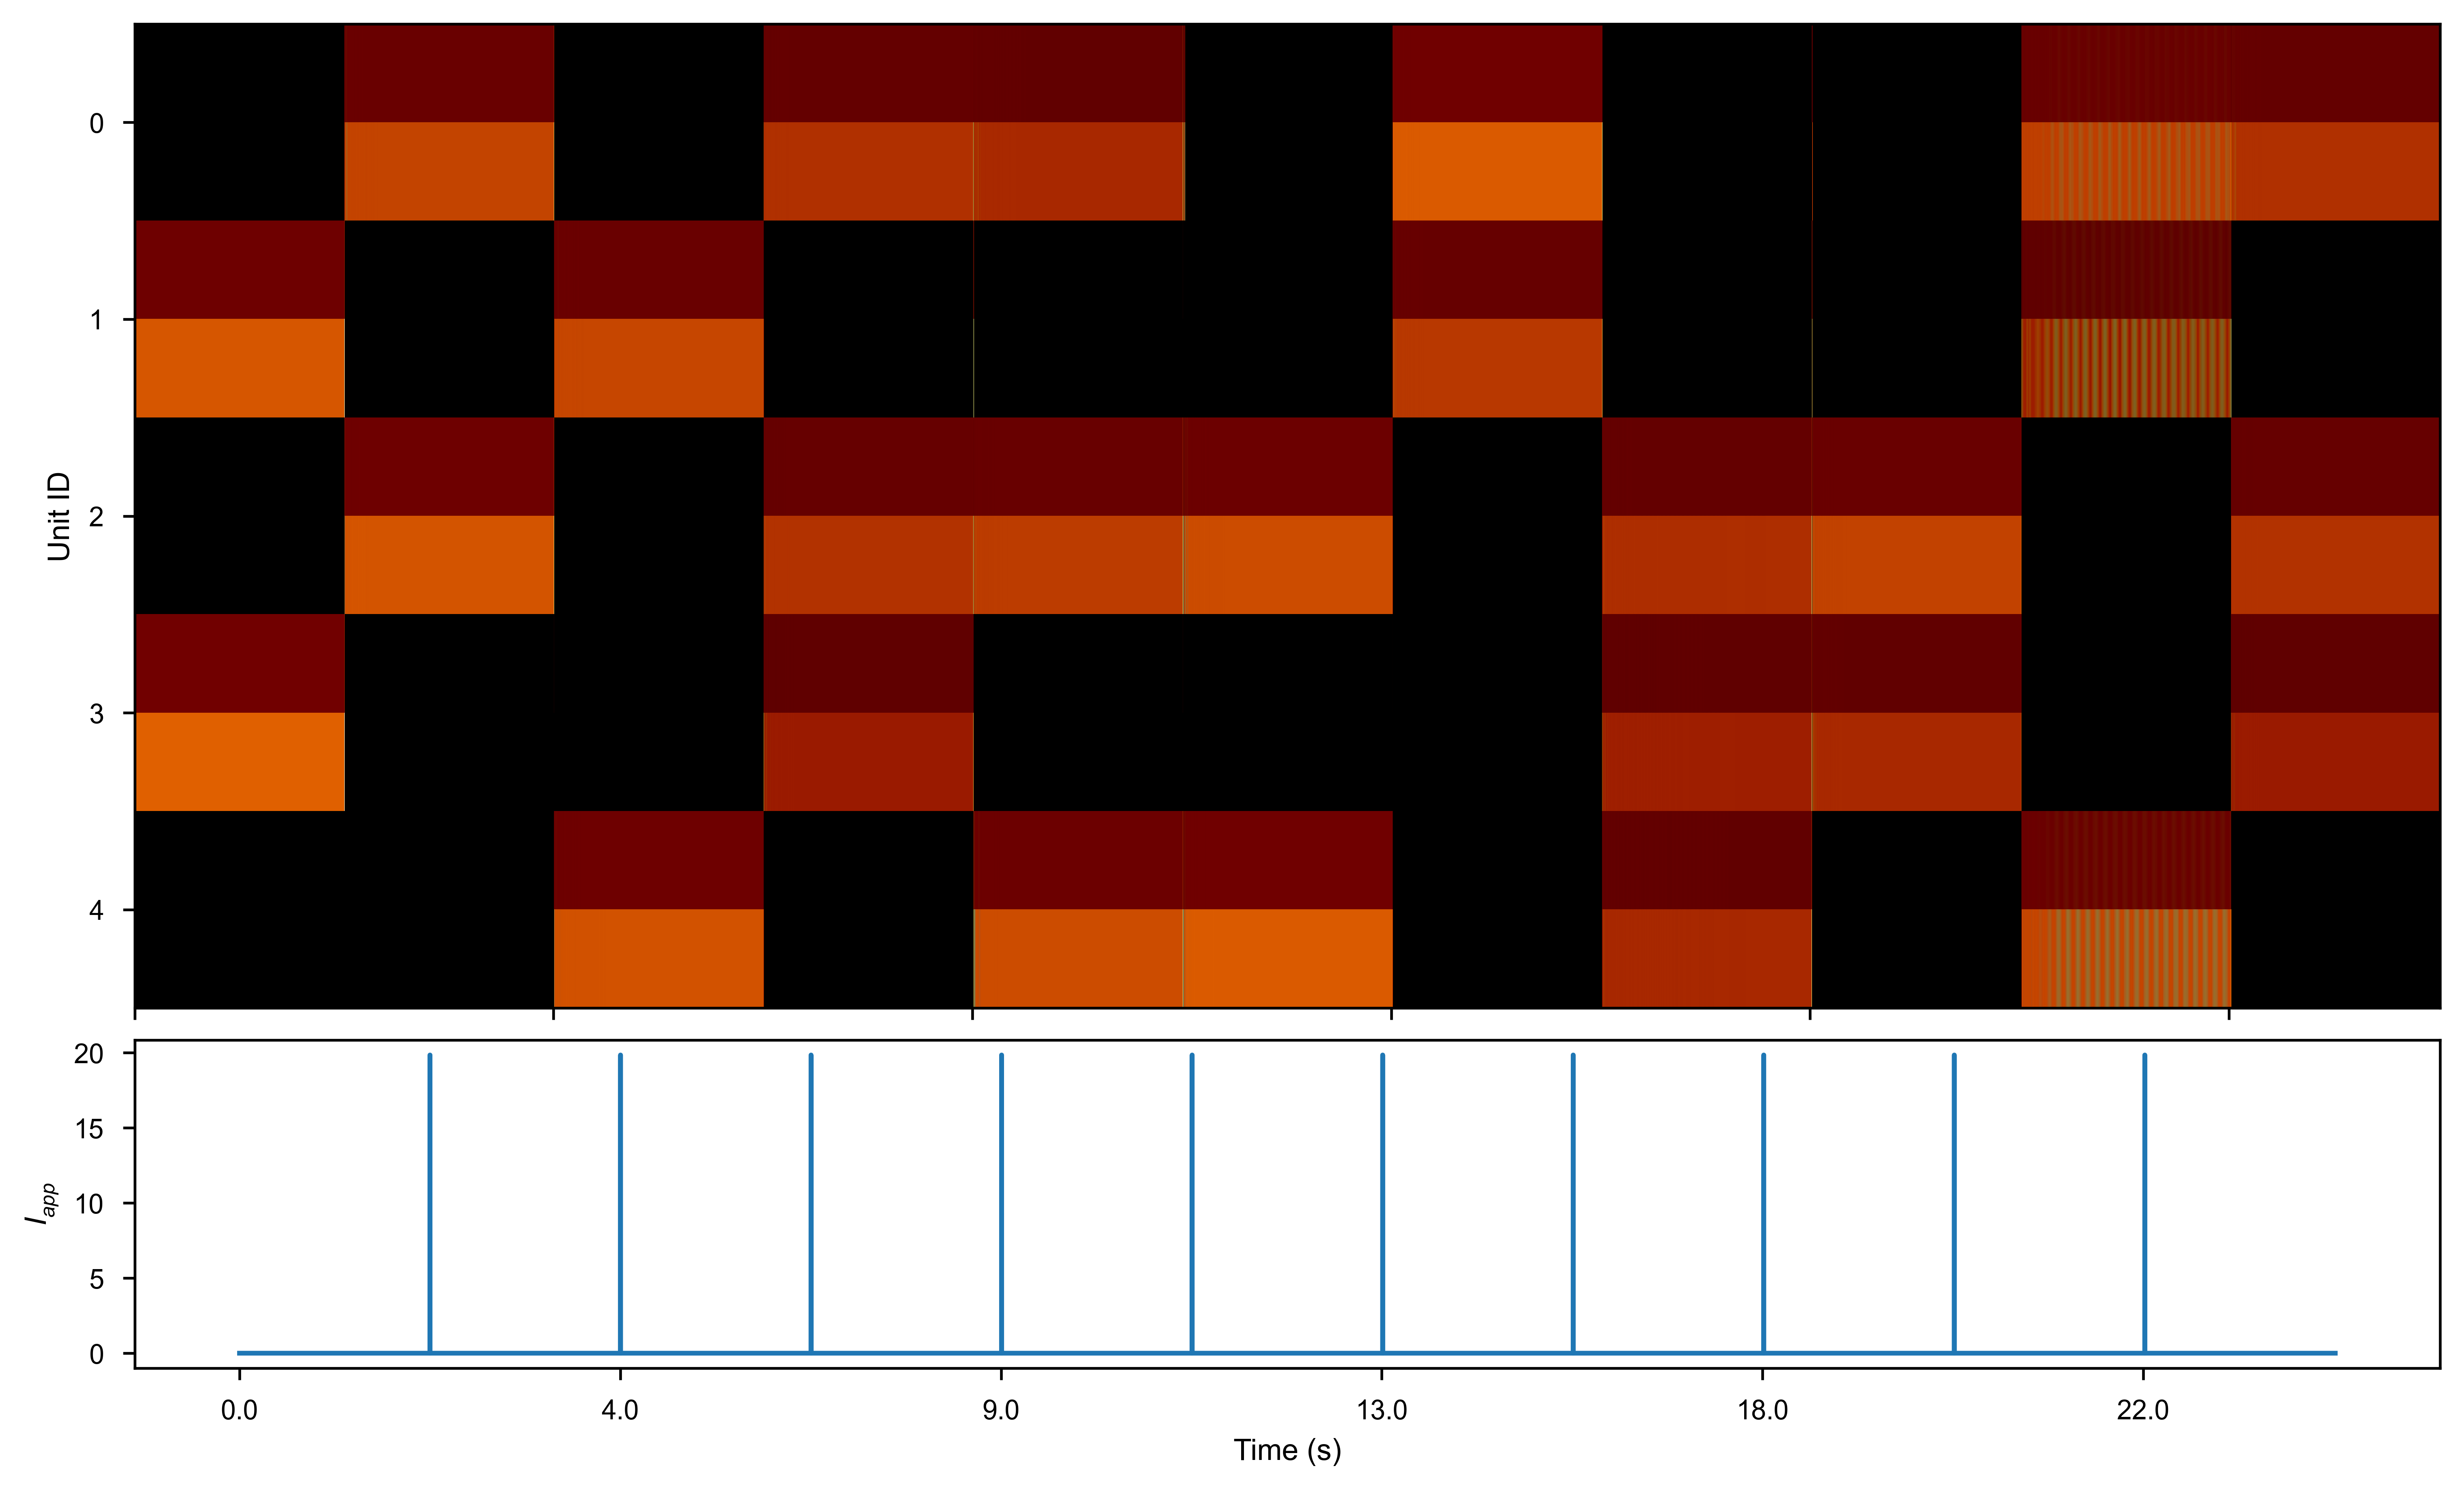

State 14


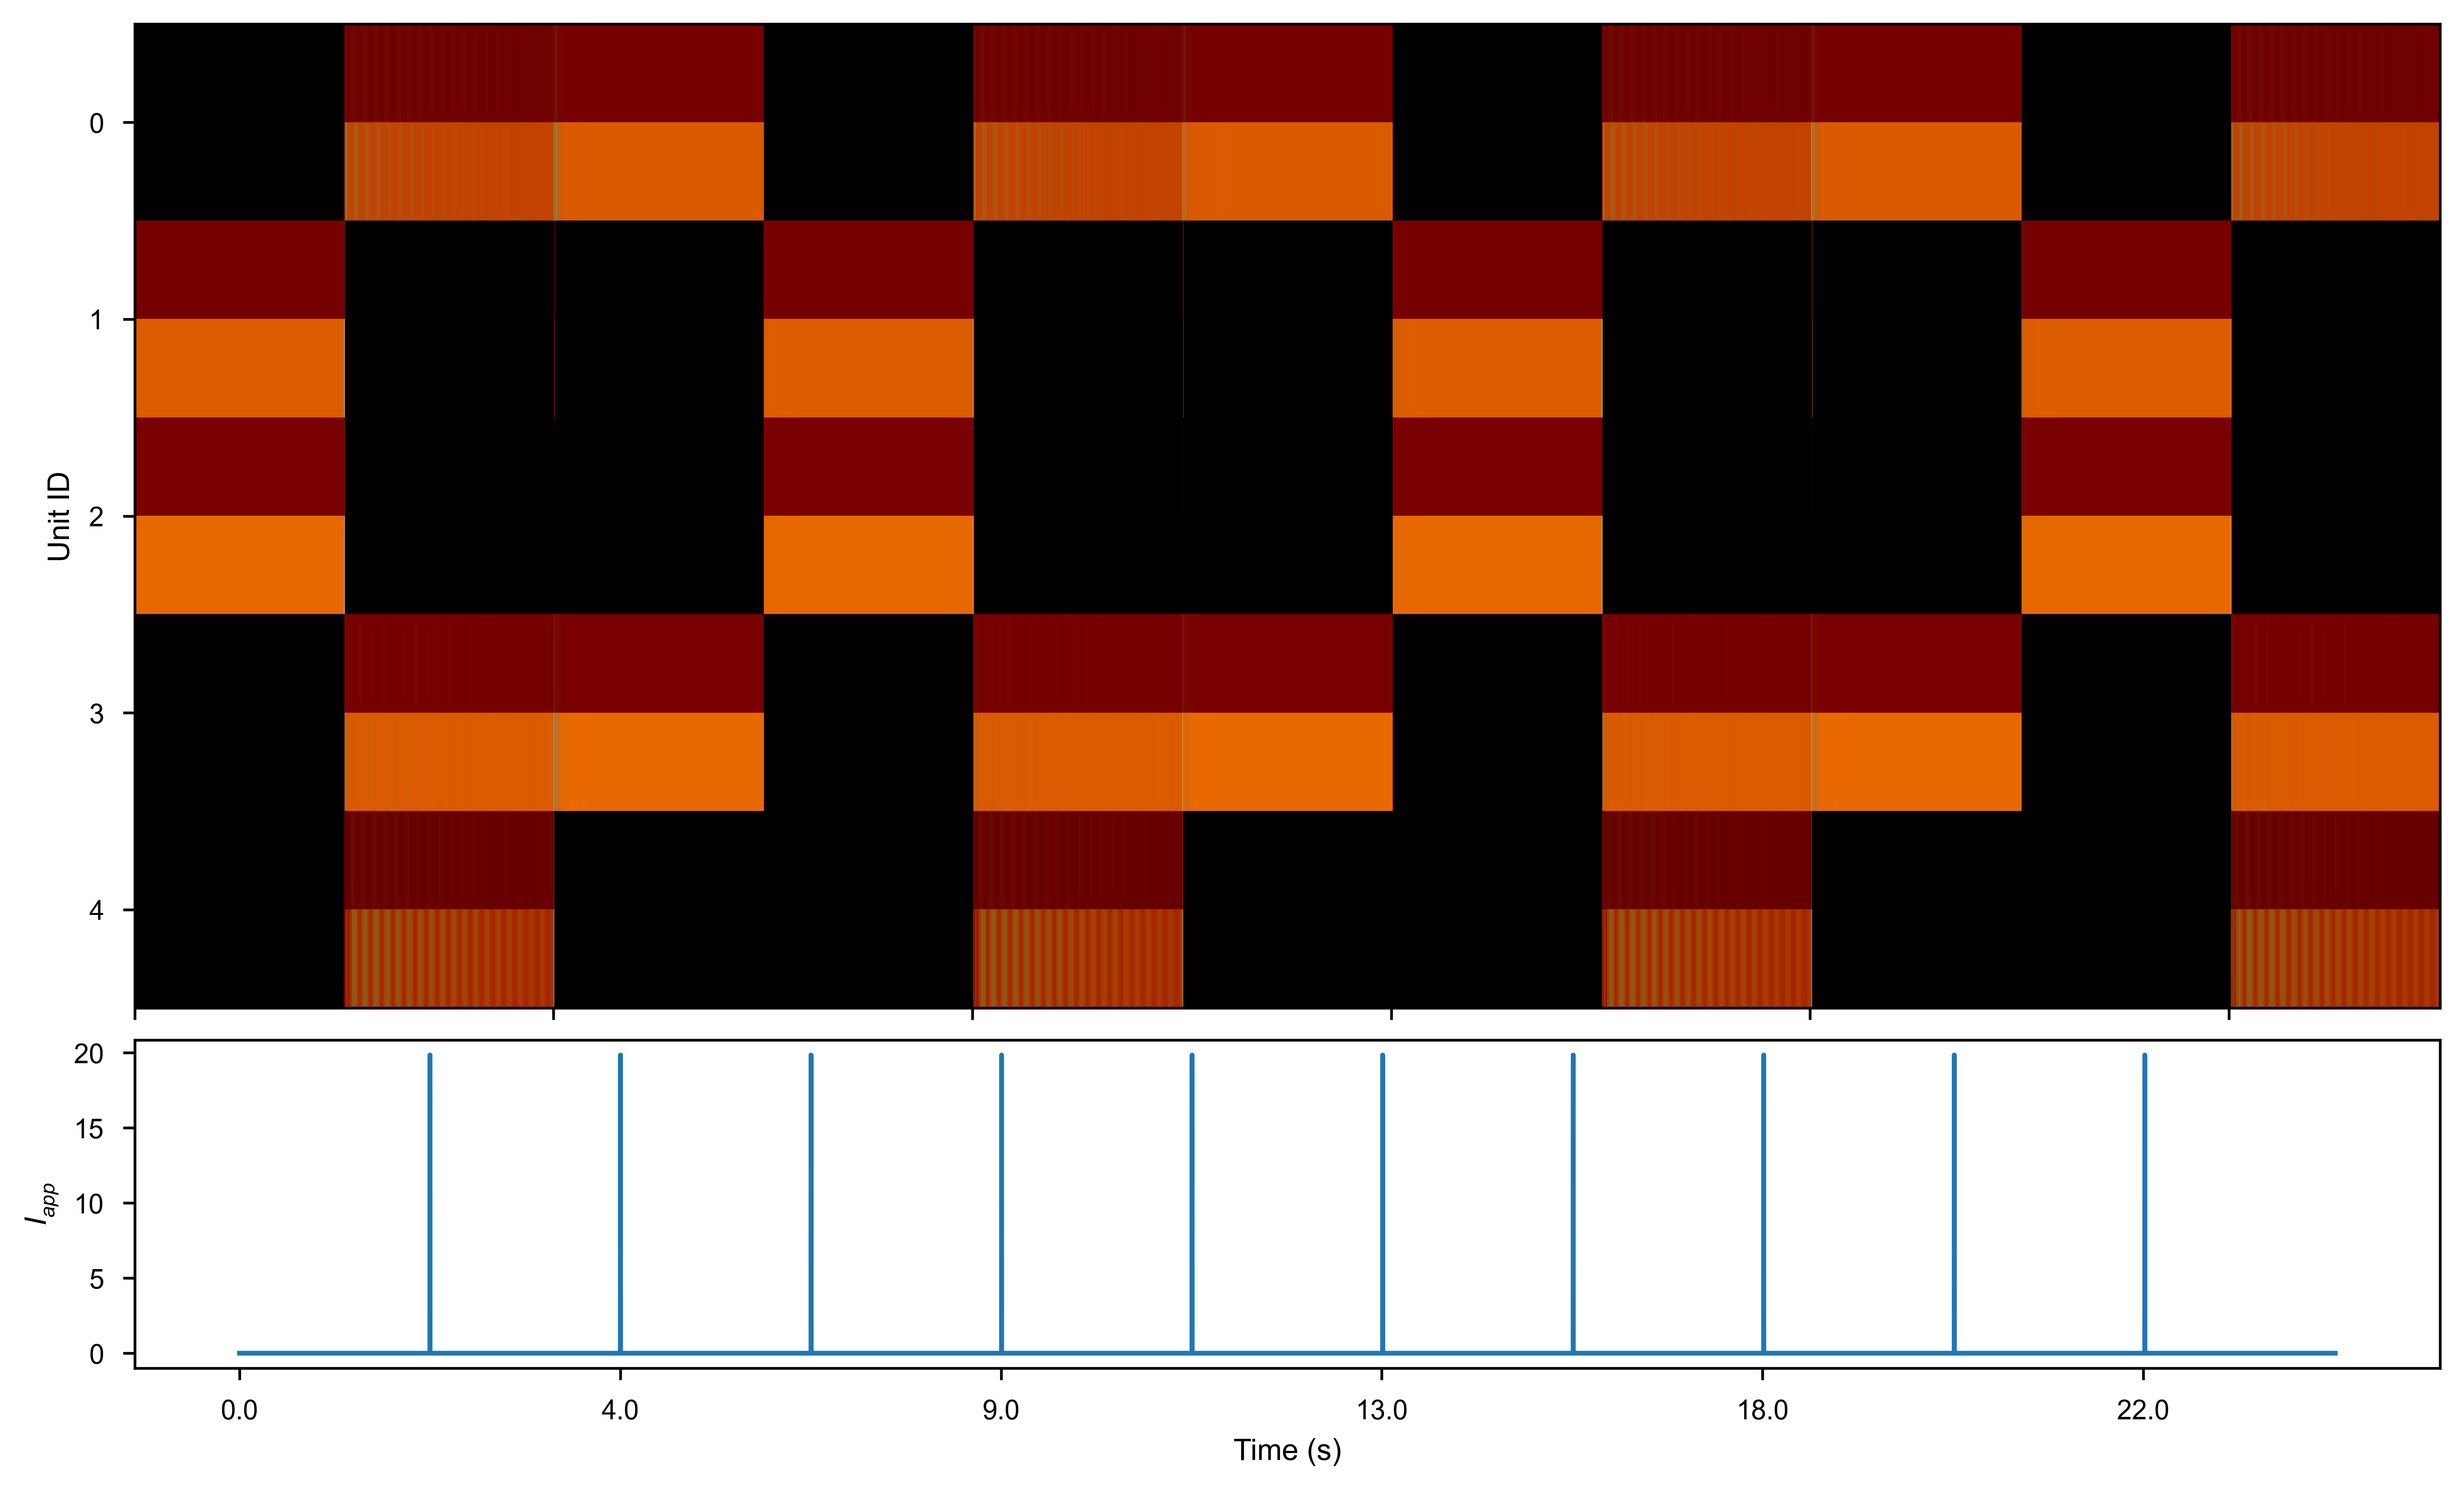

State 15


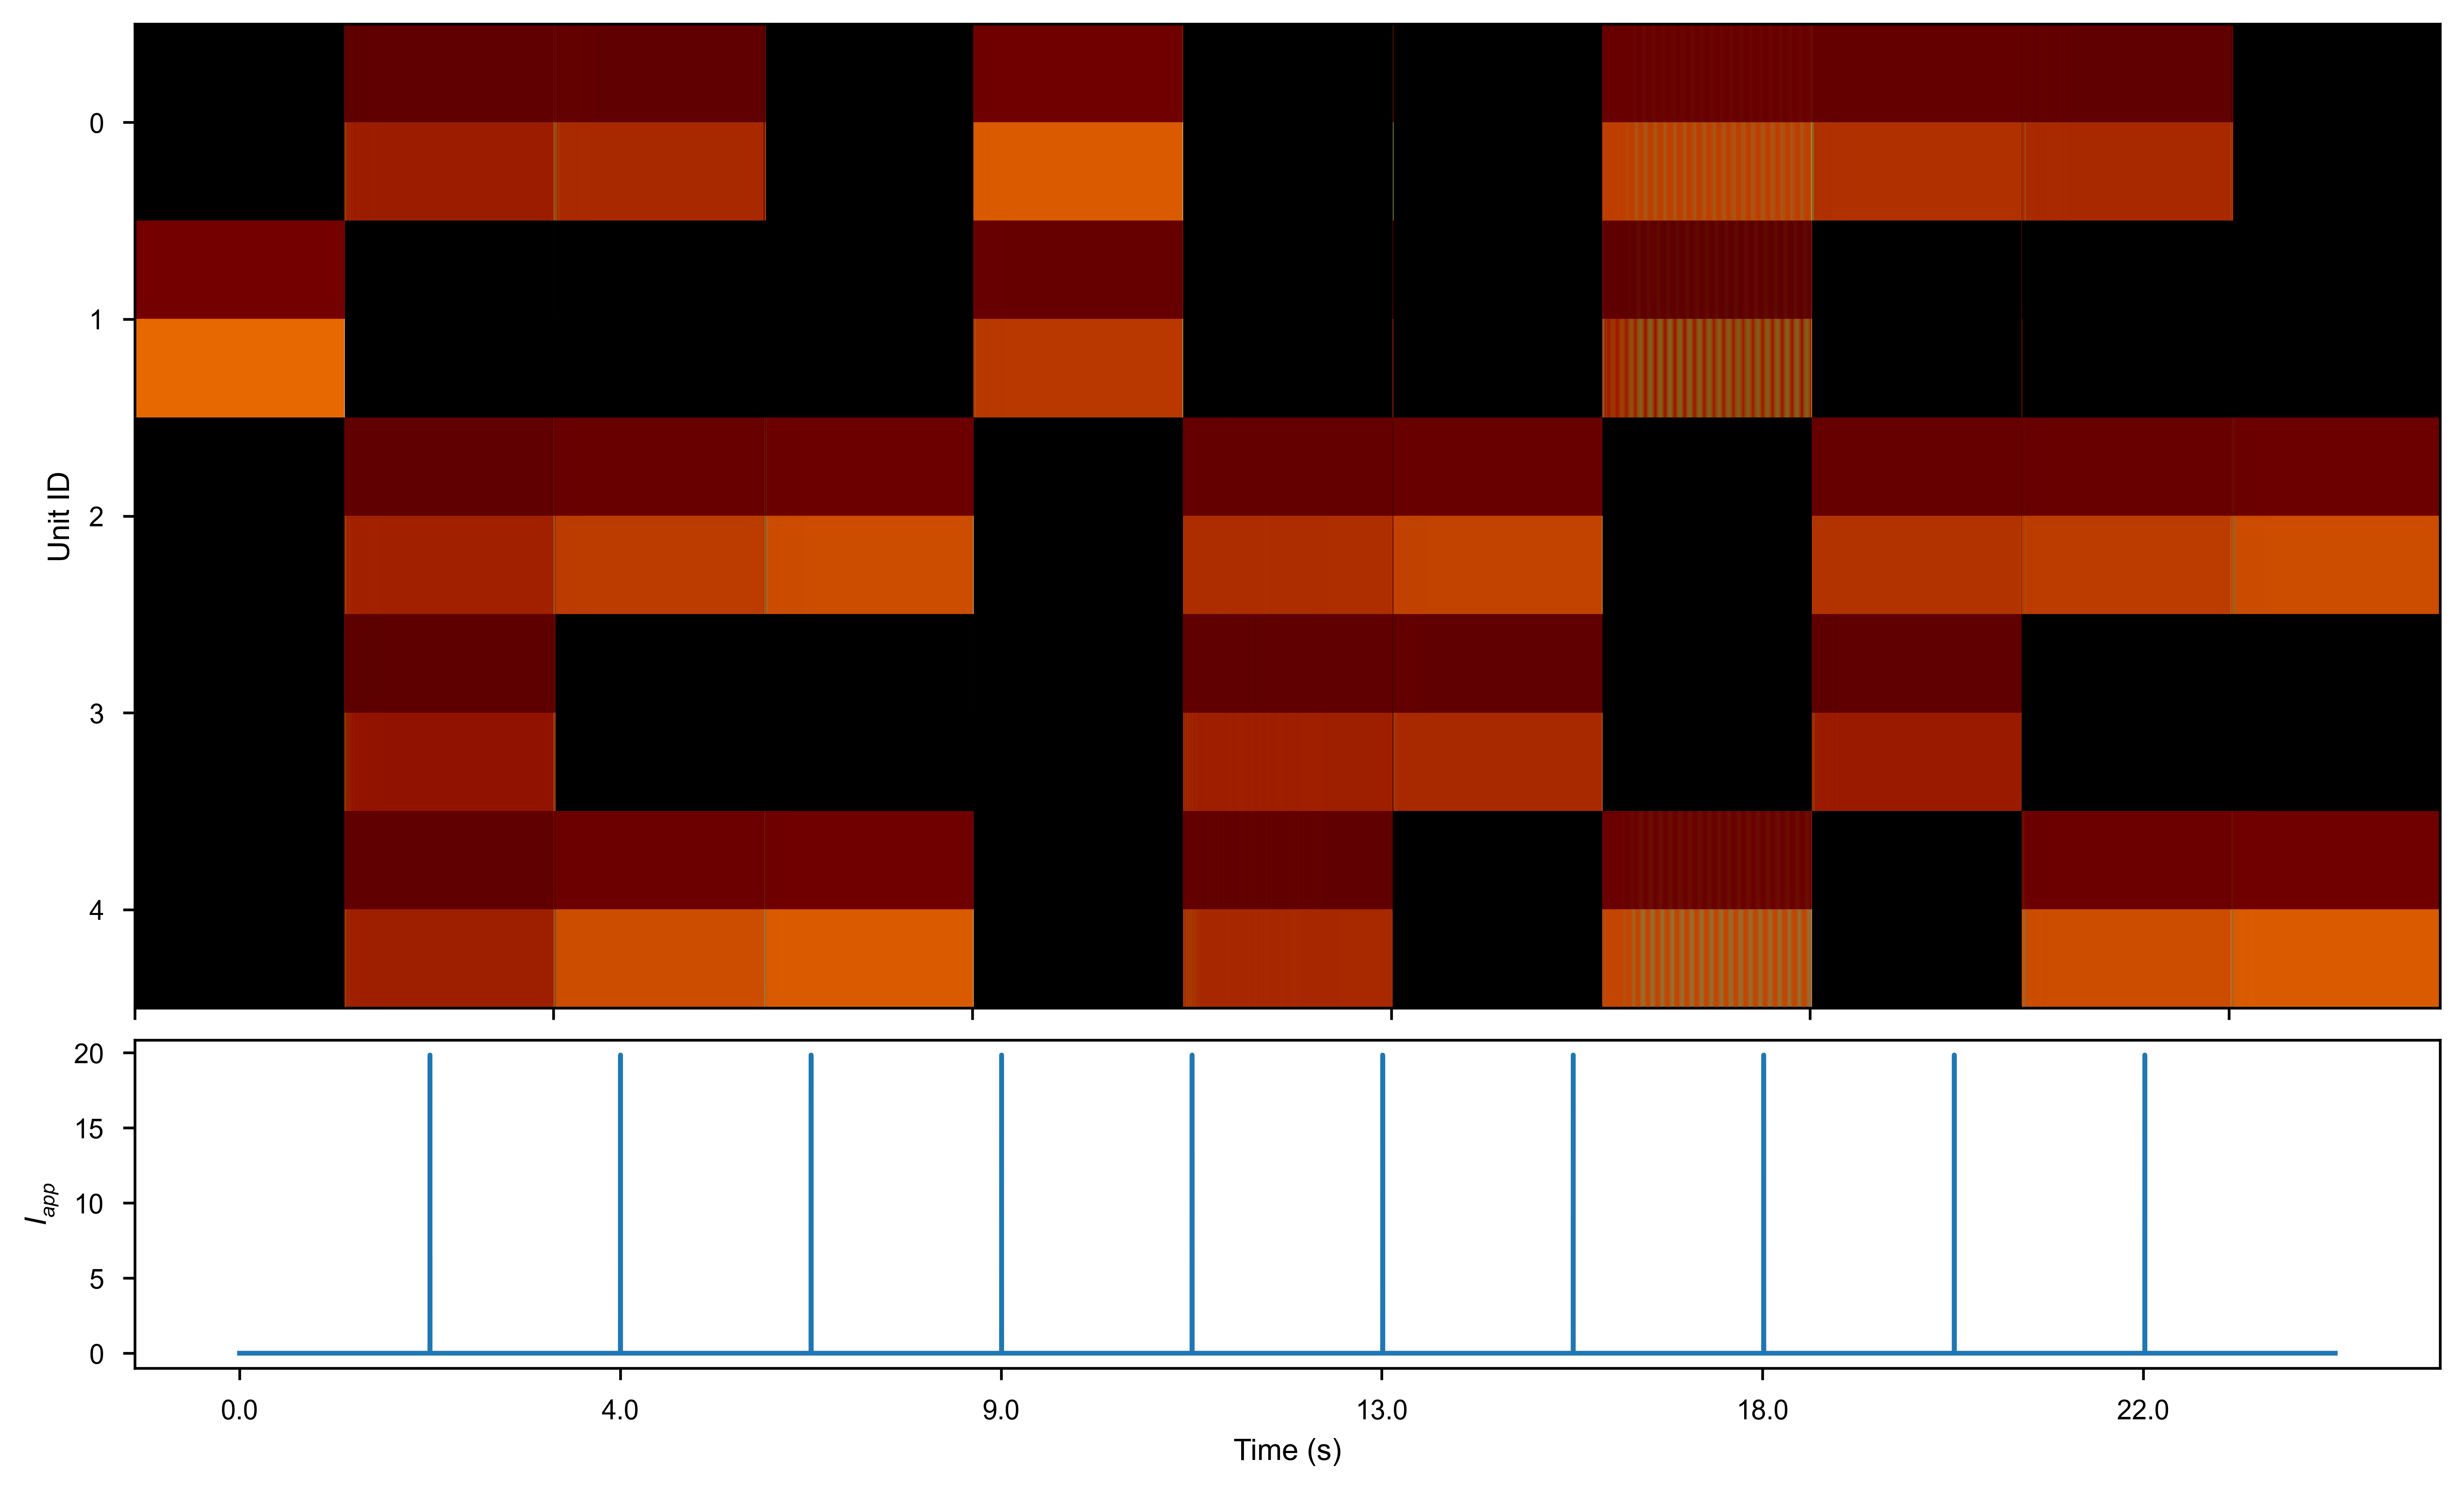

State 16


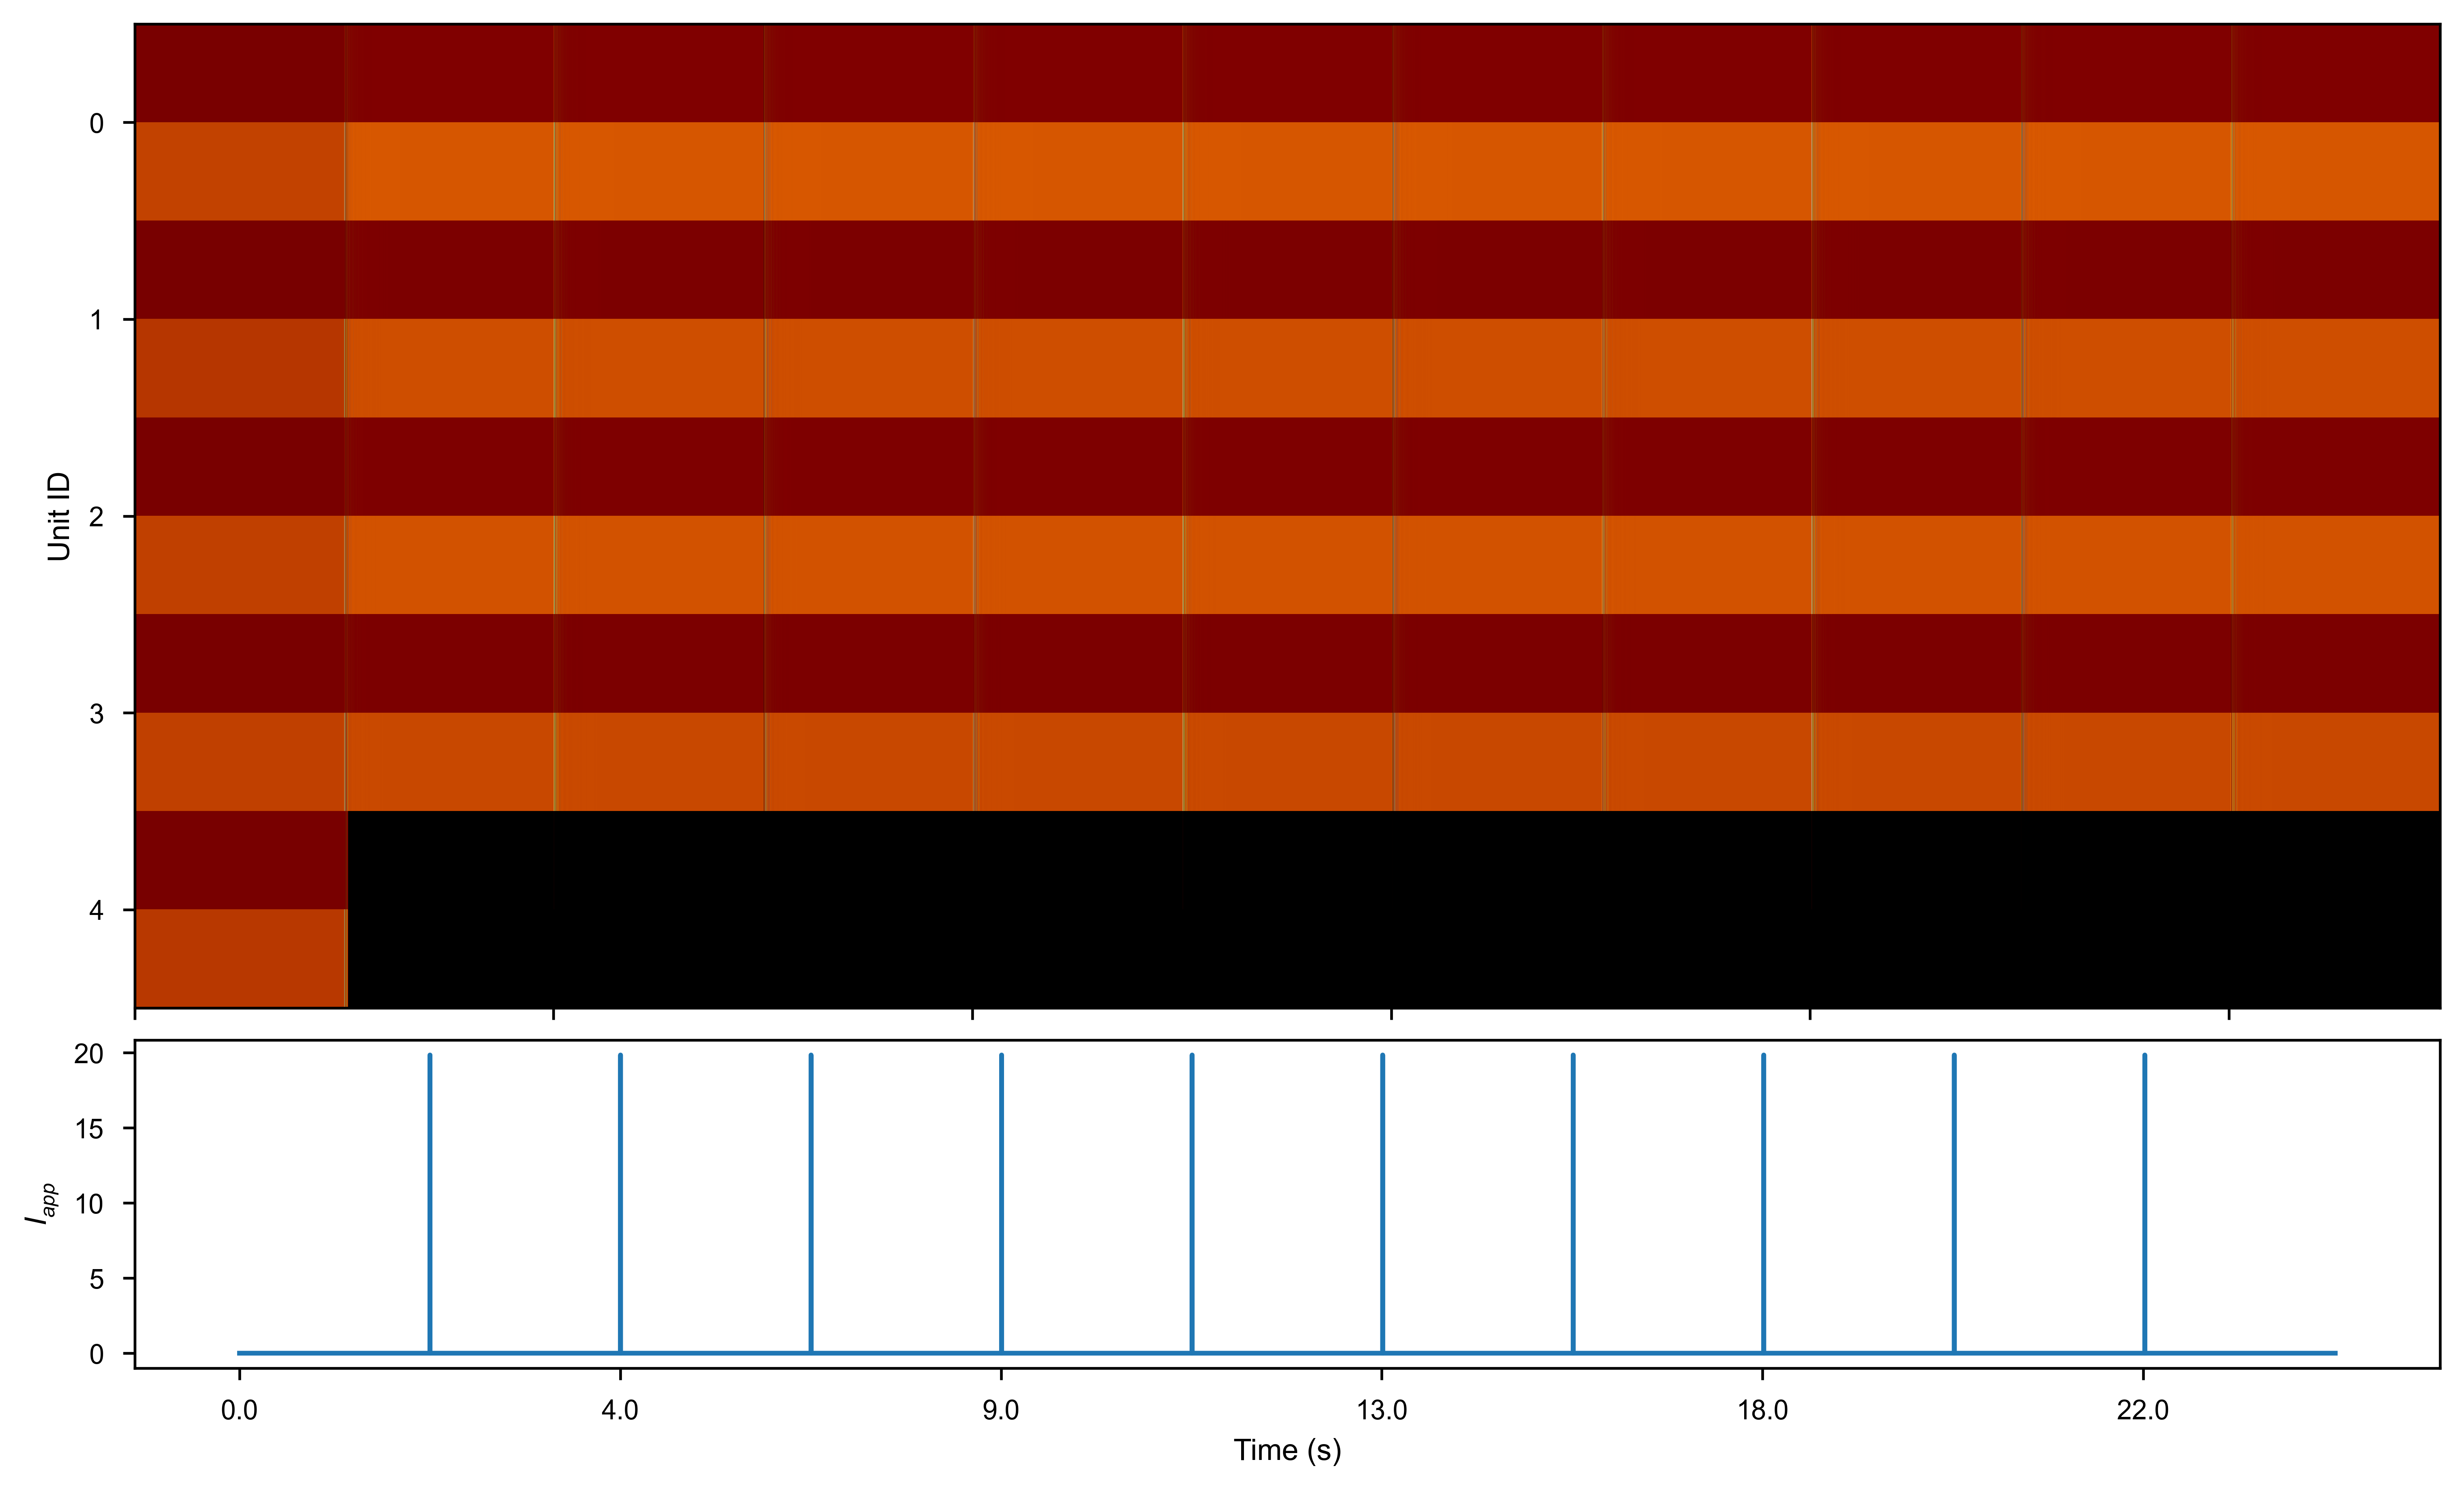

State 17


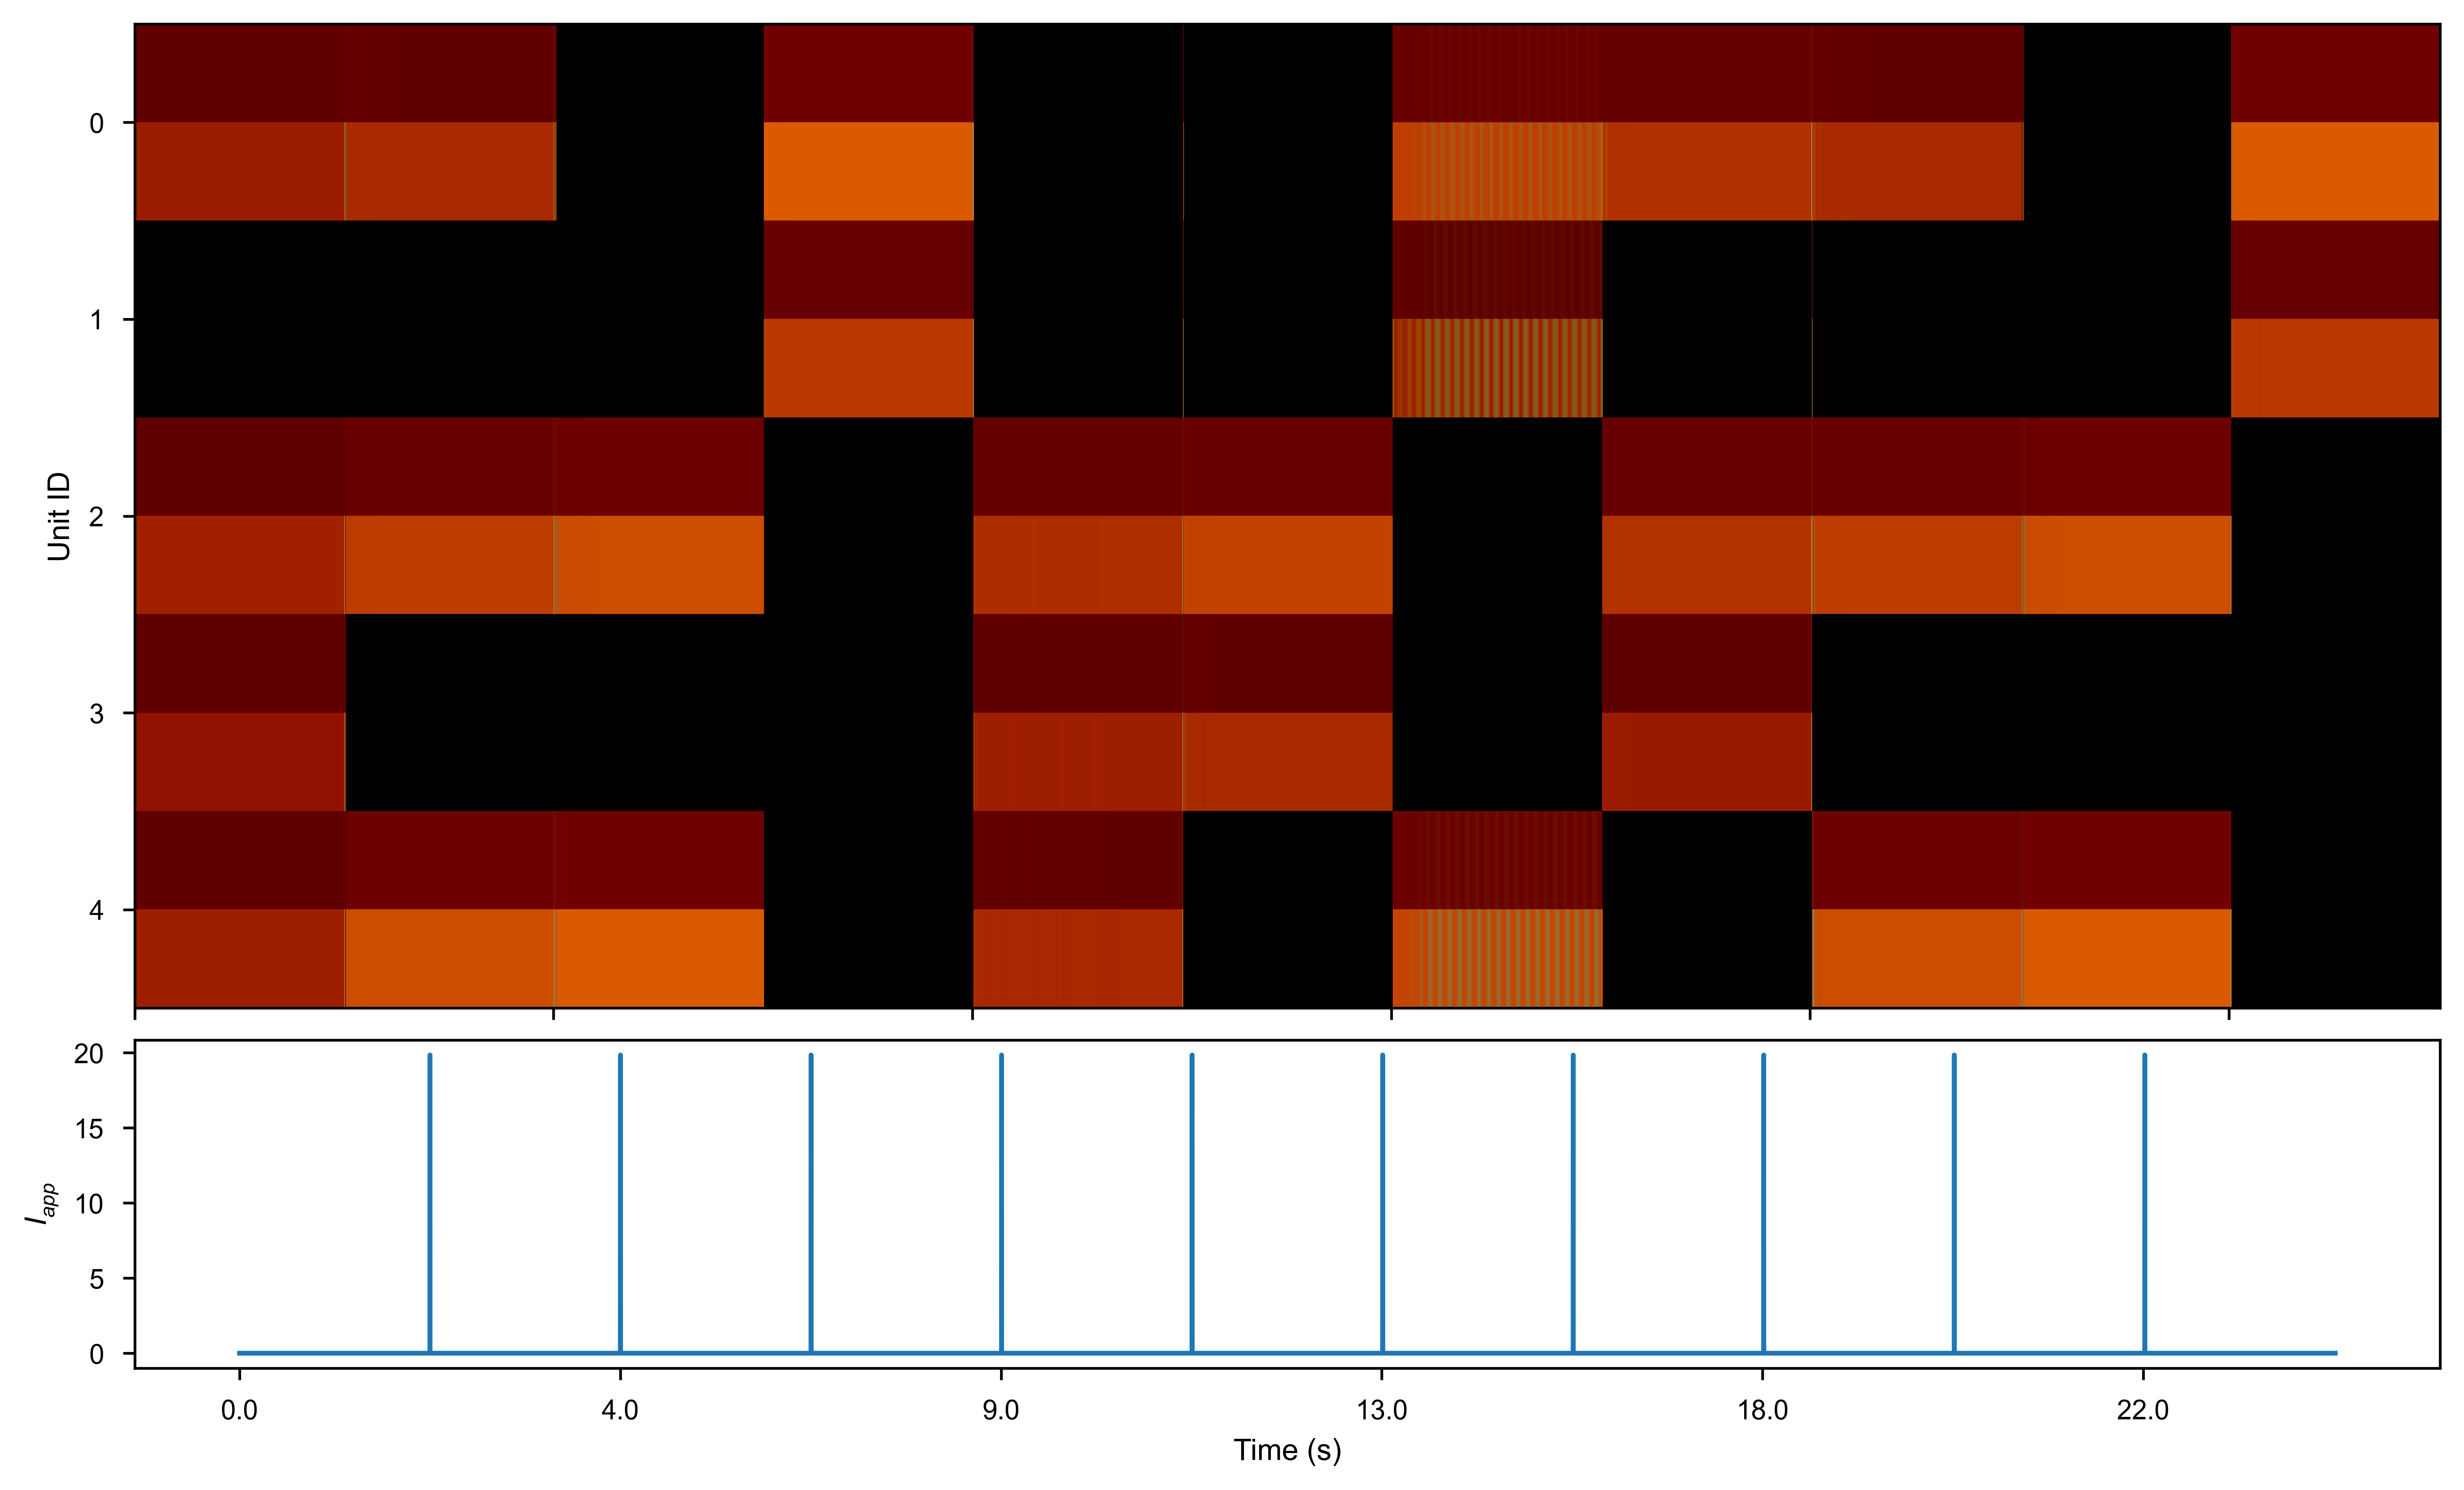

State 18


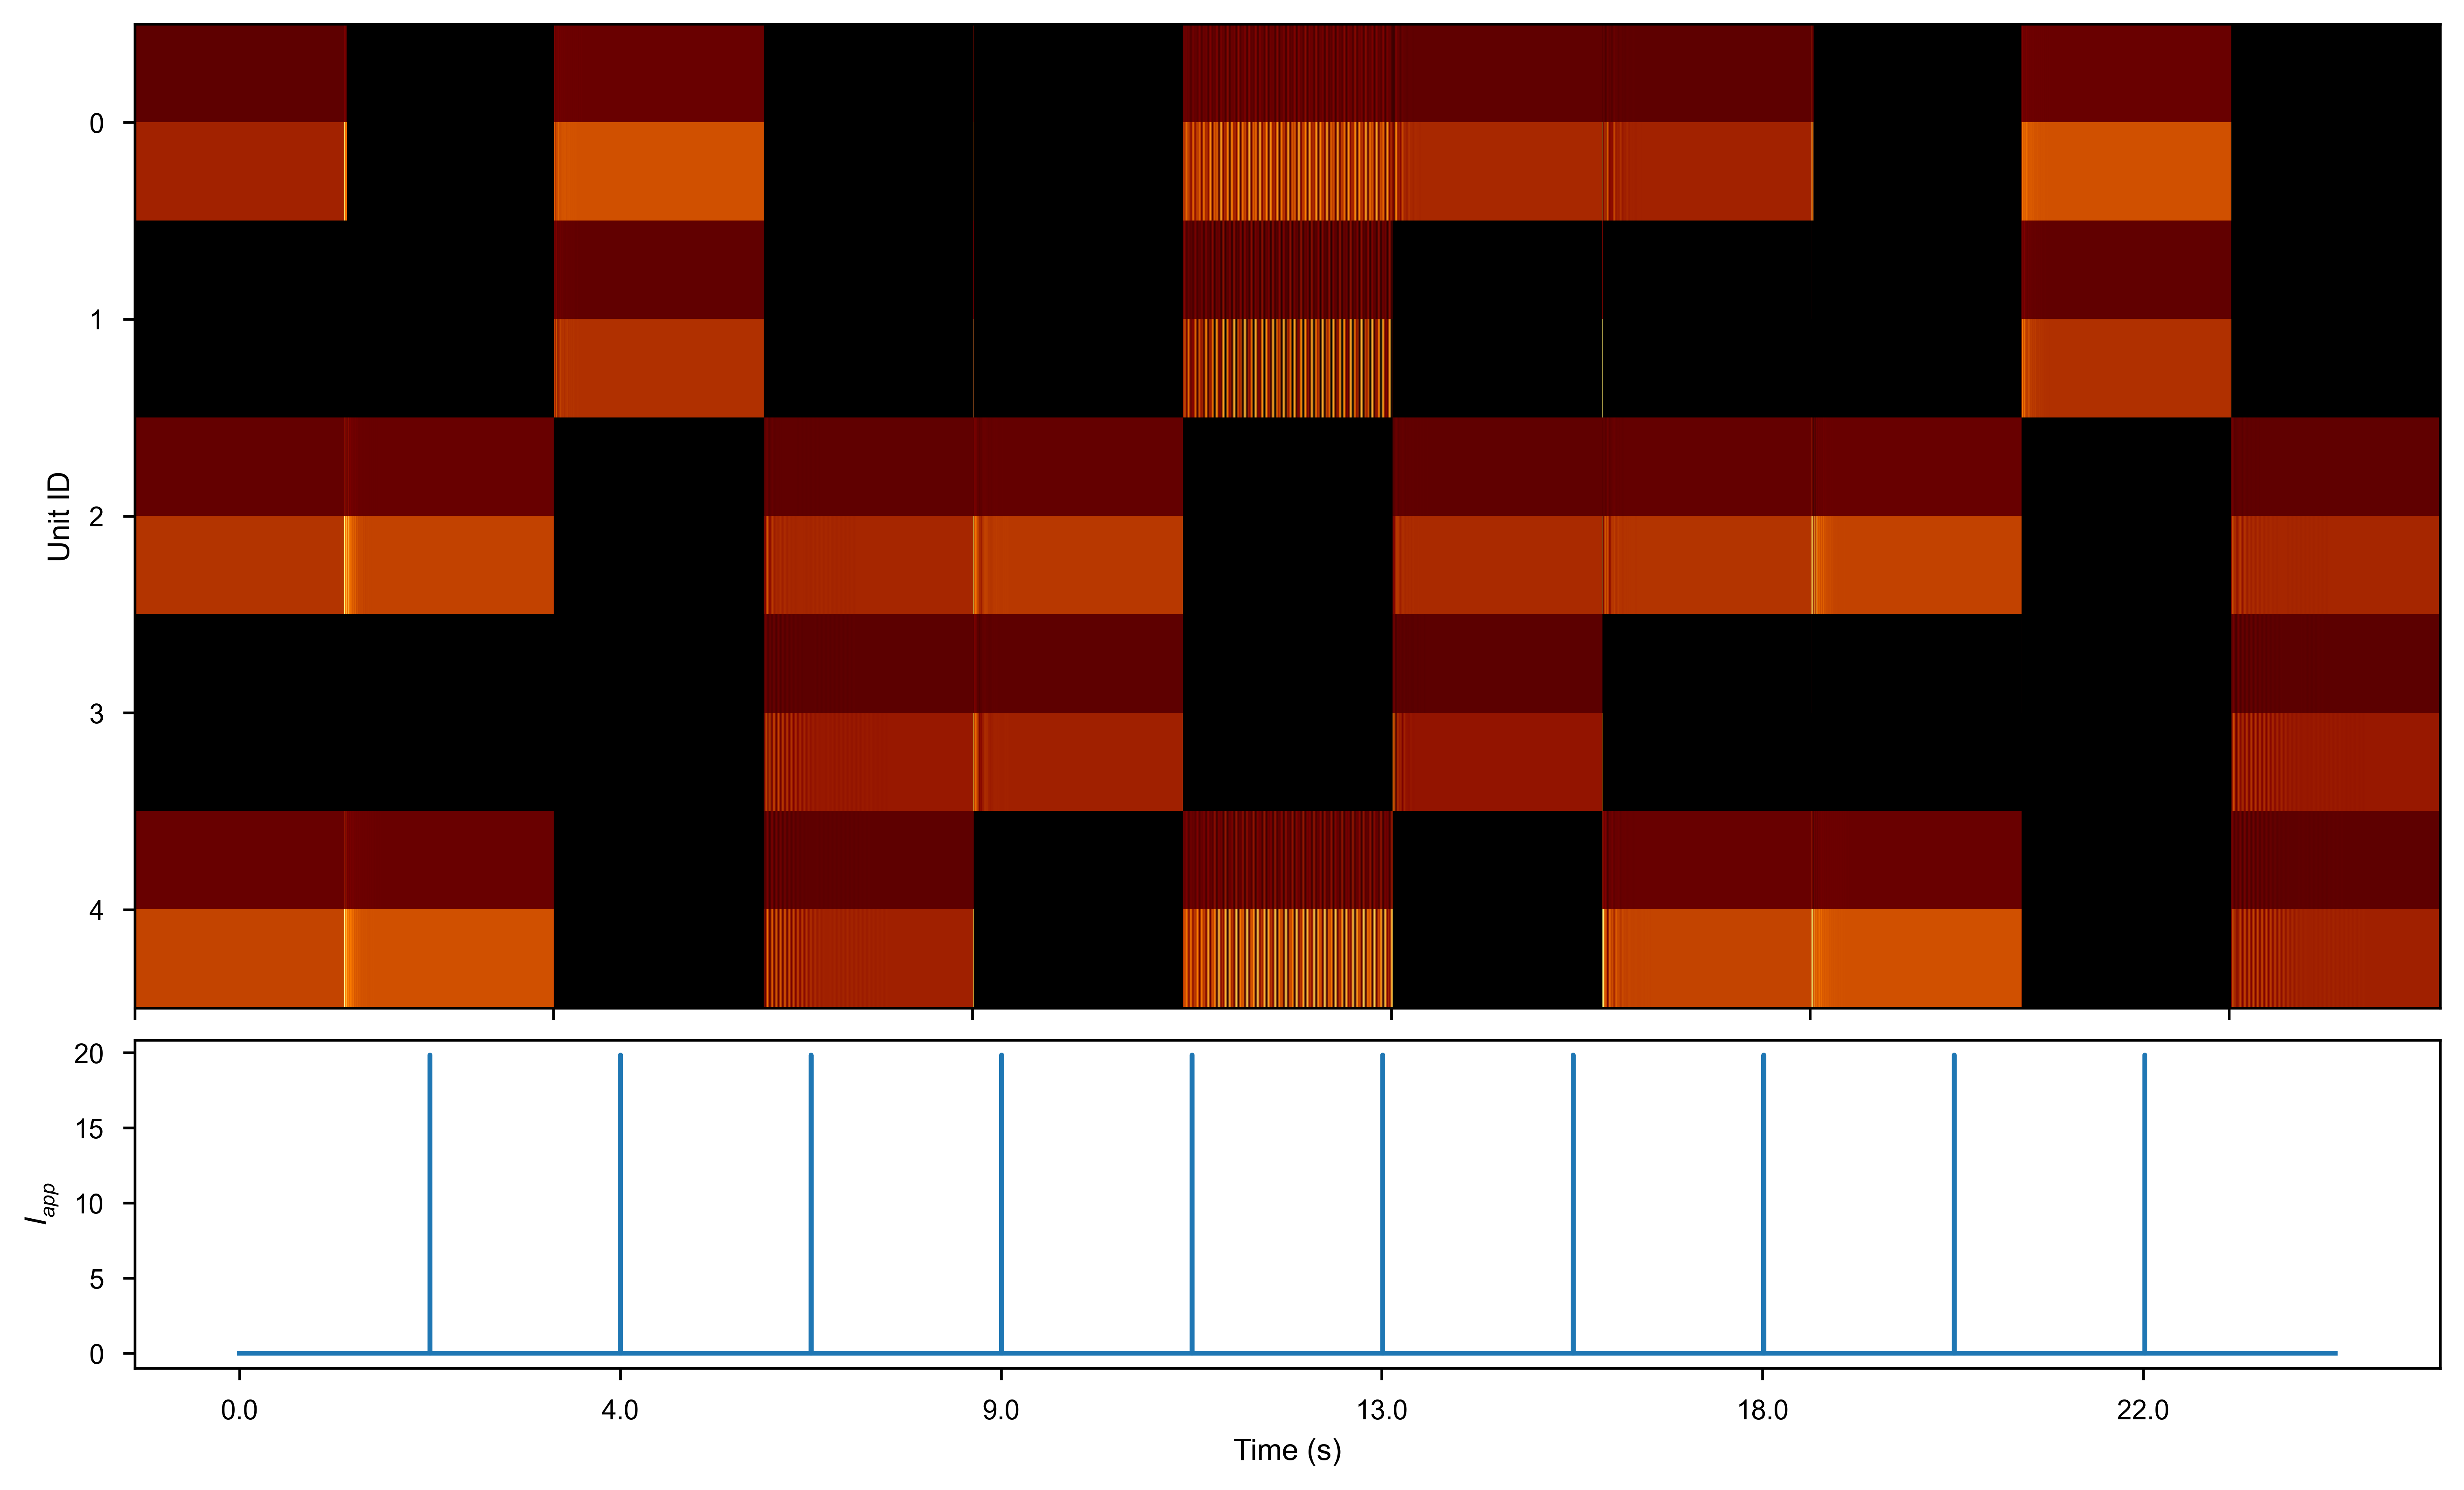

State 19


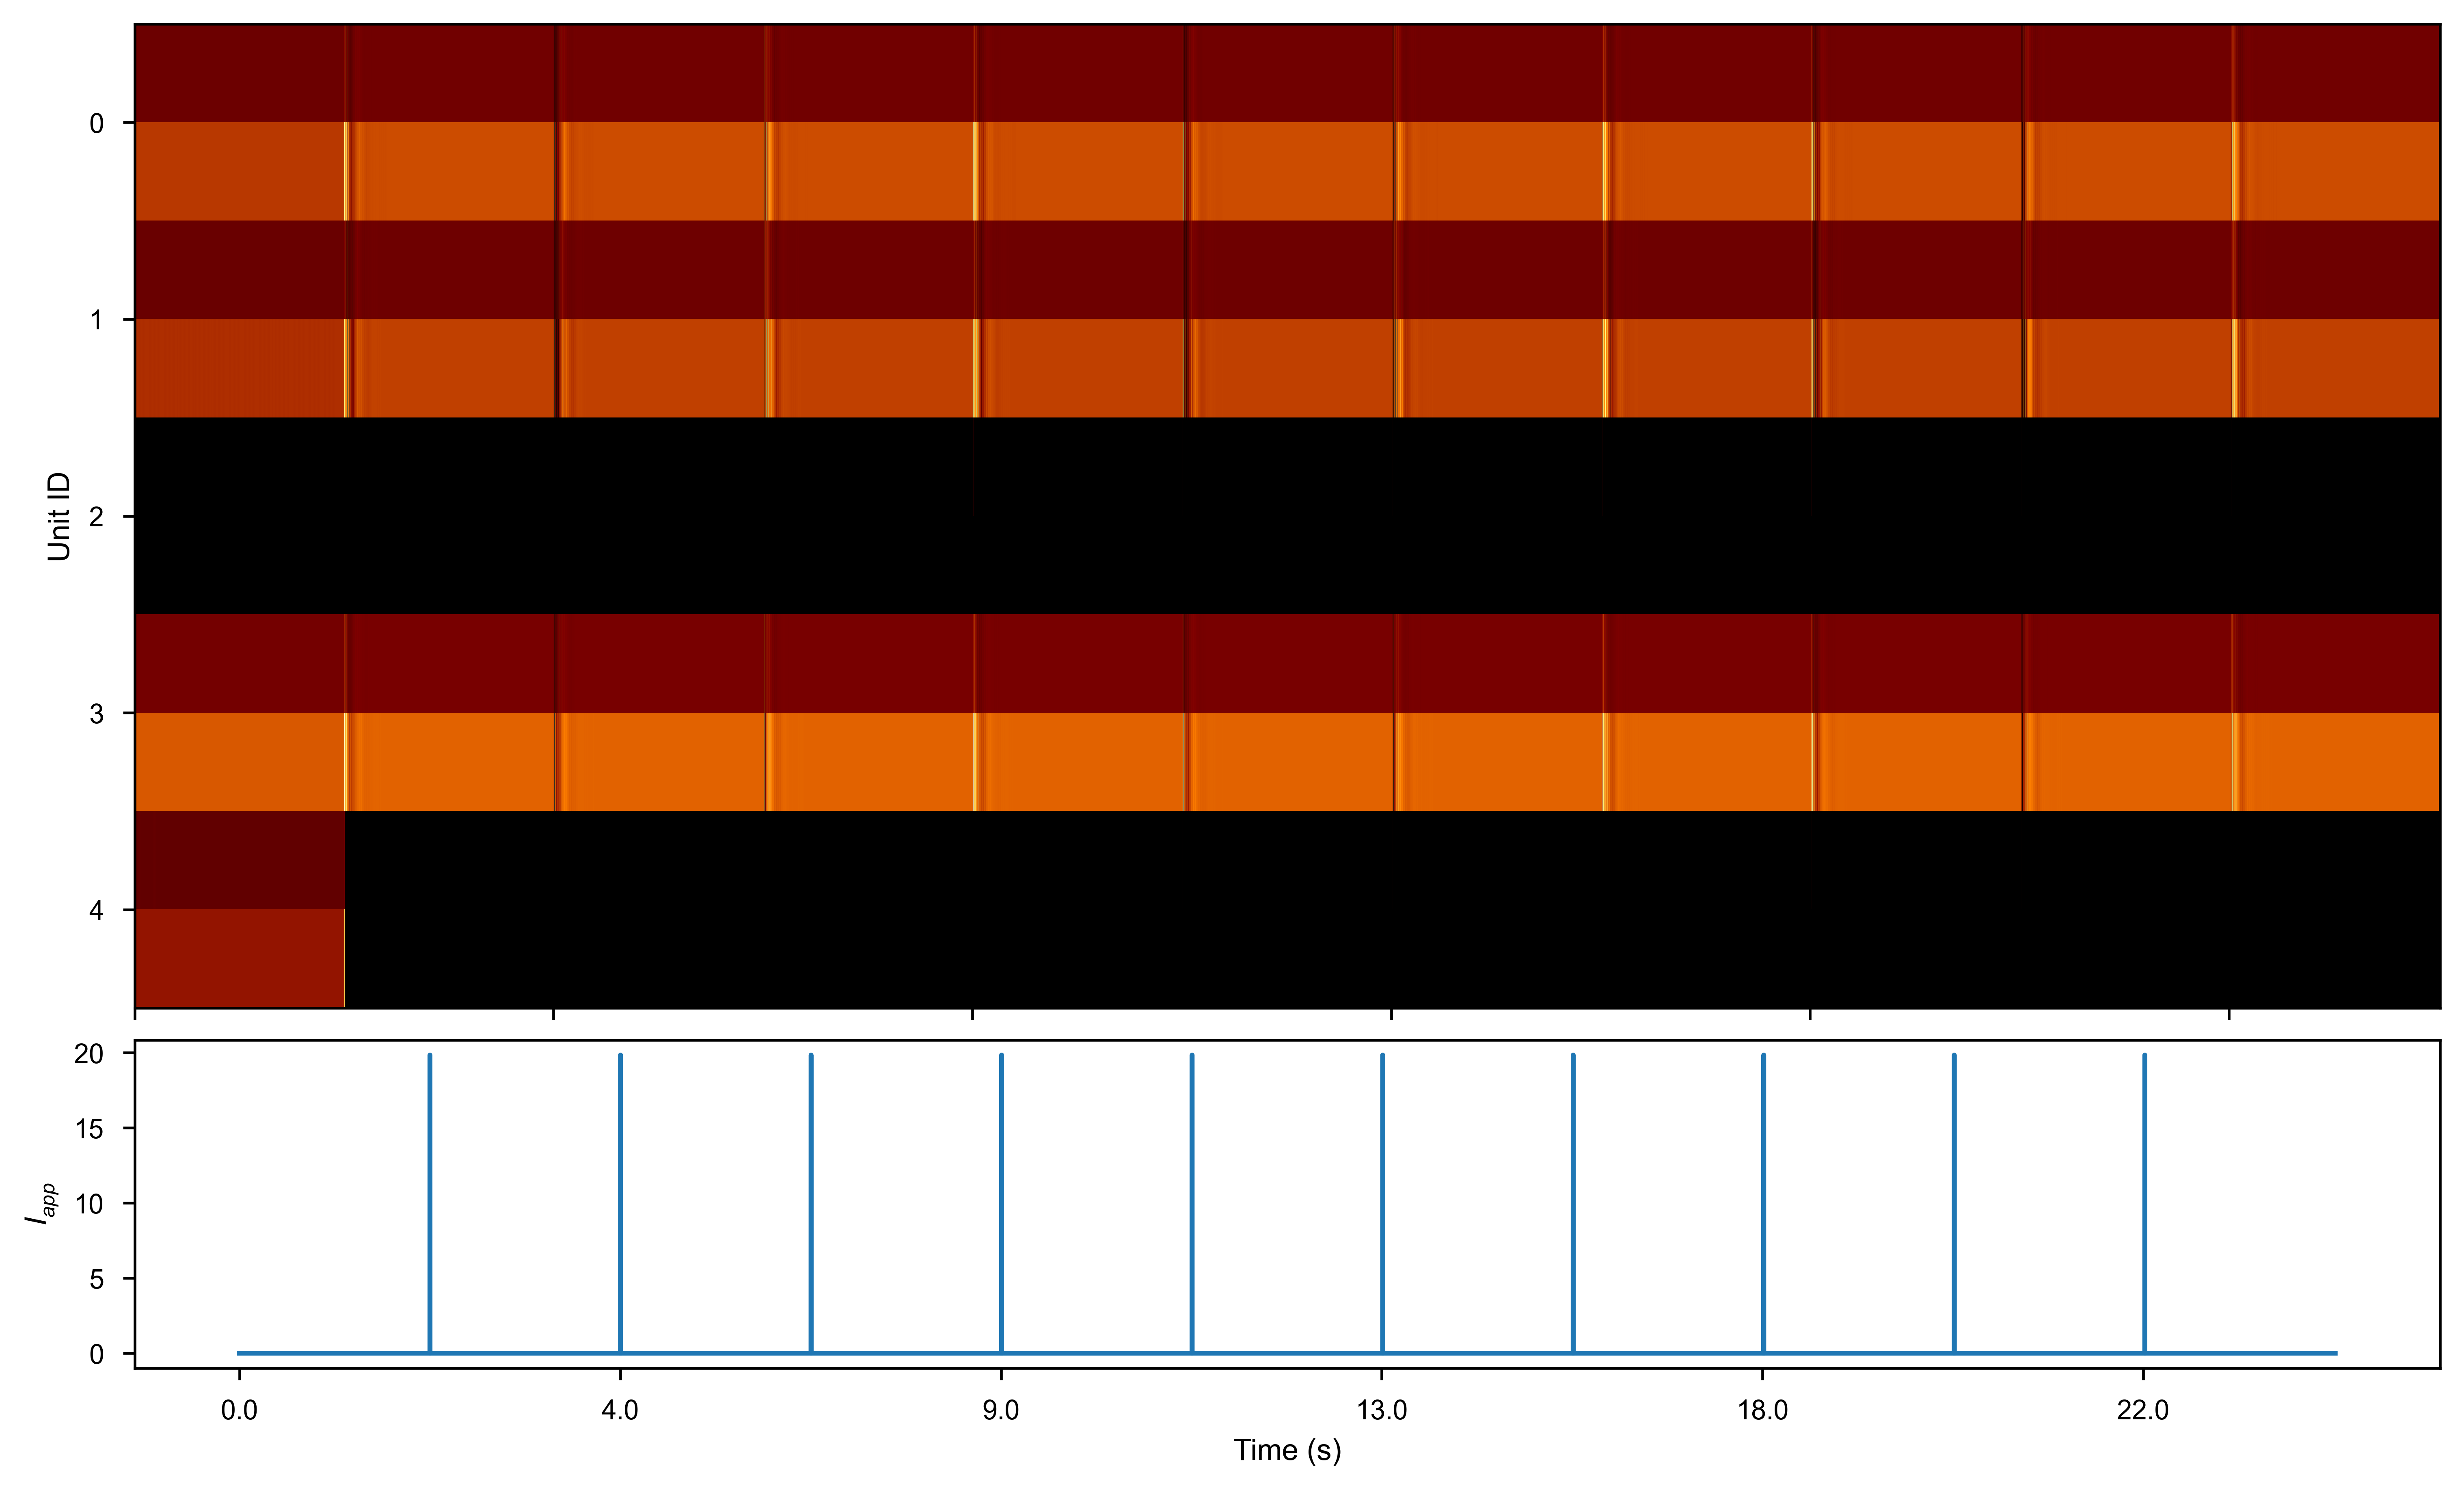

State 20


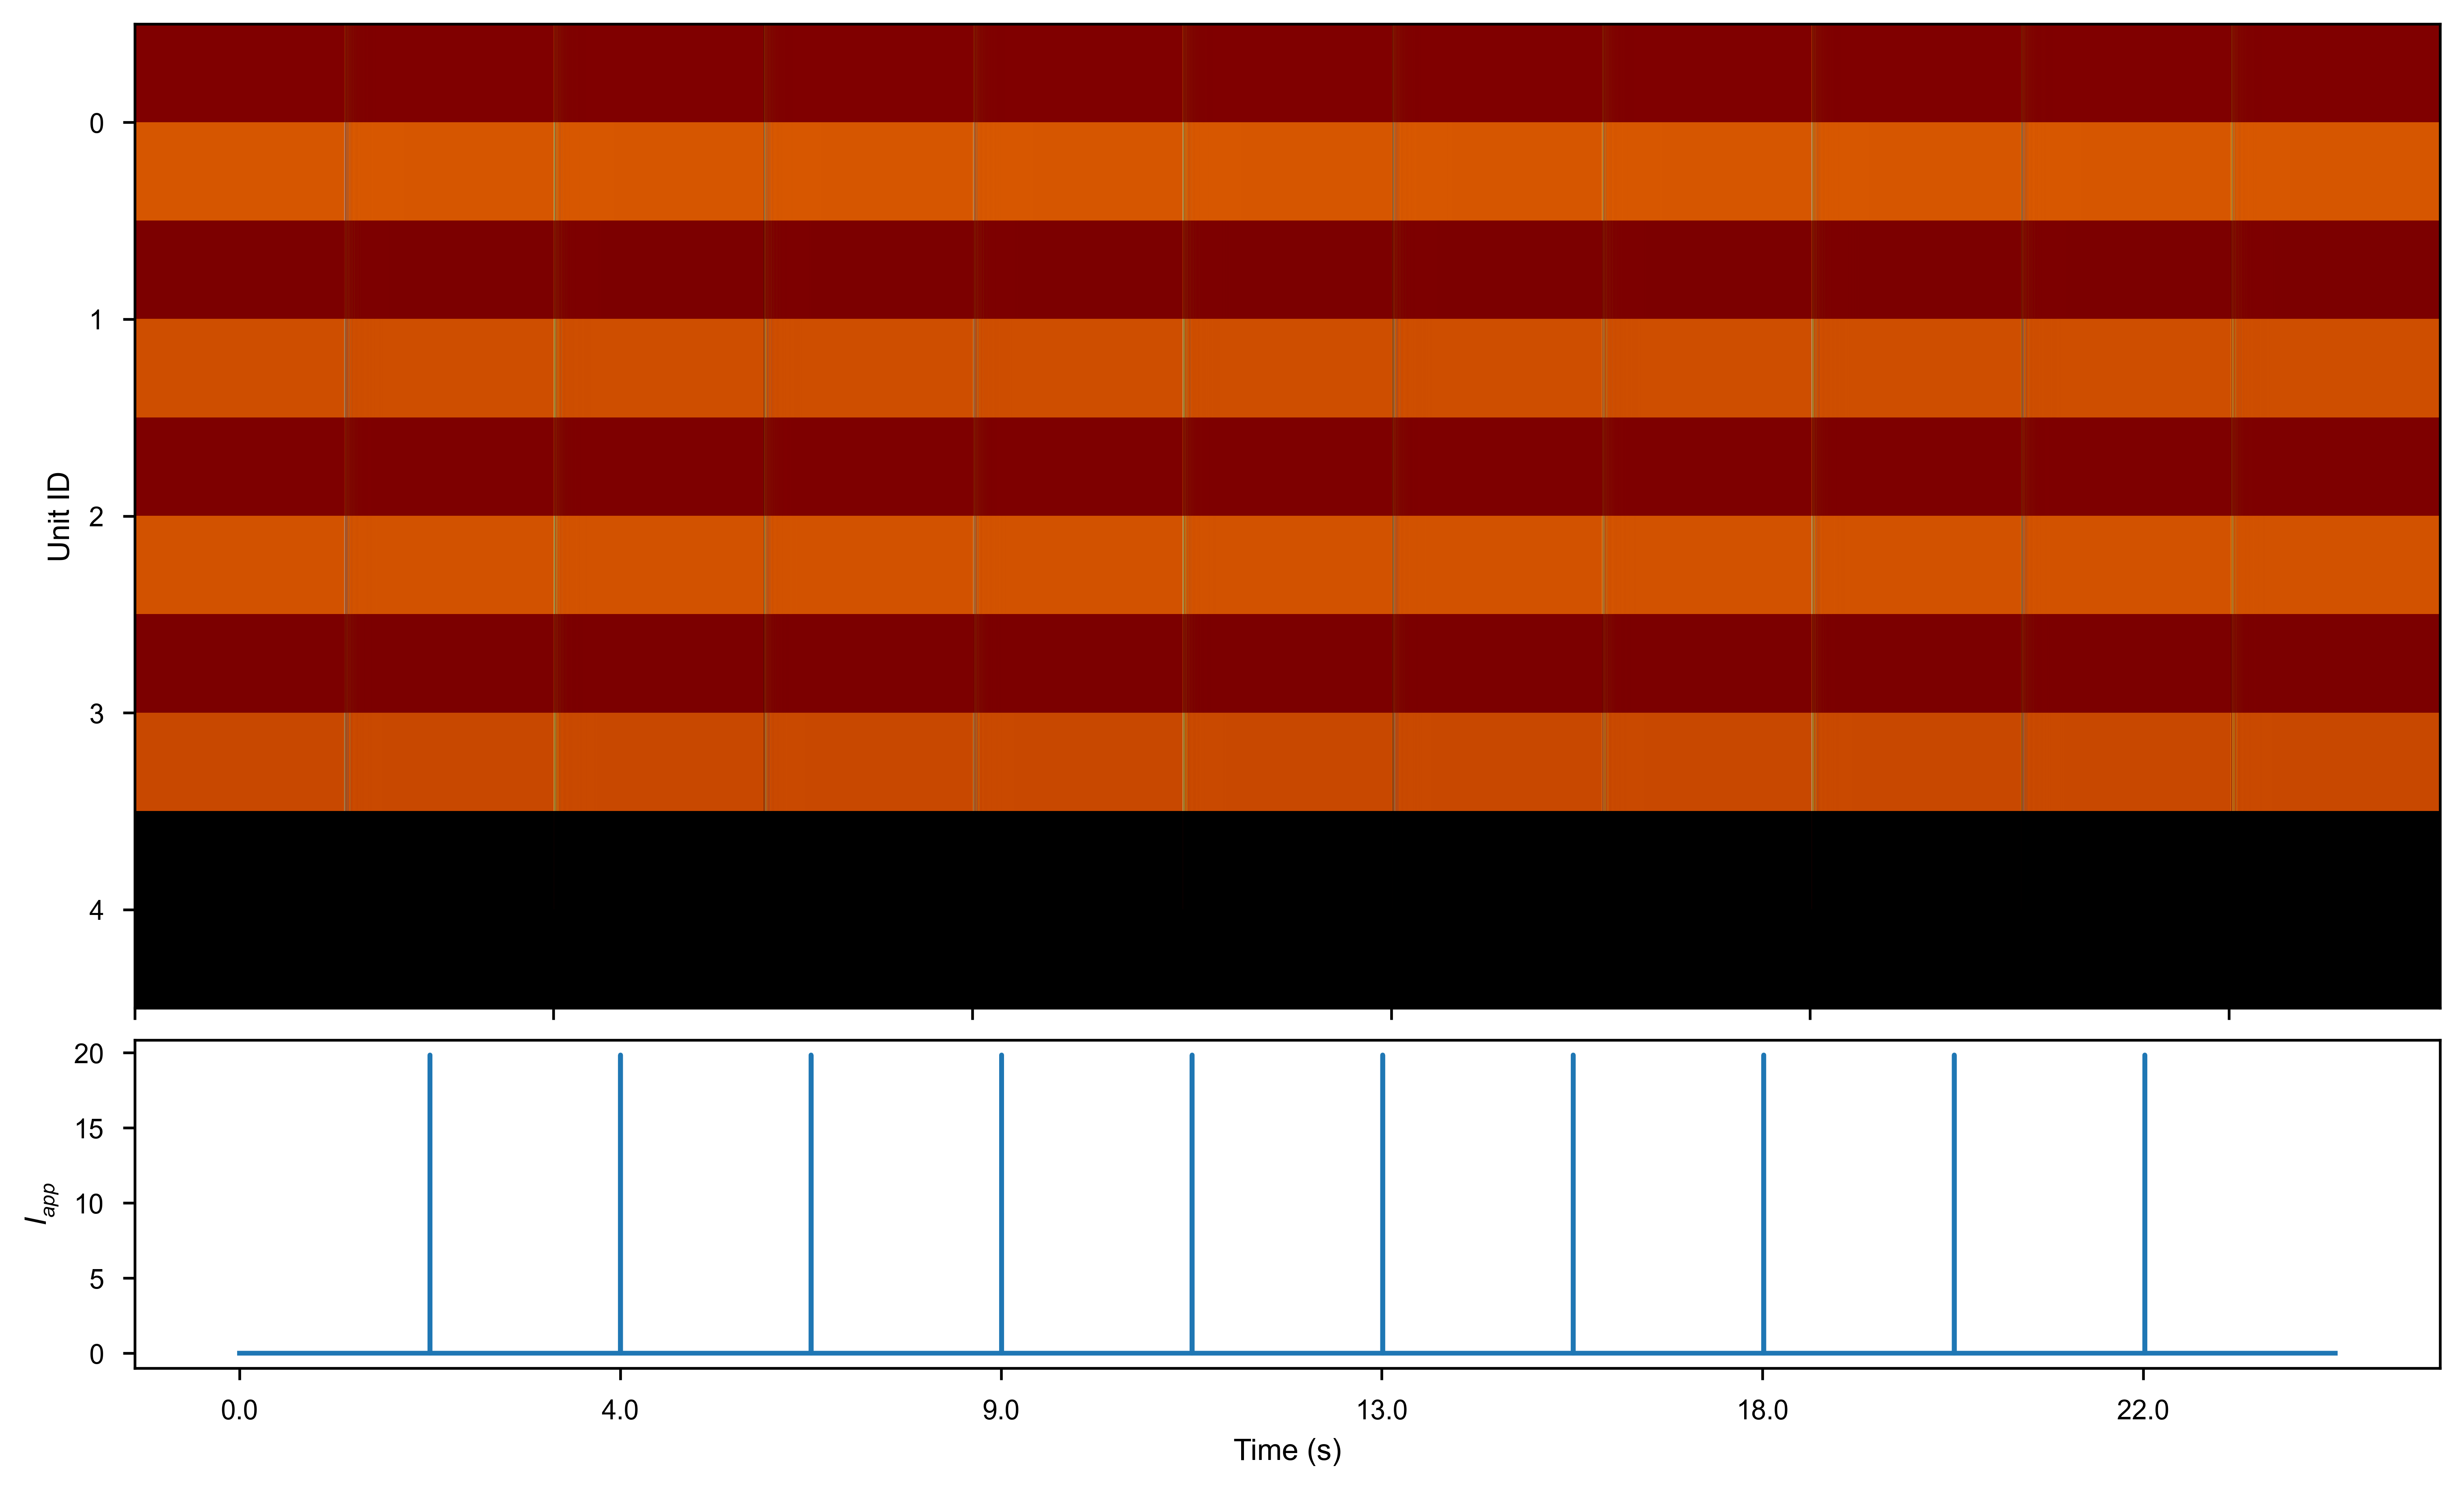

State 21


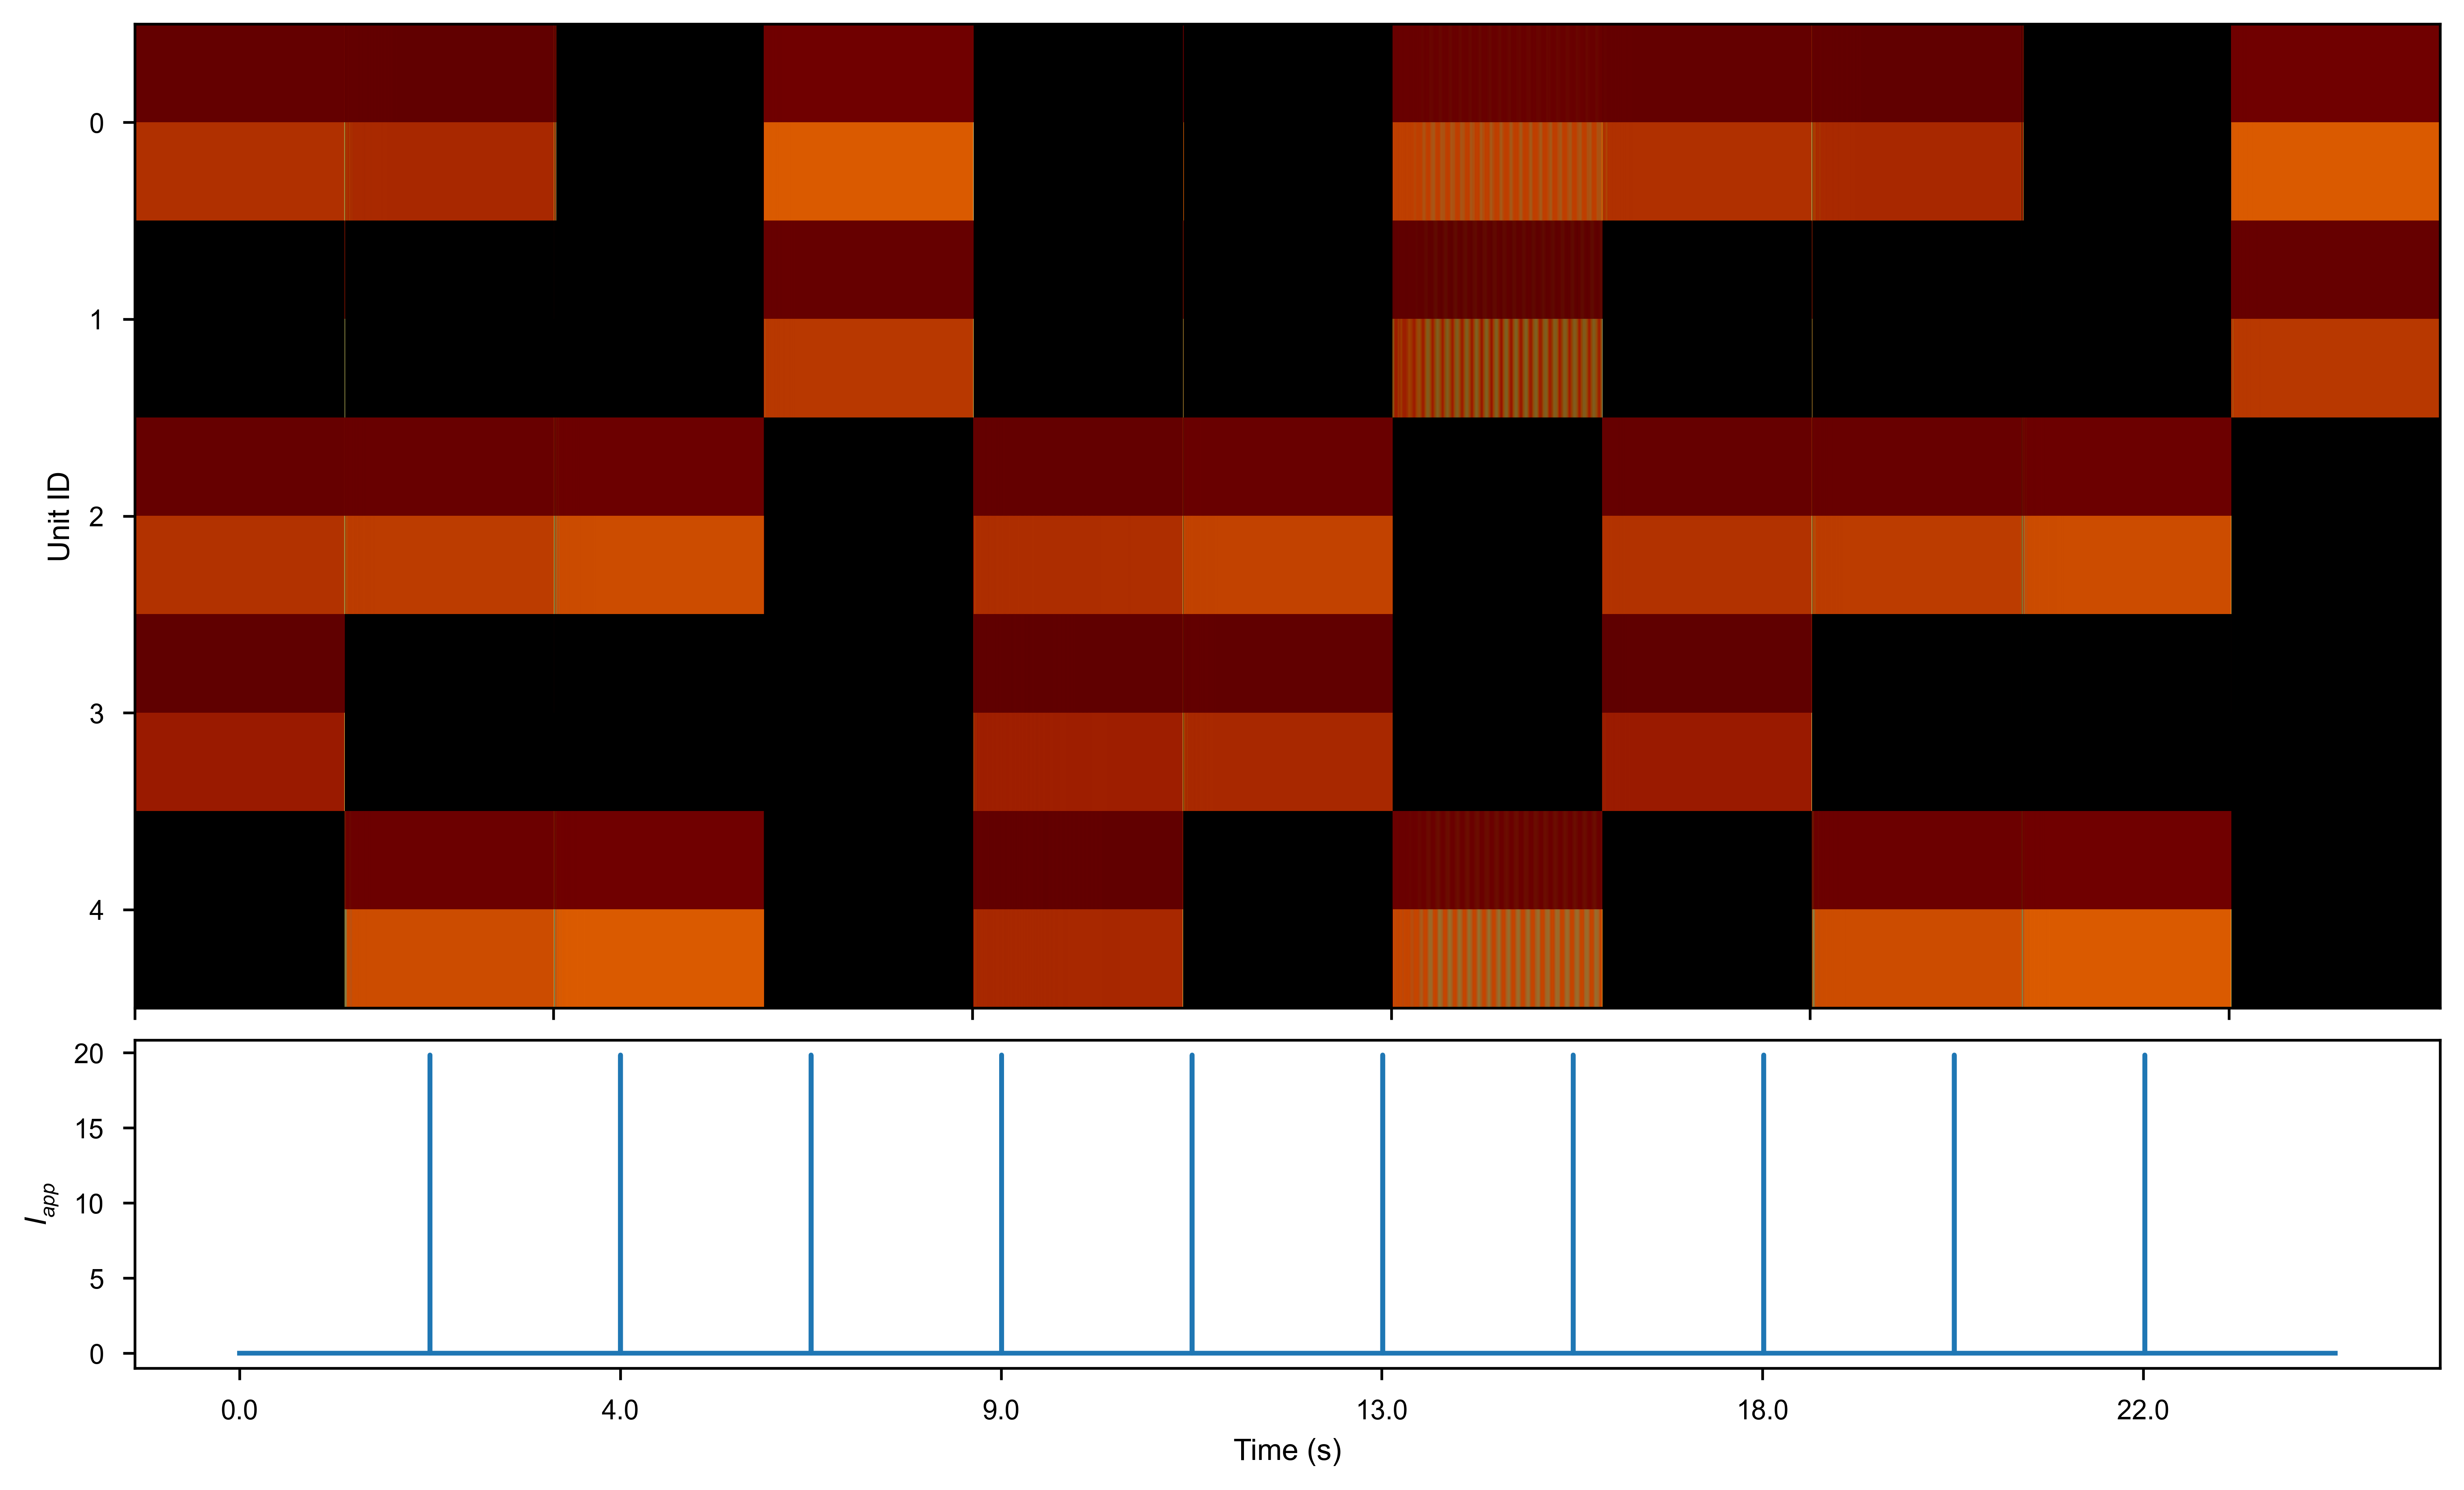

State 22


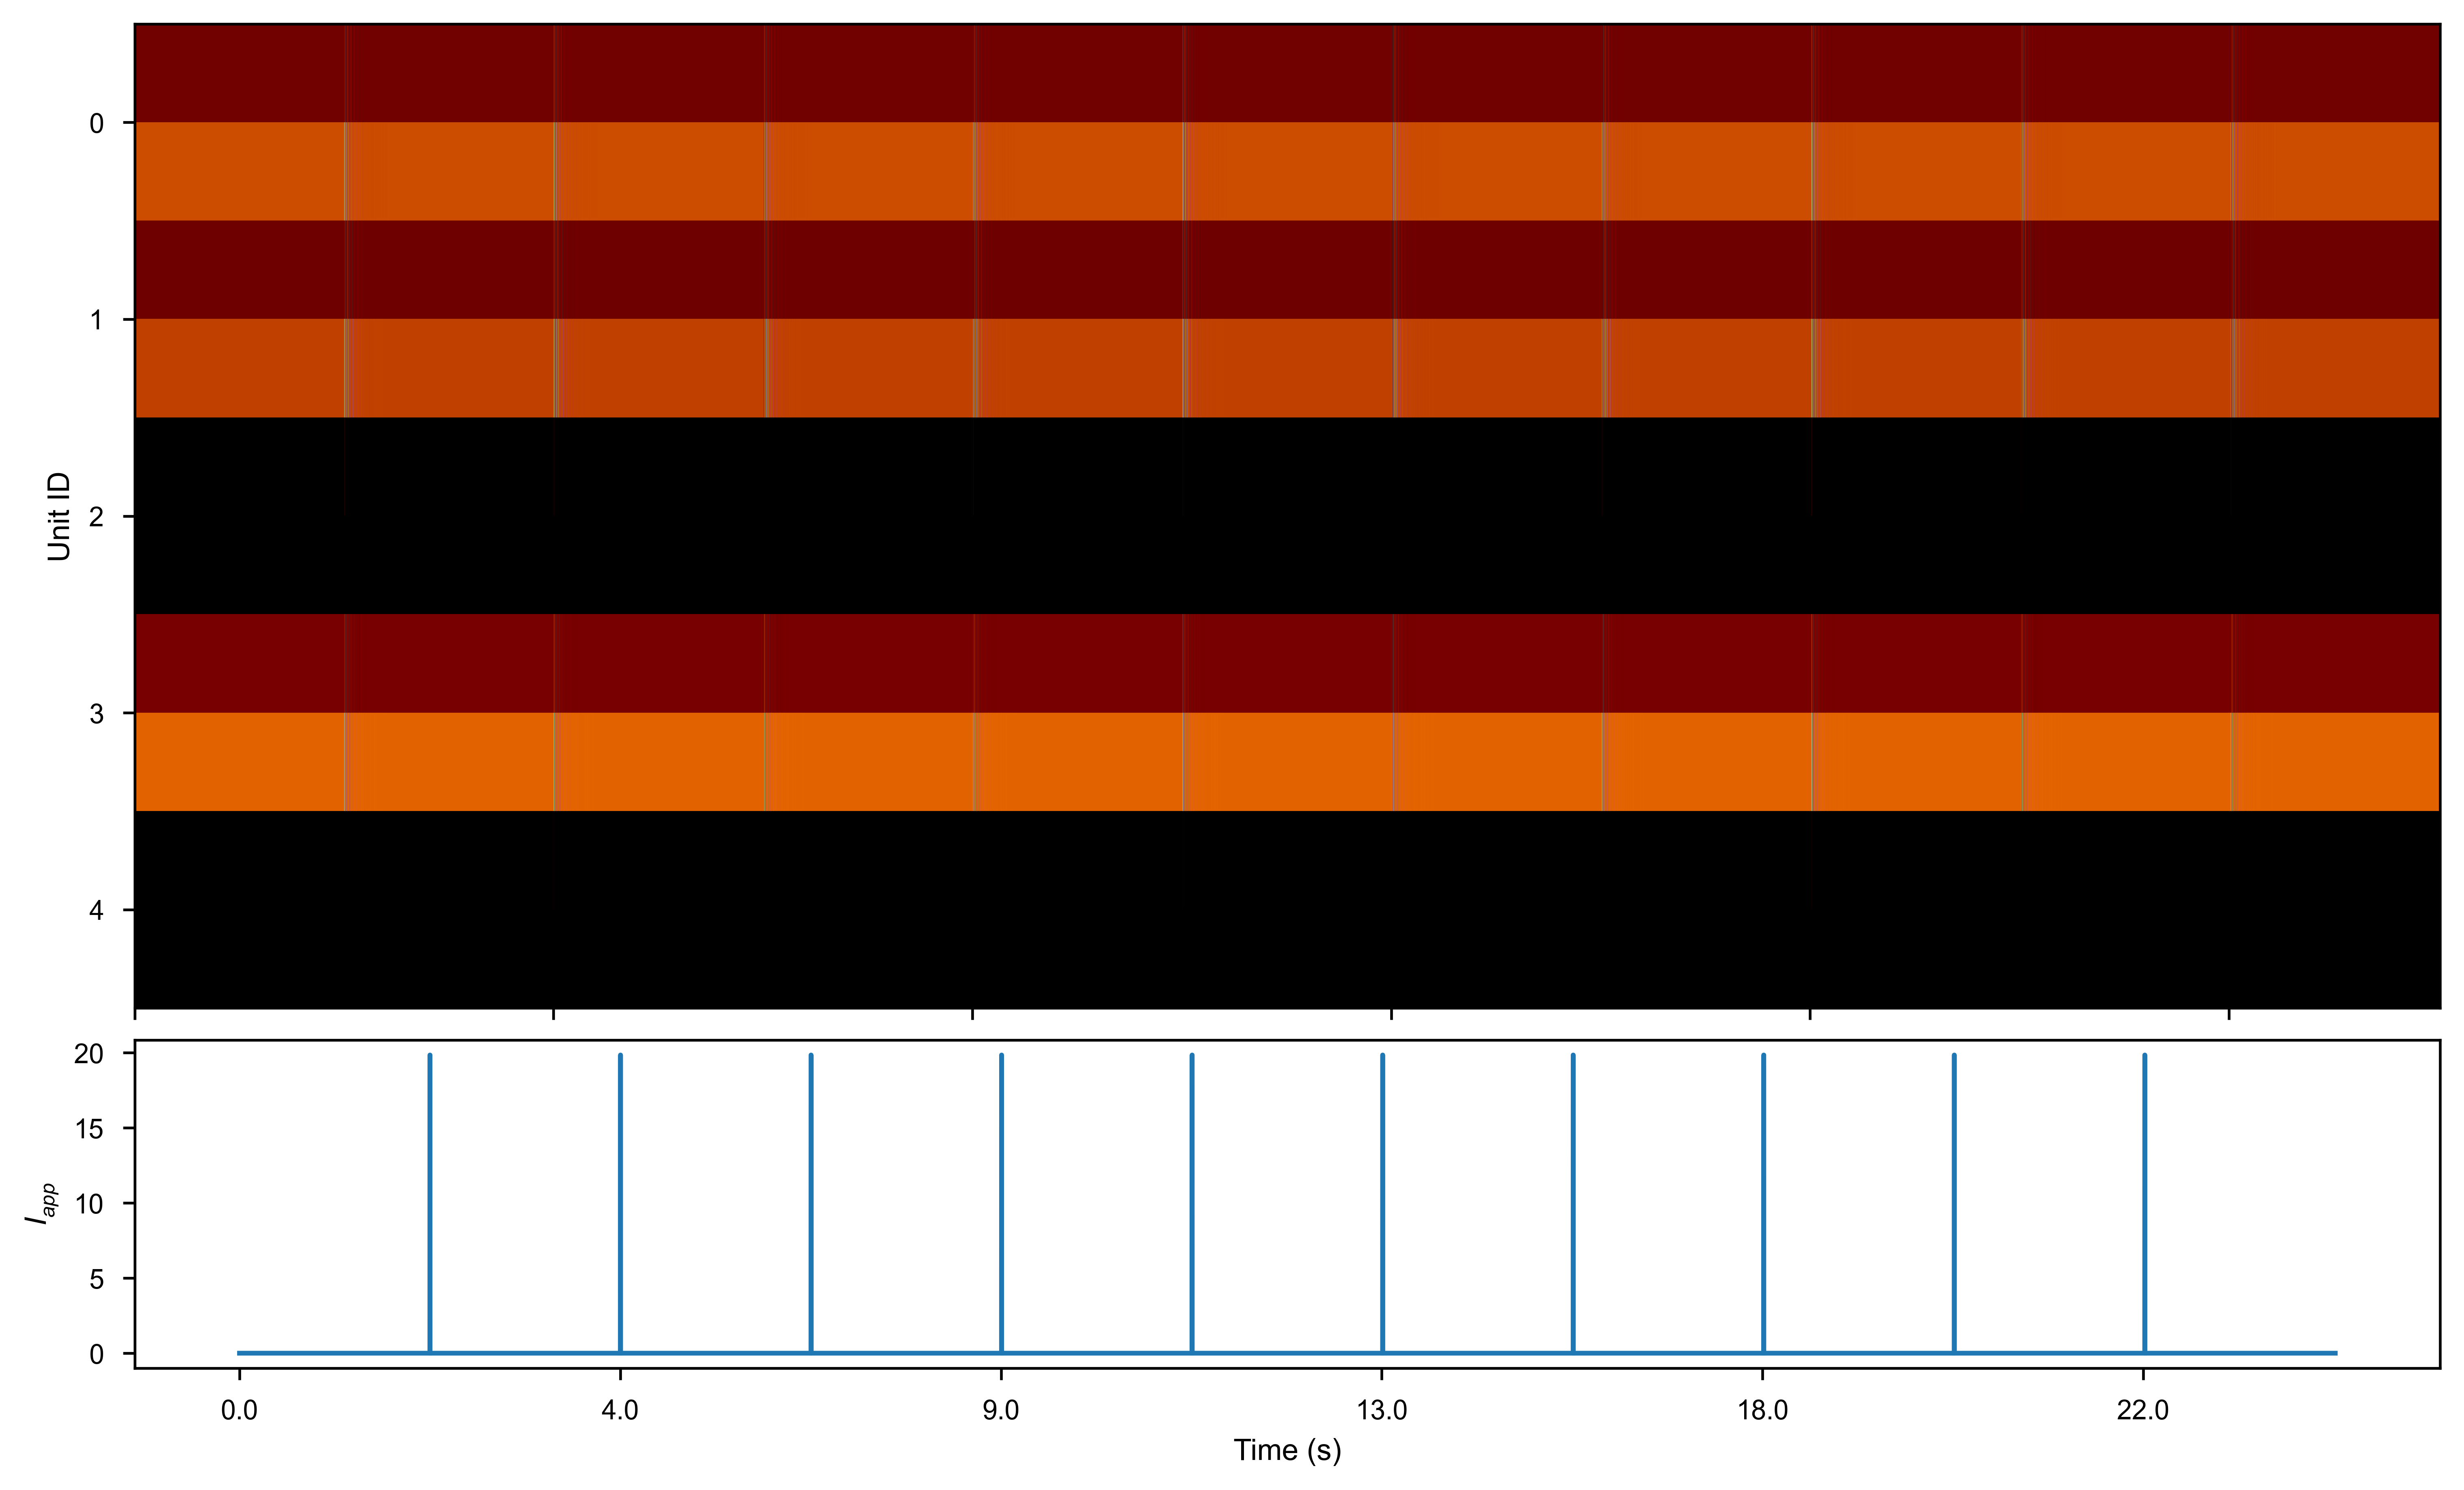

State 23


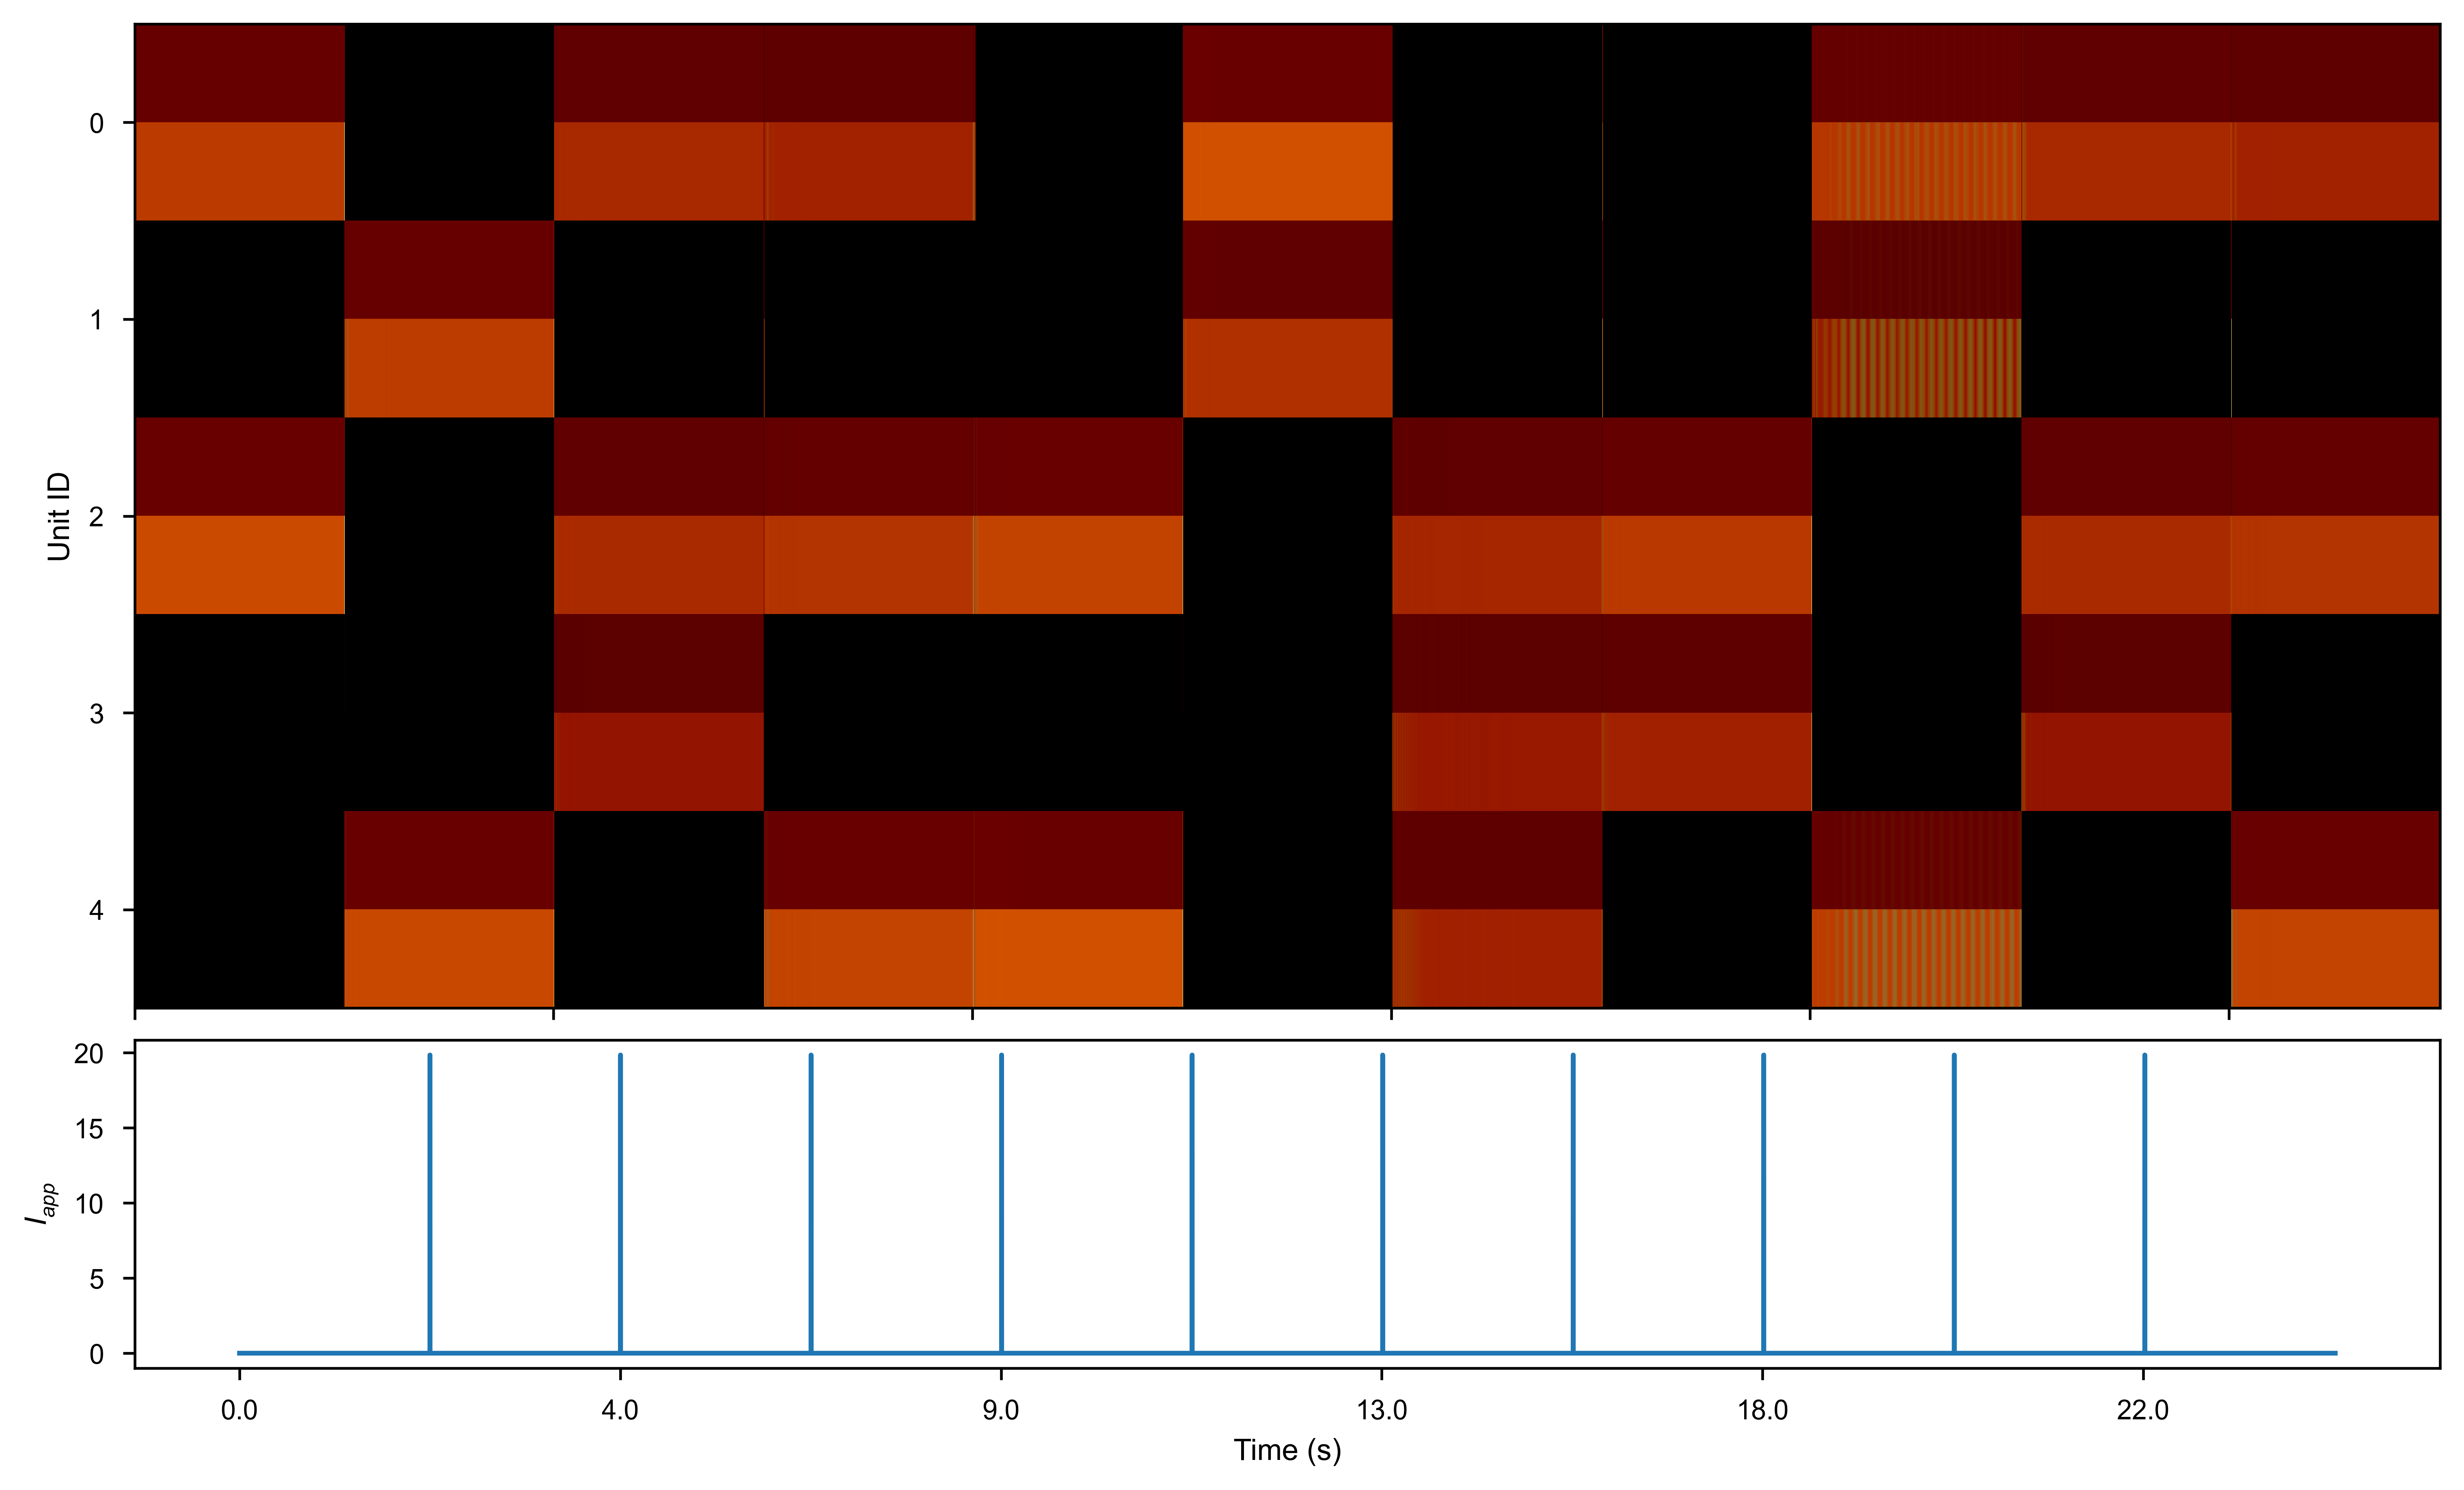

State 24


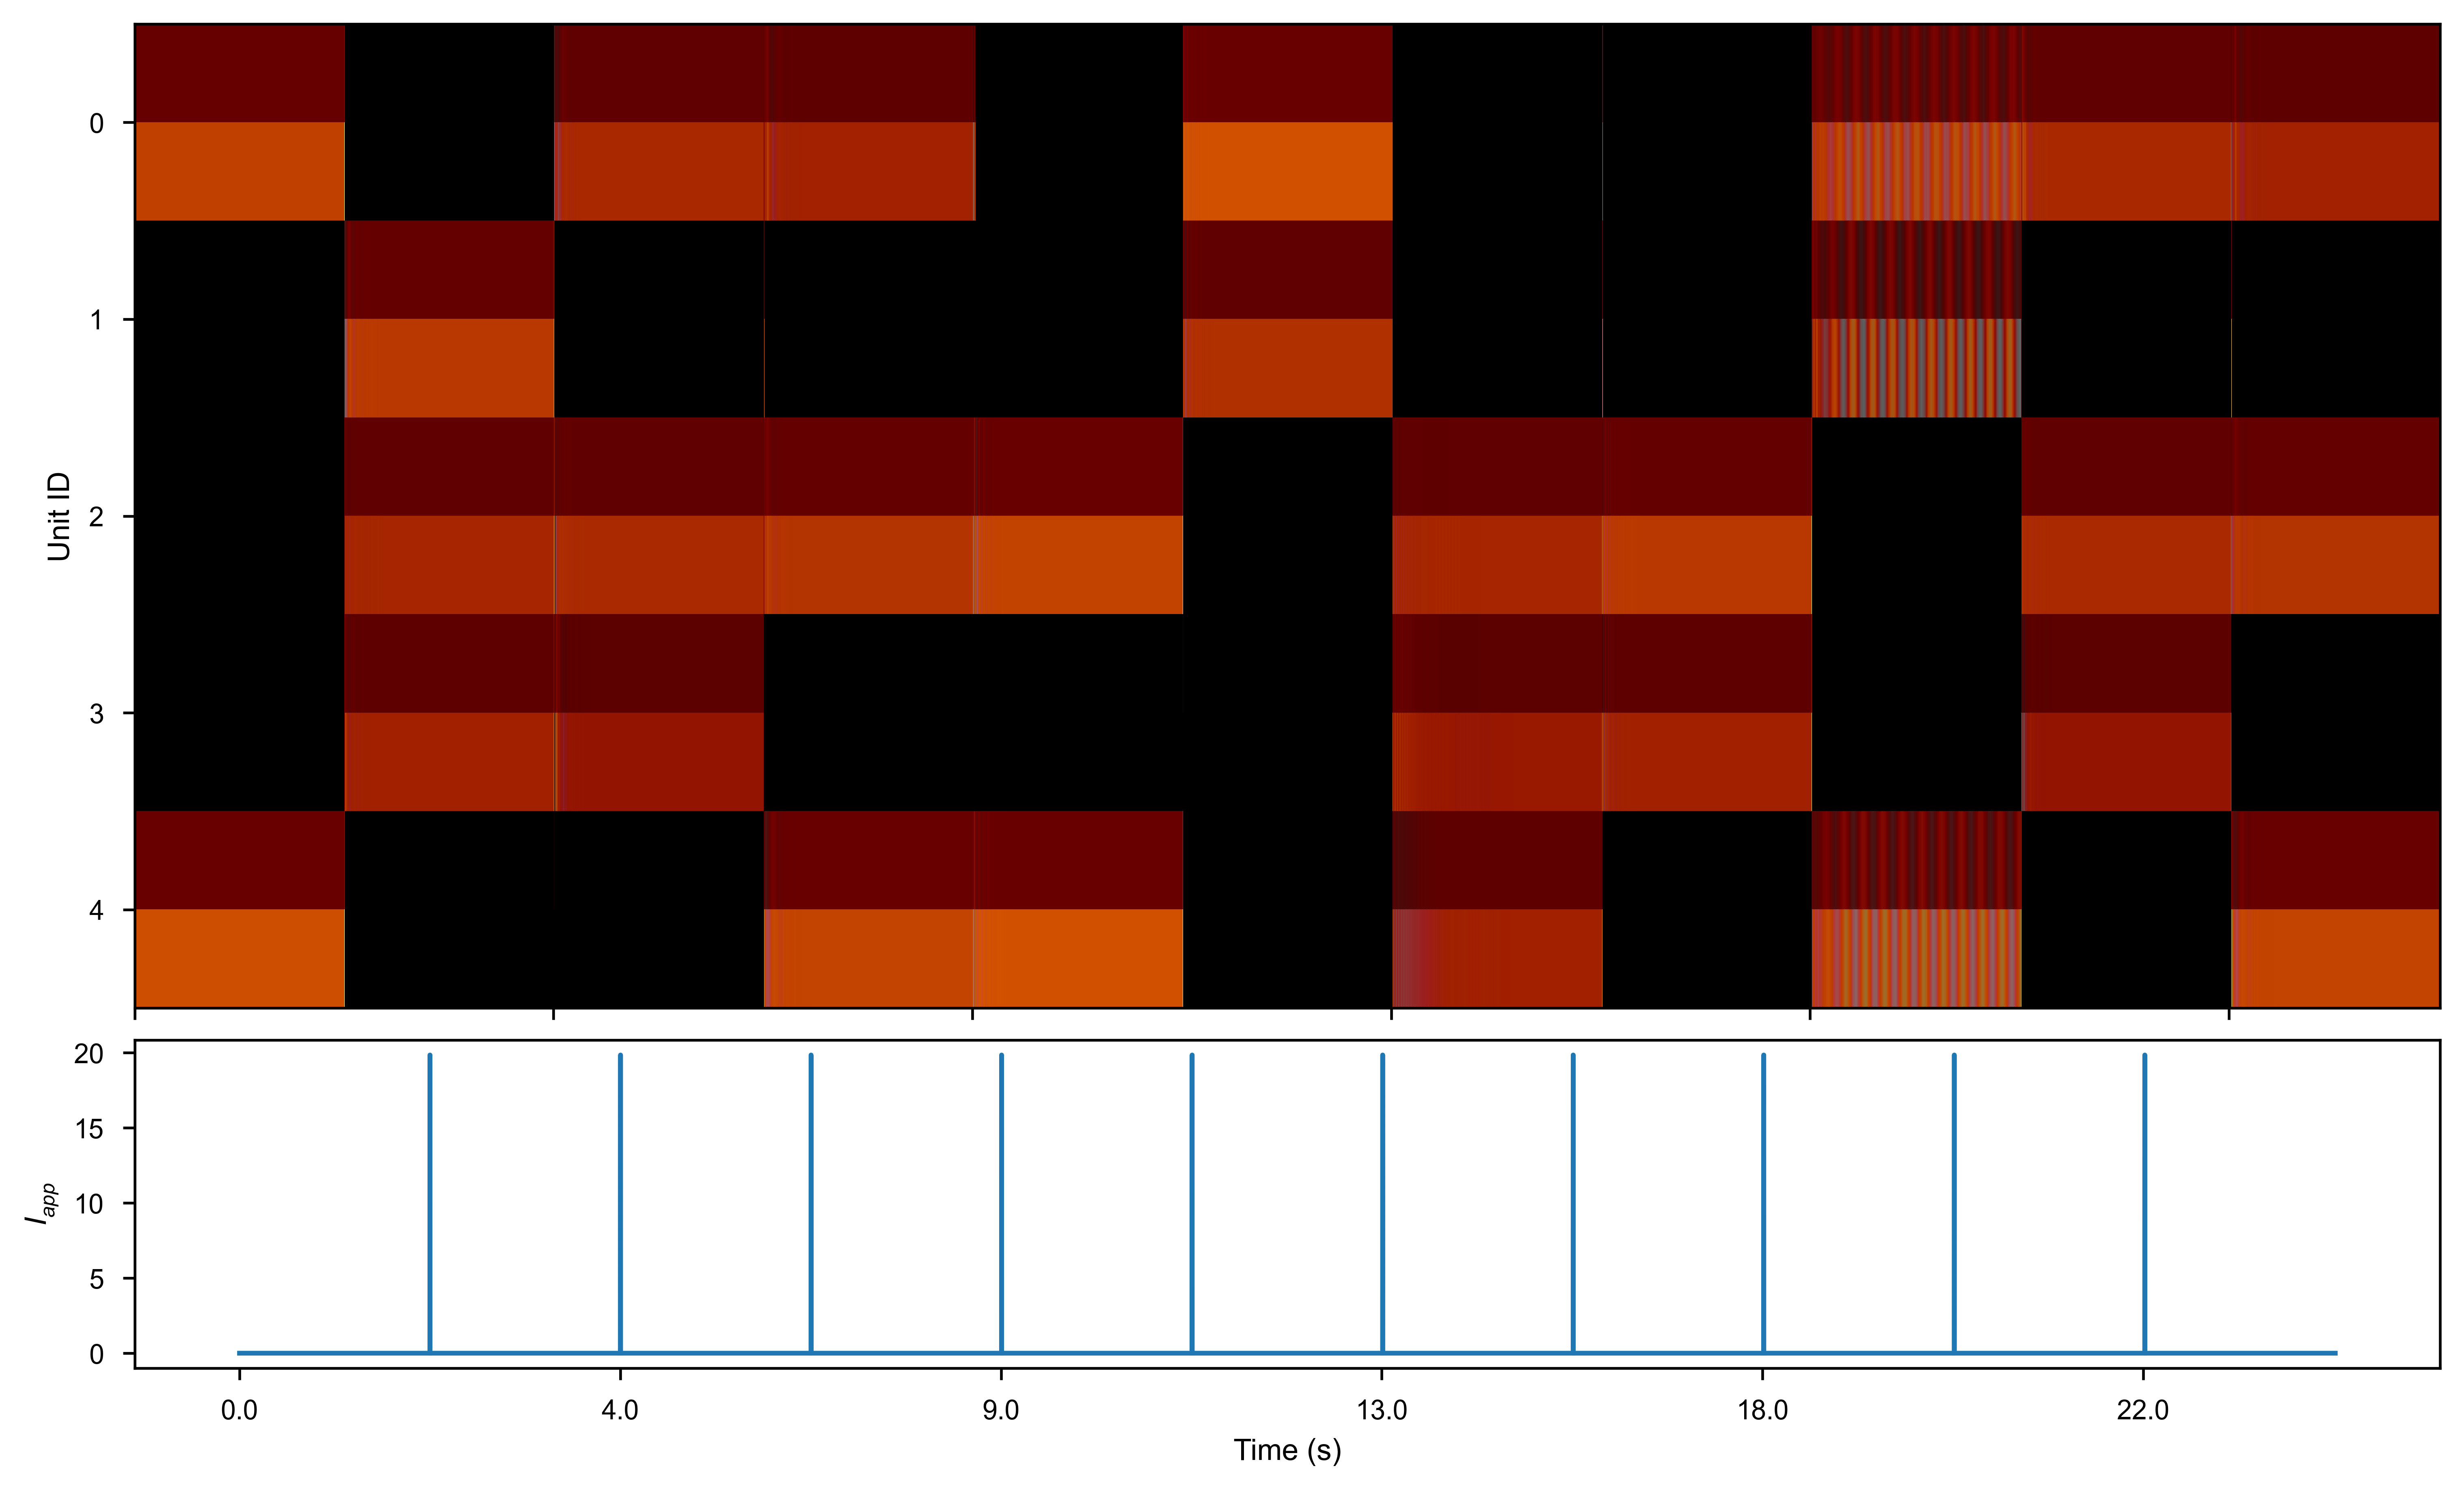

State 25


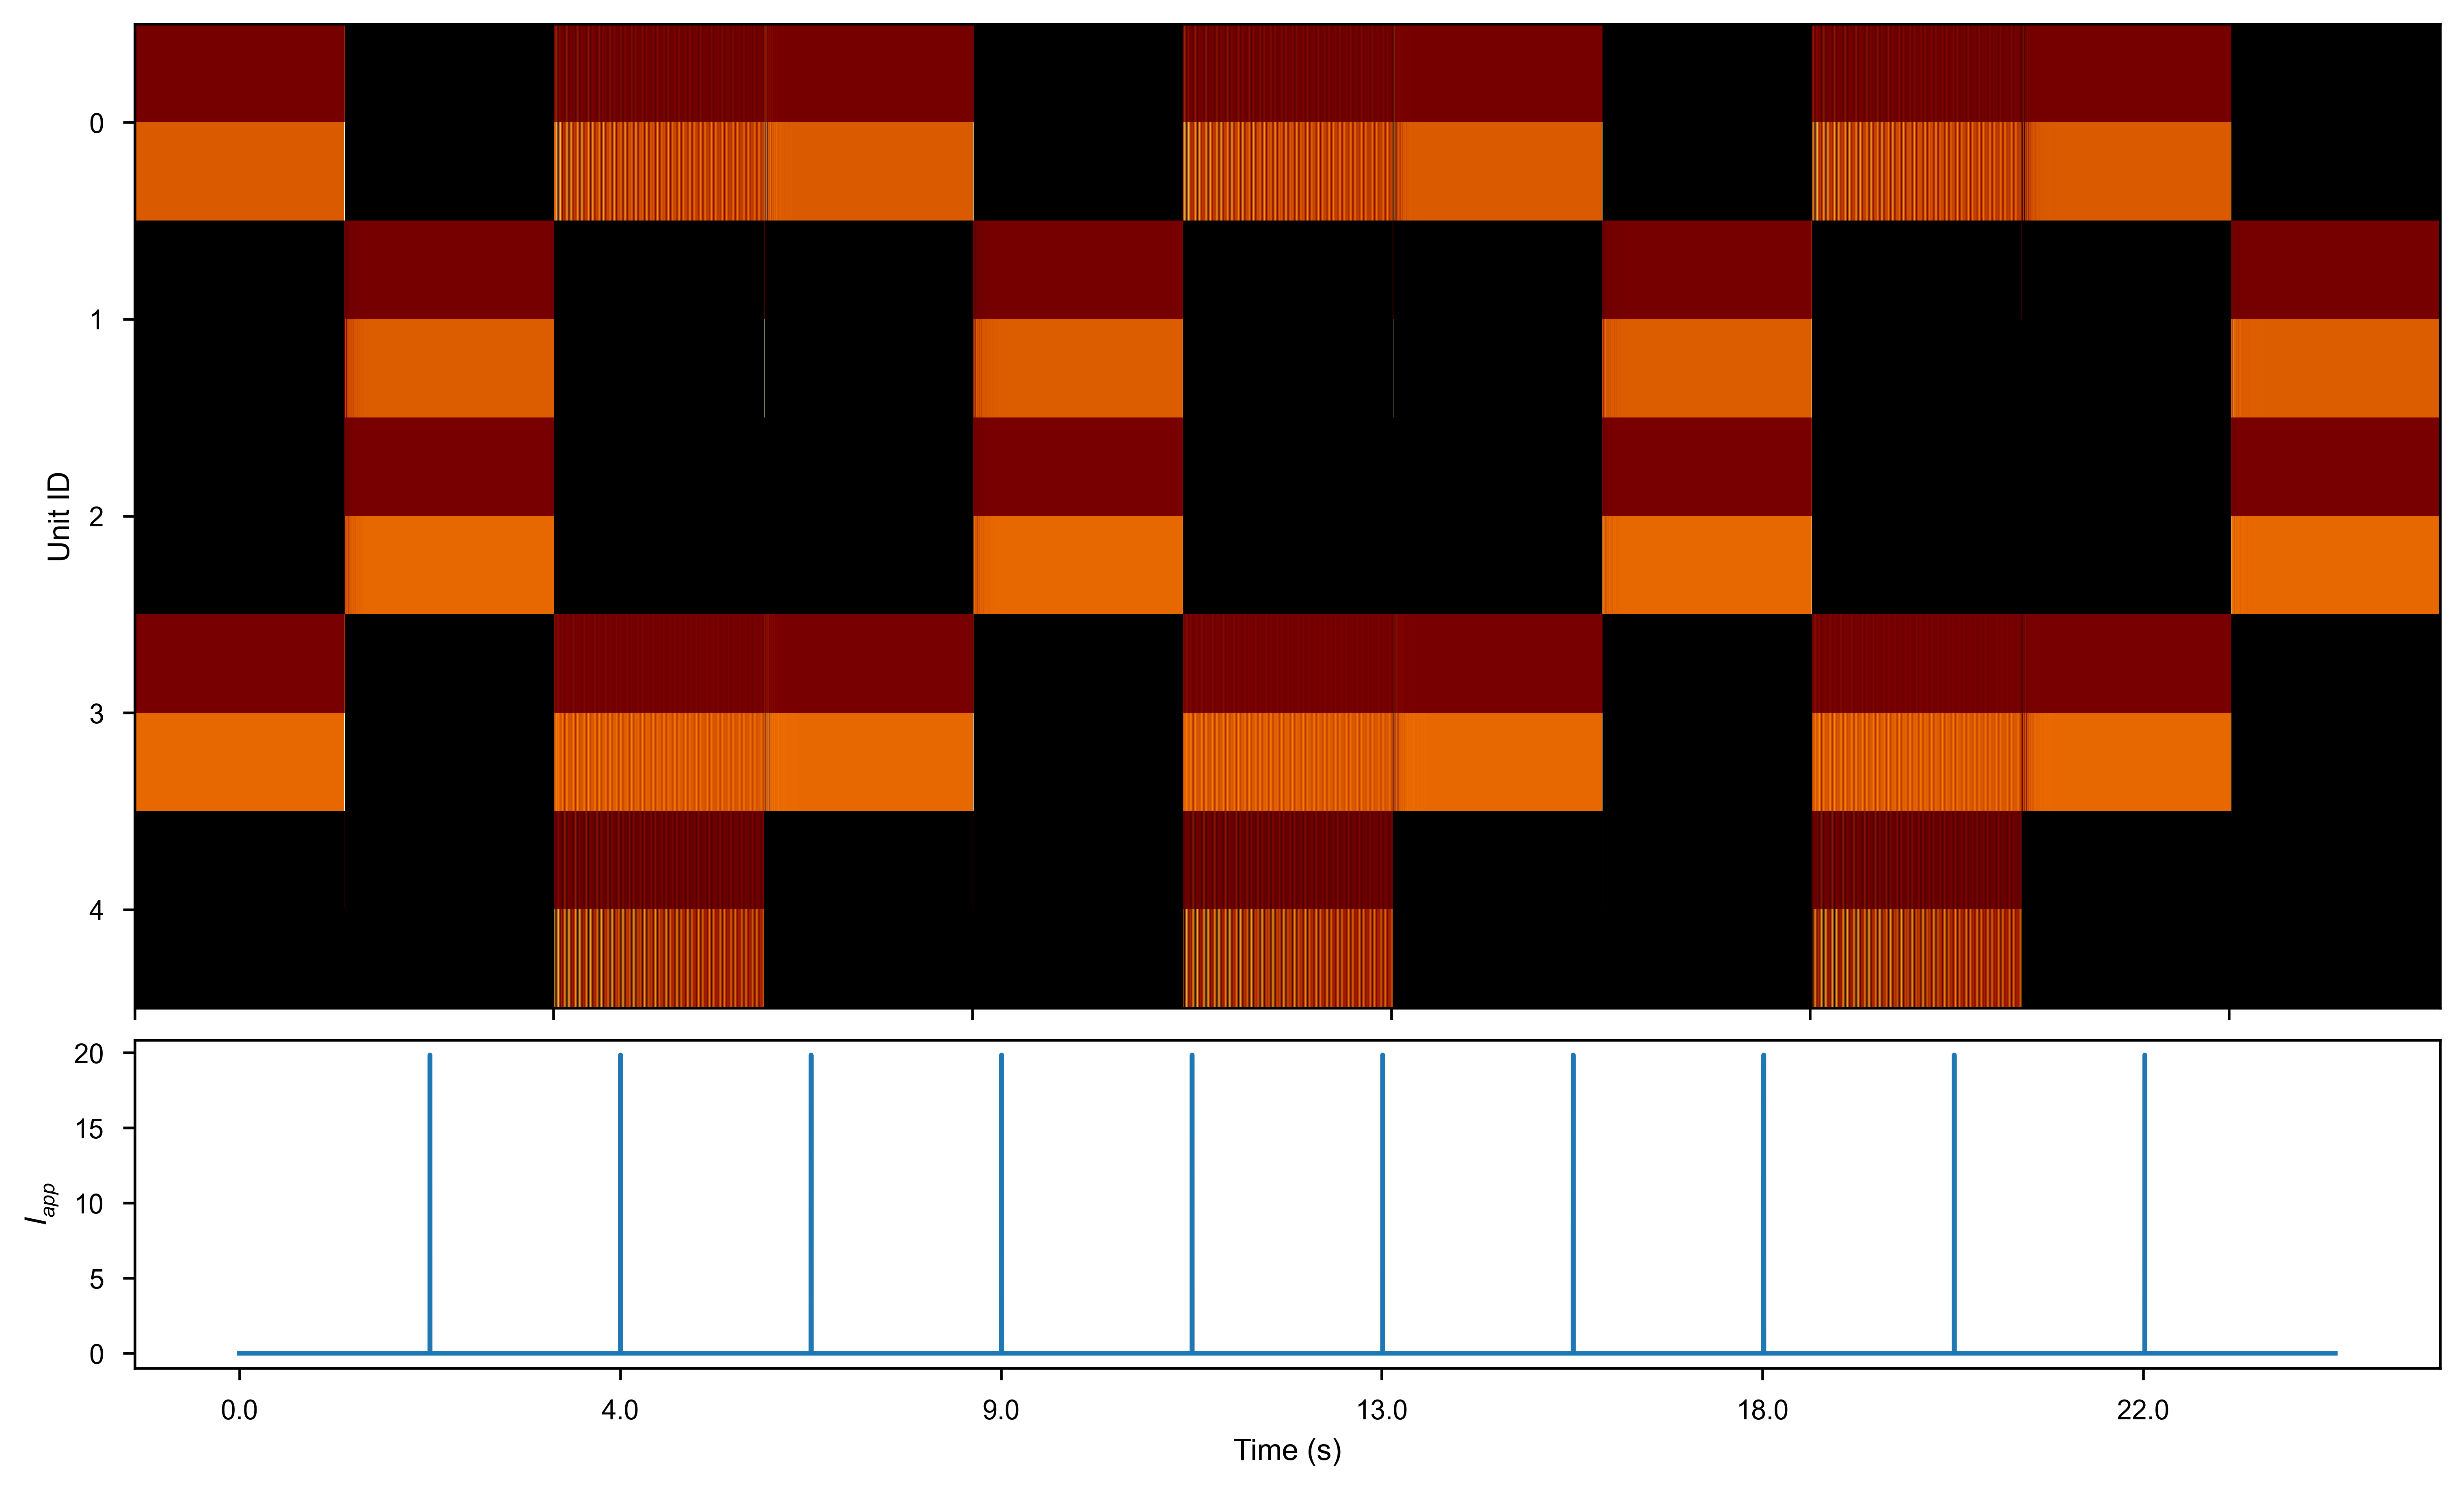

State 26


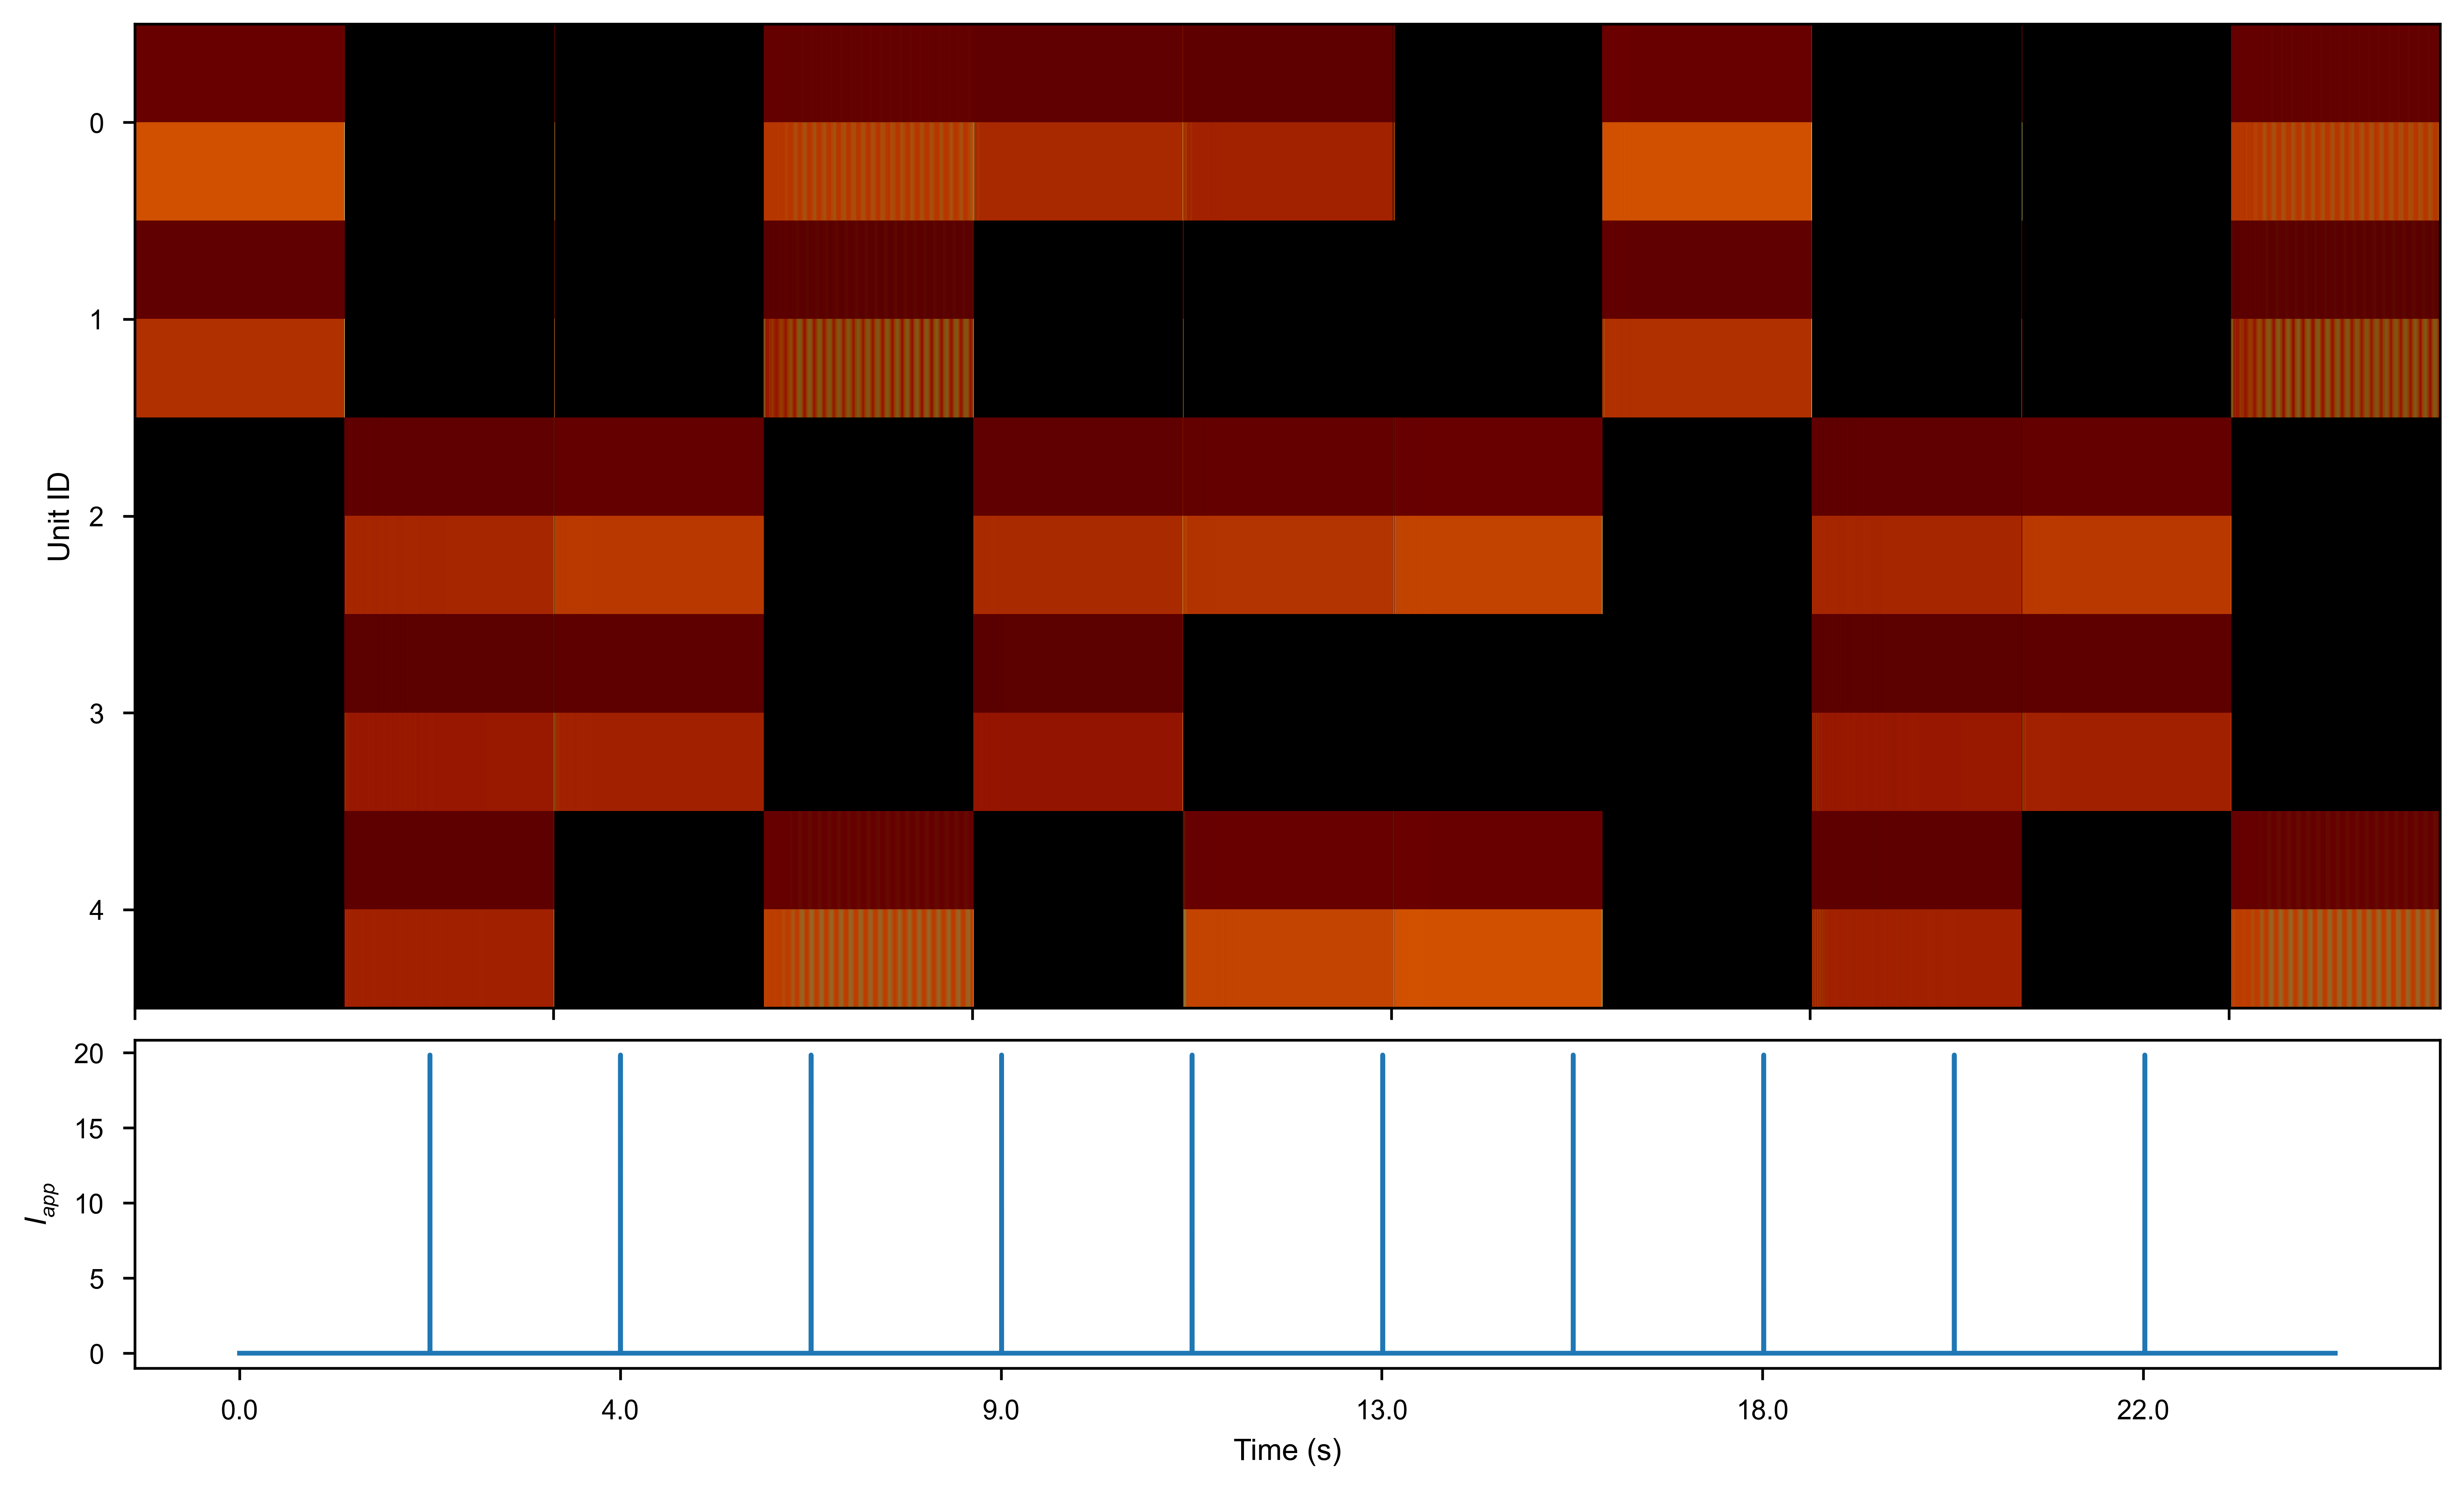

State 27


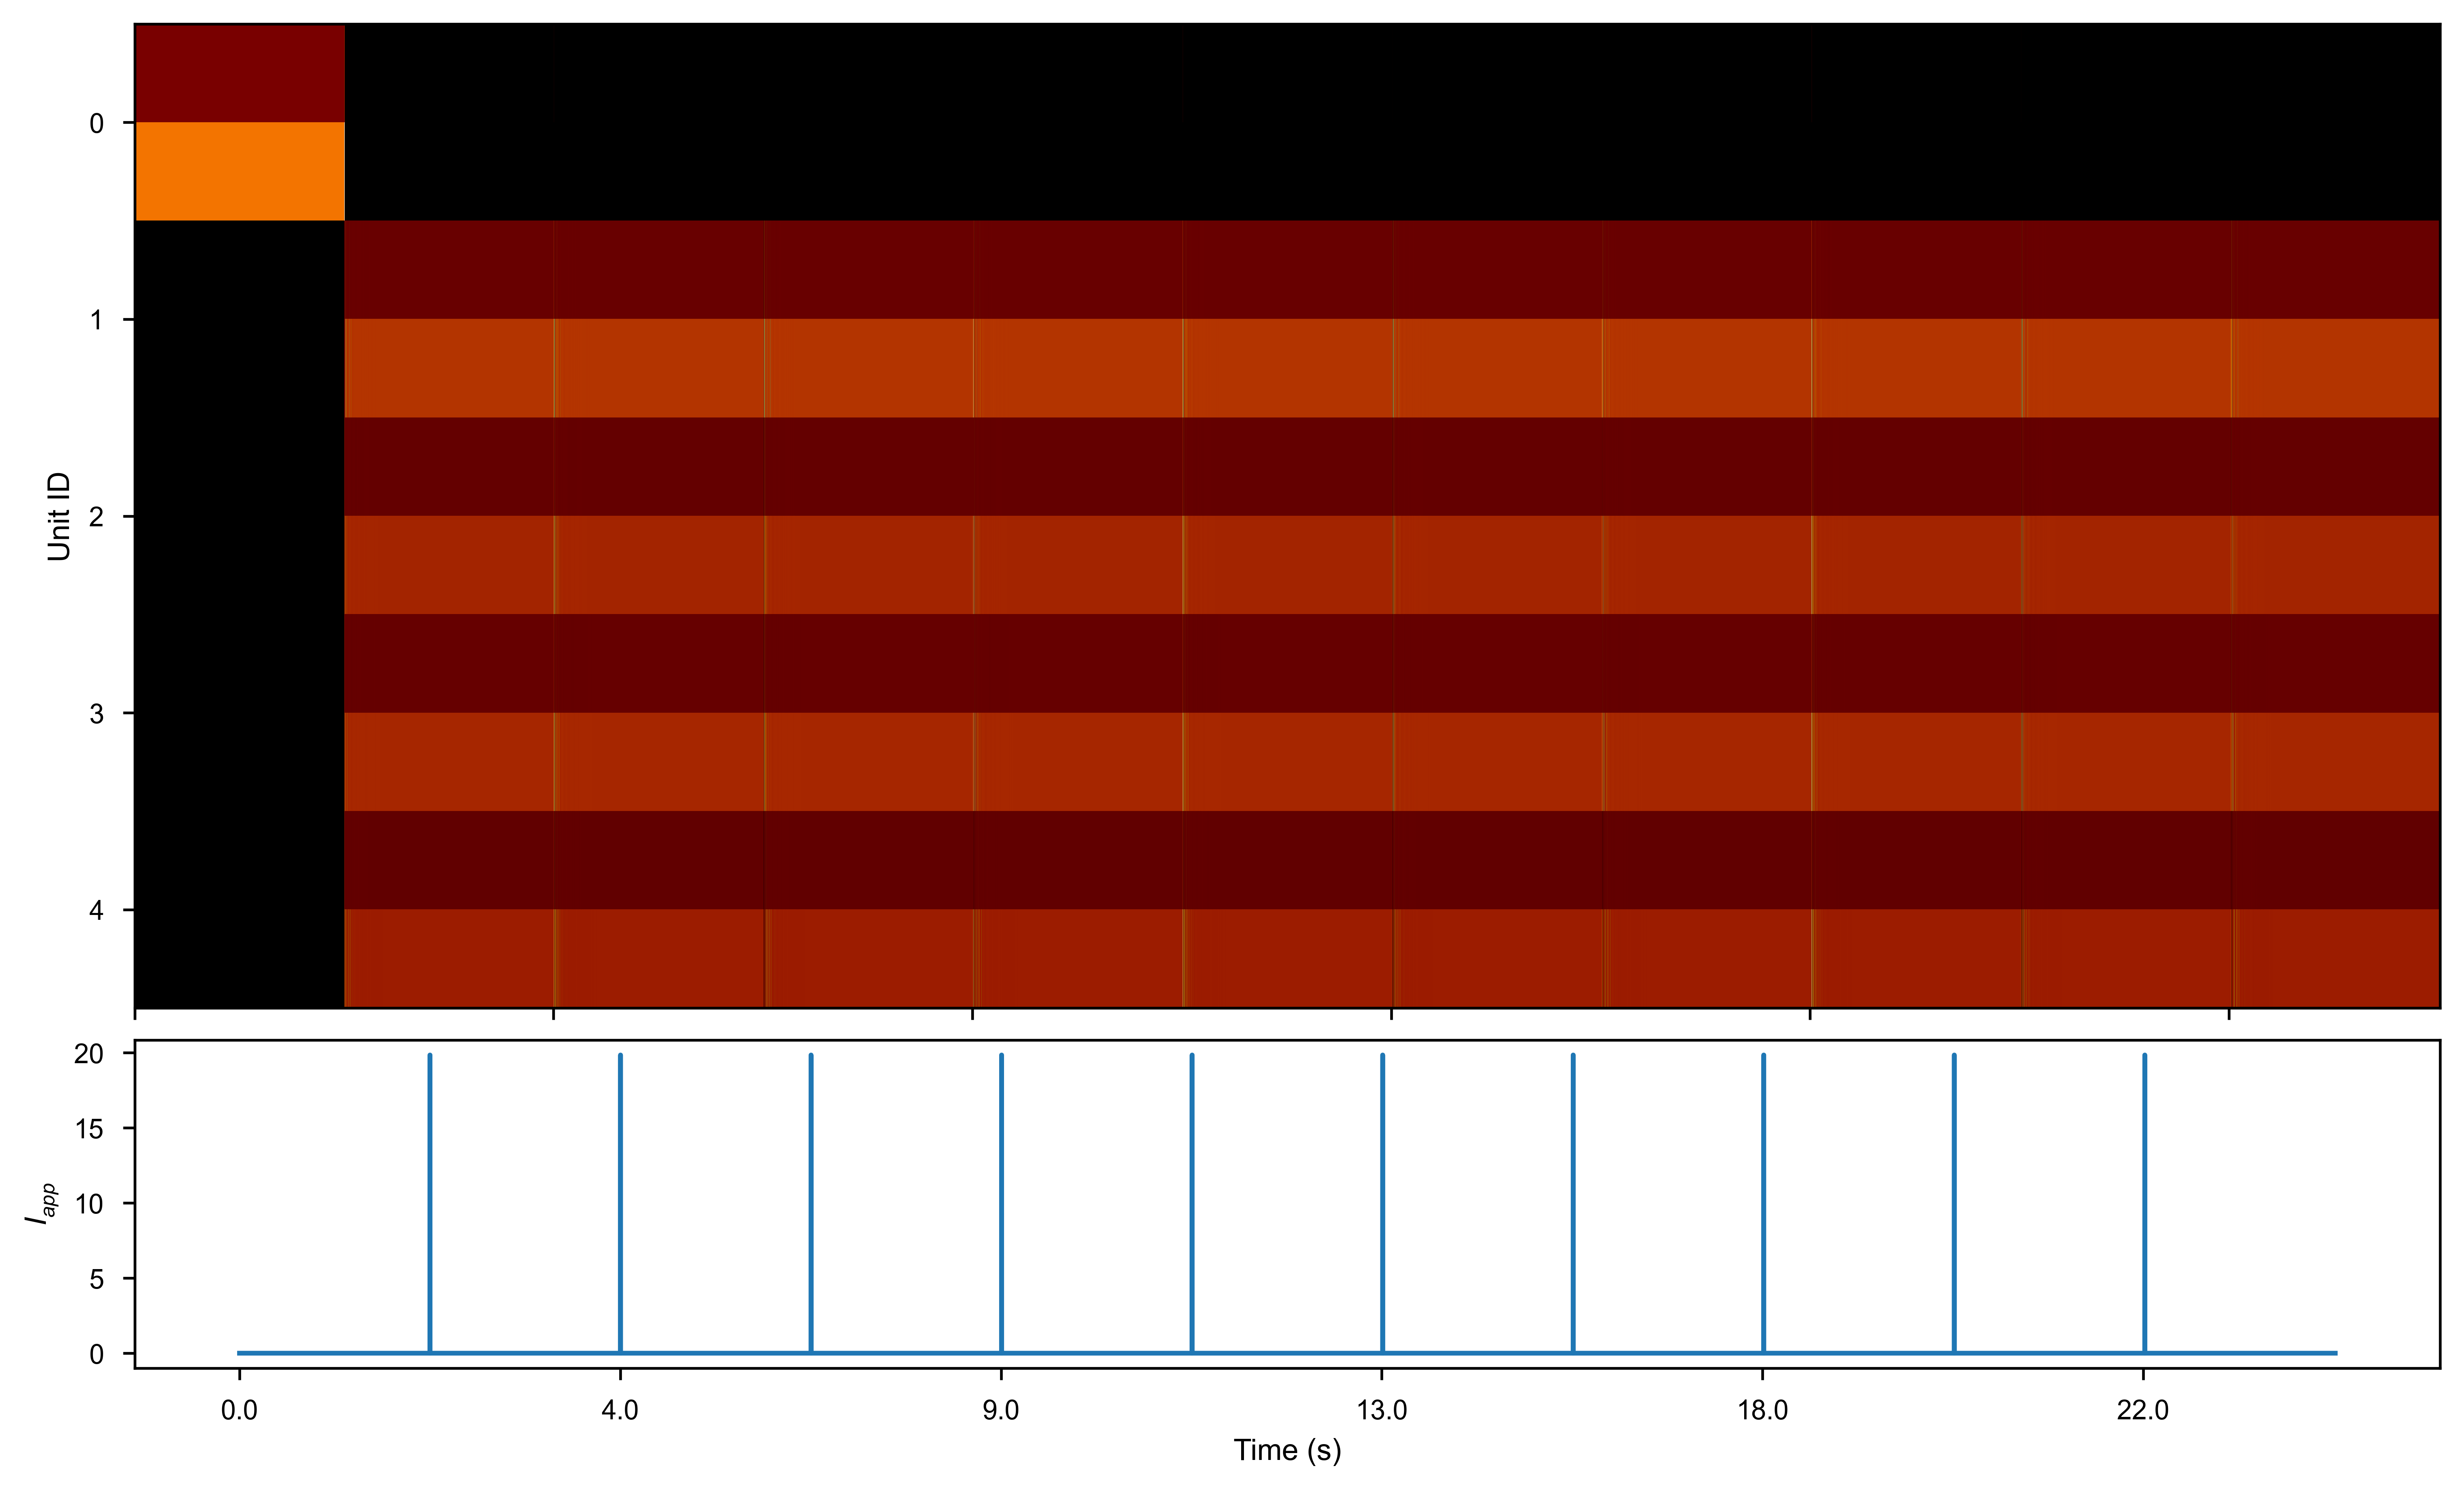

In [19]:
for i, state in enumerate(states):
    print(f"State {i}")
    rates = network_model.simulateISN(Wji, numPairs, states[i], pset, IappE, IappI, dt, total_duration)
    raw_time_len = min(rates.shape[-1], IappE.shape[-1])
    rates, IappE = rates[:,:,:raw_time_len], IappE[:, :raw_time_len]
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]}, constrained_layout=True)
    plot_trace(rates, IappE, axs[0], axs[1])
    plt.show()


In [20]:
def plot_FSM(G, ax):
    weak_components = list(nx.weakly_connected_components(G))
    colors = [i for i in range(len(weak_components))]
    node_colors_dict = {node: colors[i] for i, comp in enumerate(weak_components) for node in comp}
    node_colors = [node_colors_dict[node] for node in list(G)]
    edge_colors = [node_colors_dict[edge[0]] for edge in G.edges()]
    
    longest_path = network_model.get_longest_path(G)
    edge_widths = [2 if edge[0] in longest_path and edge[1] in longest_path else 1 for edge in G.edges()]
    
    nx.draw_networkx_nodes(G, ax=ax, nodelist=longest_path, pos = nx.arf_layout(G, pos=nx.planar_layout(G)), node_color='k',
                        node_size=400)
    nx.draw_networkx_nodes(G, ax=ax, pos = nx.arf_layout(G, pos=nx.planar_layout(G)), node_color = node_colors)
    nx.draw_networkx_edges(G, ax=ax, pos = nx.arf_layout(G, pos=nx.planar_layout(G)), arrows=True, 
                        edge_color=edge_colors, width=edge_widths)
    
    ax.spines['bottom'].set_color('red')
    ax.spines['top'].set_color('red') 
    ax.spines['right'].set_color('red')
    ax.spines['left'].set_color('red')

In [21]:
def plot_stim_sweep(ax):
    c = ax.pcolormesh(dur_mesh, amp_mesh, longest_paths.reshape((30, 30)), shading='auto')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\tau_{dur} (s)$')
    ax.set_ylabel(r'$I_{app}$')
    return c

In [22]:
def draw_rect_pcolormesh(ax, i, j, X, Y, color='red', alpha=1, linewidth=0.1):
    dx = X[j + 1, i + 1] - X[j, i]
    dy = Y[j + 1, i + 1] - Y[j, i]
    x0 = X[j, i] - dx/2
    y0 = Y[j, i] - dy/2
    rect = plt.Rectangle((x0, y0), dx, dy, color=color, alpha=alpha,
                         linewidth=linewidth, fill=False, zorder=10)
    ax.add_patch(rect)

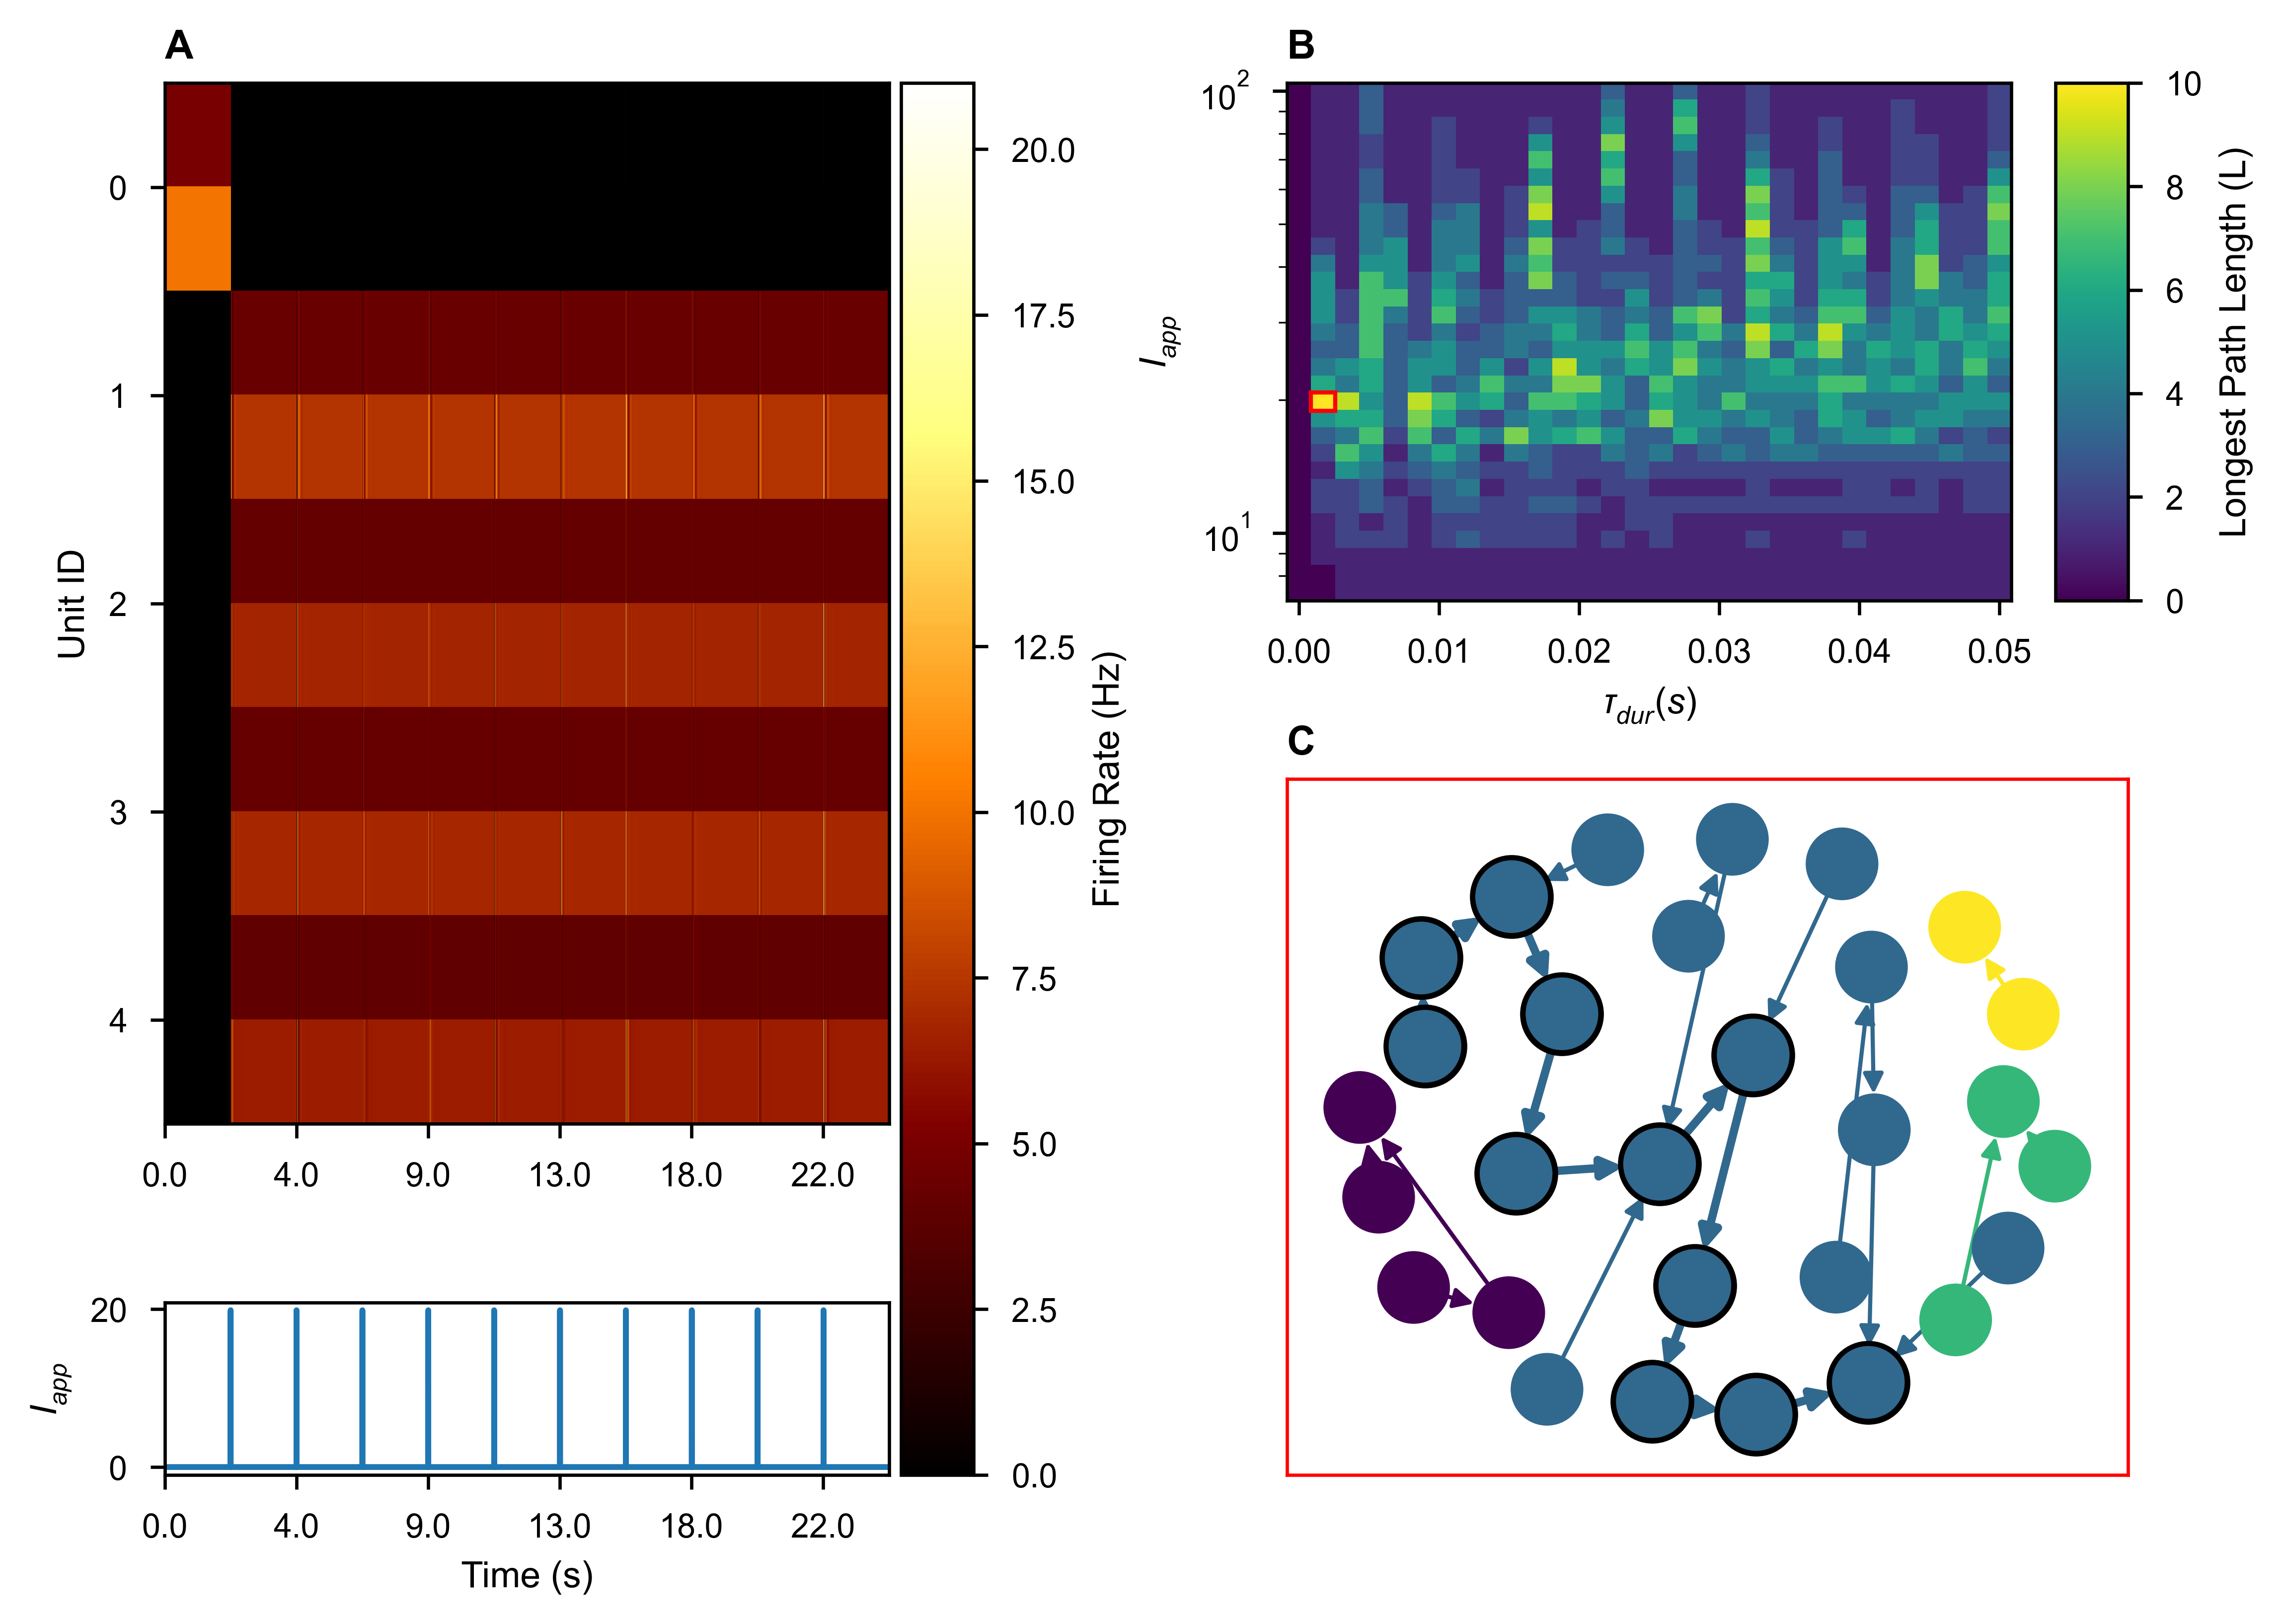

In [23]:
MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250

px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig = plt.figure(layout='constrained', figsize=(MAX_WIDTH*px, MAX_WIDTH*px*0.7))
axd = fig.subplot_mosaic(
    """
    axBX
    axCC
    SxCC
    """,
    width_ratios=[1, 0.1, 1, 0.1],
    height_ratios=[3,2,1]
)
# figure titles
label_dict ={'a':'A',
             'B':'B',
             'C':'C'}
for name, ax in axd.items():
    label = label_dict.get(name, None)
    if label is not None:
        ax.set_title(label, loc='left', fontweight='bold')

# share axes
axd['a'].sharex(axd['S'])

# plot A
vals = plot_trace(rates, IappE, axd['a'], axd['S'])
fig.colorbar(vals, cax=axd['x'], label='Firing Rate (Hz)')

# plot B
c = plot_stim_sweep(axd['B'])
fig.colorbar(c, cax=axd['X'], label='Longest Path Length (L)')
draw_rect_pcolormesh(axd['B'], 1, 11, dur_mesh, amp_mesh, linewidth=1)

# plot C
plot_FSM(G, axd['C'])

fig.set_constrained_layout_pads(h_pad=0.0, hspace=0.0, w_pad=0.02, wspace=0.02)

plt.show()